# Substitution

This notebook compares the predicted substitution rates with various other sets of data, such as 

 - phylofit branch length estimates
 - the number of subsitutions in genes (from Urrichio et al.)
 
The goal is to check that the model is making reasonable predictions in terms of the substitution rate. 

It is exceedingly important that we avoid cirular logic here. For example, the predicted ratchet rates per segment depend on that annotation class, which each have their own DFE estimates.

There are a few checks we can do: 

 - total predicted substitution rate versus observed 
 - spatial patterns of predicted versus observed substitution rates along the chromosome
 - predicted versus observed by feature type
 
There is not a great deal of variance in predicted substitution rates (as we'll see later). It's important that we ensure that the correspondance between predicted and observed isn't just an artifact of densities of the different annotation classes. This wouldn't be entirely an artifact or circular reasoning, but we should ensure the correspondence is good within classes too.

### TODO

- re-join in rescaled B' to `d` dataframe.
- fix cut_tails in k-folds

## Requisites

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [324]:
import pickle
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
import matplotlib as mpl

from bgspy.models import BGSModel
from bgspy.utils import logbins, bin2midpoints, cutbins, bin2pairs, binned_summaries
from bgspy.utils import corr, mean_ratio, censor, pretty_signif
from bgspy.plots import get_figax, binned_means_plot
from bgspy.nonparametric import KernelRegression, bin_kfolds, kfolds_results

In [3]:
plt.show()

In [90]:
plt.style.use('./buffalo.mplstyle')
plt.rcParams['figure.figsize'] = [8, 3.5]
plt.rcParams['figure.dpi'] = 200

prop_cycle = plt.rcParams['axes.prop_cycle']
COLORS = prop_cycle.by_key()['color']

### Unit Setup

In [5]:
import unyt as u
u.define_unit('human_gen', 30 * u.year)
u.define_unit('mutations', 1 * u.count)

In [6]:
MU = 1.3e-8 * (u.mutations/u.human_gen)

T_HCs = u.array.unyt_array([6_000_000, 12_000_000], u.year)

2 * MU * T_HCs

unyt_array([0.0052, 0.0104], 'mutations')

In [7]:
MU.to('mutations/year')

unyt_quantity(4.33333333e-10, 'mutations/yr')

## Data and EDA

Most of the raw data processing is done in `data/phylo/Snakefile` — see that for details. 

###  B and R Maps

In [8]:
m_pkl = '../data/bmaps/bgspy/bmap_hg38_6x7grid_10000step_10000N_cds_utrs_phastcons.pkl'
m = BGSModel.load(m_pkl)

# From the rescaled second run
mf_pkl = '../data/bmaps/bgspy/bmap_rescaled_hg38_6x7grid_10000step_10000N_cds_utrs_phastcons.pkl'
mf = BGSModel.load(mf_pkl)

In [9]:
m

### Model Fits

Just for looking at estimated DFEs

In [752]:
bfit, bpfit = pickle.load(open('../fits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl', 'rb'))
bfit_sm, bpfit_sm = pickle.load(open('../fits/hg38_cds_utrs_phastcons_simplex/hg38_cds_utrs_phastcons/window_1000000/mle.pkl', 'rb'))

/tmp/ipykernel_57592/162595166.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='../fits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl'>
  bfit, bpfit = pickle.load(open('../fits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl', 'rb'))
/tmp/ipykernel_57592/162595166.py:2: ResourceWarning: unclosed file <_io.BufferedReader name='../fits/hg38_cds_utrs_phastcons_simplex/hg38_cds_utrs_phastcons/window_1000000/mle.pkl'>
  bfit_sm, bpfit_sm = pickle.load(open('../fits/hg38_cds_utrs_phastcons_simplex/hg38_cds_utrs_phastcons/window_1000000/mle.pkl', 'rb'))


In [11]:
bfit_fixed_sm, bpfit_fixed_sm = pickle.load(open('../fits/hg38_cds_utrs_phastcons_fixed/hg38_cds_utrs_phastcons_fixed/window_1000000/mle.pkl', 'rb'))

In [13]:
bpfit_sm

MLE (interpolated w): 6 x 7 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 915792862866.7292
π0 = 0.0019124912150800212
μ = 3.205541960151368e-08
R² = 64.6505
W = 
          cds    phastcons    utr
------  -----  -----------  -----
1e-07   0.02         0.051  0.476
1e-06   0.188        0.131  0.028
1e-05   0.199        0.054  0.125
0.0001  0.05         0.015  0.102
0.001   0.13         0.194  0.172
0.01    0.247        0.346  0.05
0.1     0.167        0.208  0.047

In [14]:
bpfit_fixed_sm

MLE (interpolated w): 6 x 7 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Fixed-Mutation Simplex model ML estimates:
negative log-likelihood: 915340910487.3662
π0 = 0.001626917442522154
μ = 1.3e-08 (fixed)
R² = 64.0393
W = 
          cds    phastcons    utr
------  -----  -----------  -----
1e-07   0.593        0      0
1e-06   0.019        0      0
1e-05   0.054        0      0
0.0001  0.001        0      0.06
0.001   0.001        0.753  0.164
0.01    0.007        0.247  0.325
0.1     0.326        0      0.452

In [15]:
bpfit_sm.mle_pi0 / (4*1.3e-8) #* bpfit_sm.predict(B=True).mean()

36778.67721307733

In [16]:
bpfit_sm.W_to_tsv('../slim_sims/chrombgs_features/cds_utrs_phastcons_mle.tsv')

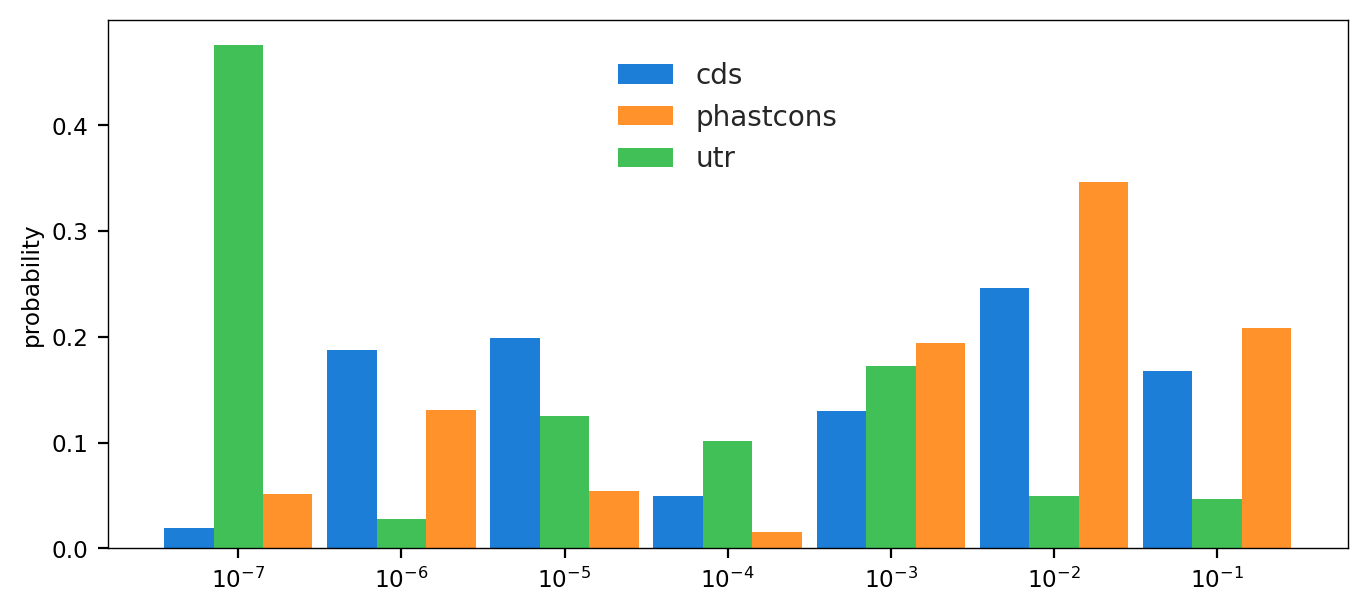

In [17]:
fit = bpfit_sm
xt = np.log10(fit.t)

fig, ax = plt.subplots()

w = 1/3-0.03
hw = w/2
ax.bar(xt-w-hw, fit.mle_W[:, 0], align='edge', width=w, label='cds')
ax.bar(xt+w-hw, fit.mle_W[:, 1], align='edge', width=w, label='phastcons')
ax.bar(xt-hw, fit.mle_W[:, 2], align='edge', width=w, label='utr')

ax.set_xticks(np.log10(fit.t), [f"$10^{{{int(x)}}}$" for x in xt])
ax.set_ylabel('probability')
ax.legend()

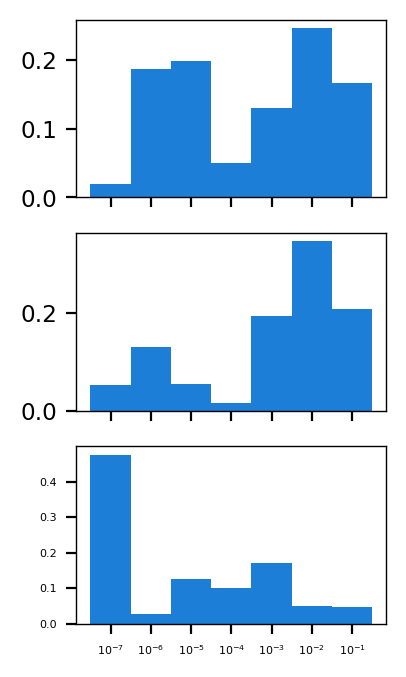

In [18]:
fit = bpfit_sm
xt = np.log10(fit.t)

fig, ax = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(2, 4))

w = 1/3-0.03
hw = w/2
ax[0].bar(xt, fit.mle_W[:, 0], align='edge', width=1, label='cds')
ax[1].bar(xt, fit.mle_W[:, 1], align='edge', width=1, label='phastcons')
ax[2].bar(xt, fit.mle_W[:, 2], align='edge', width=1, label='utr')

ax[2].set_xticks(np.log10(fit.t)+0.5, [f"$10^{{{int(x)}}}$" for x in xt])
ax[2].tick_params(axis='both', which='major', labelsize=4)
#ax.set_ylabel('probability')
#ax.legend()

### Rescaling

After the MLE is estimated, we get a predicted B(x) map. We can use the local B(x) in the system of equations we solve for B and the ratchet rate; this is the "local rescaling" step since the single $N_e$ is rescaled locally along the genome.

What is the distribution of the local rescaling factors (e.g. B) across segments? 

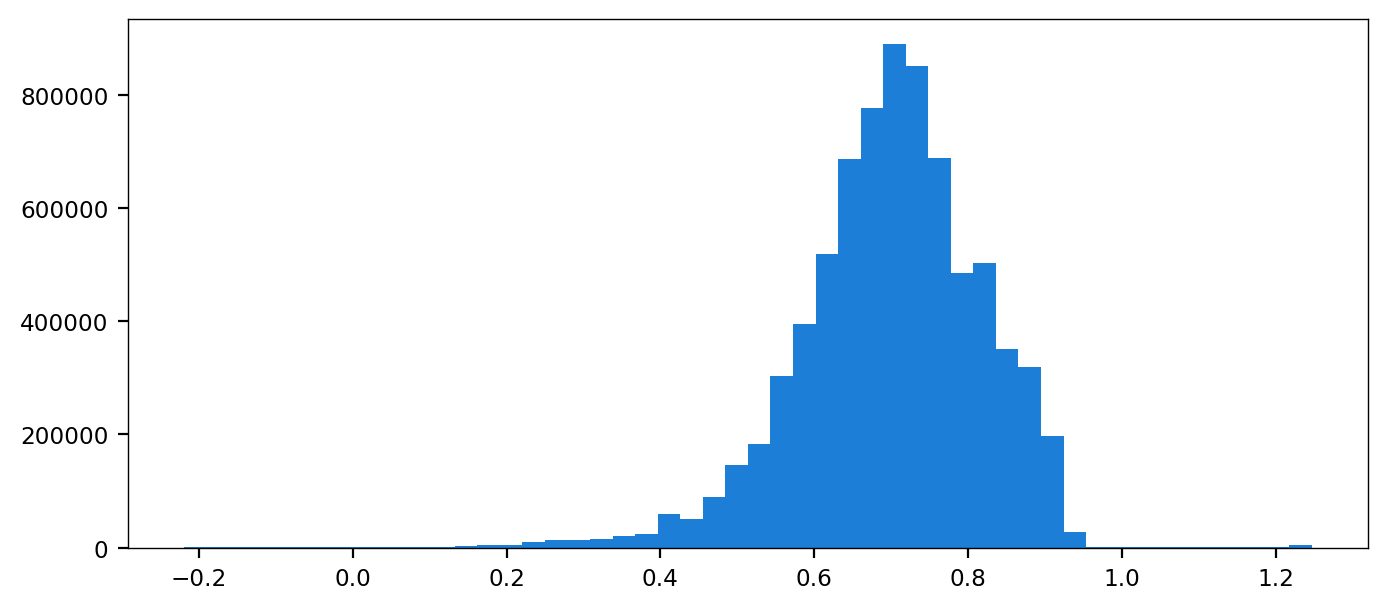

In [19]:
_ = plt.hist(mf.genome.segments.rescaling, 50)

In [20]:
mf.genome.segments.rescaling.mean()

0.6998490873081481

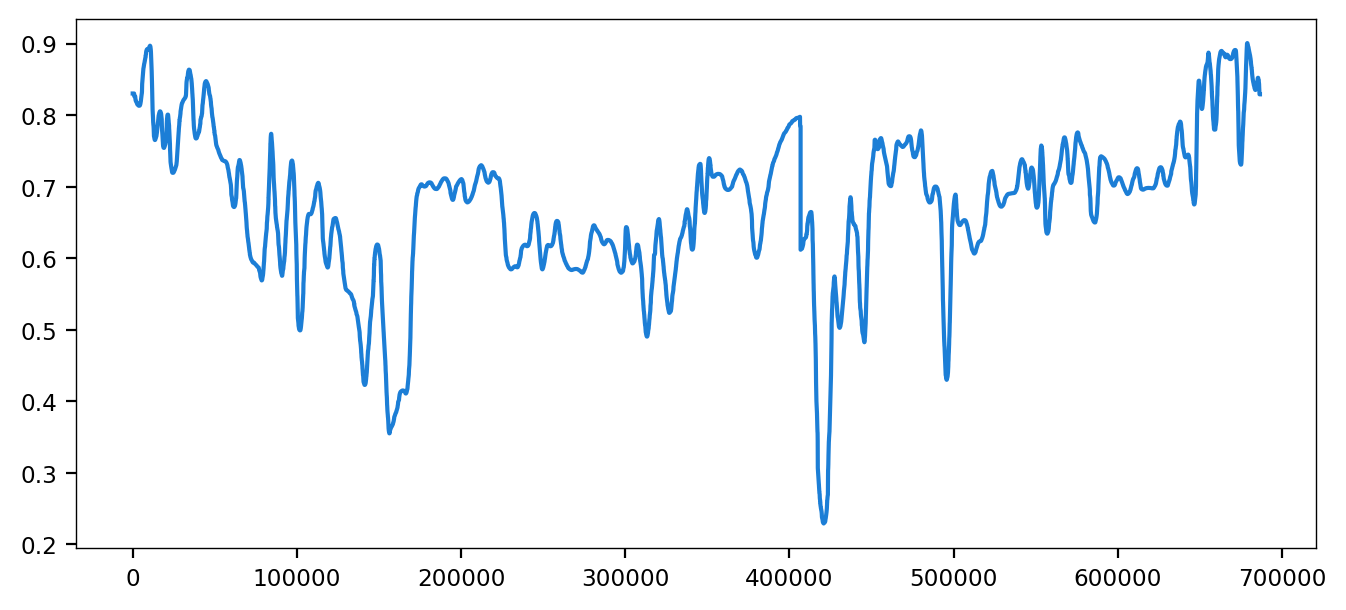

In [21]:
plt.plot(mf.genome.segments.rescaling[mf.genome.segments.index['chr1']])

How does the locally-rescaled B' differ from unscaled one?

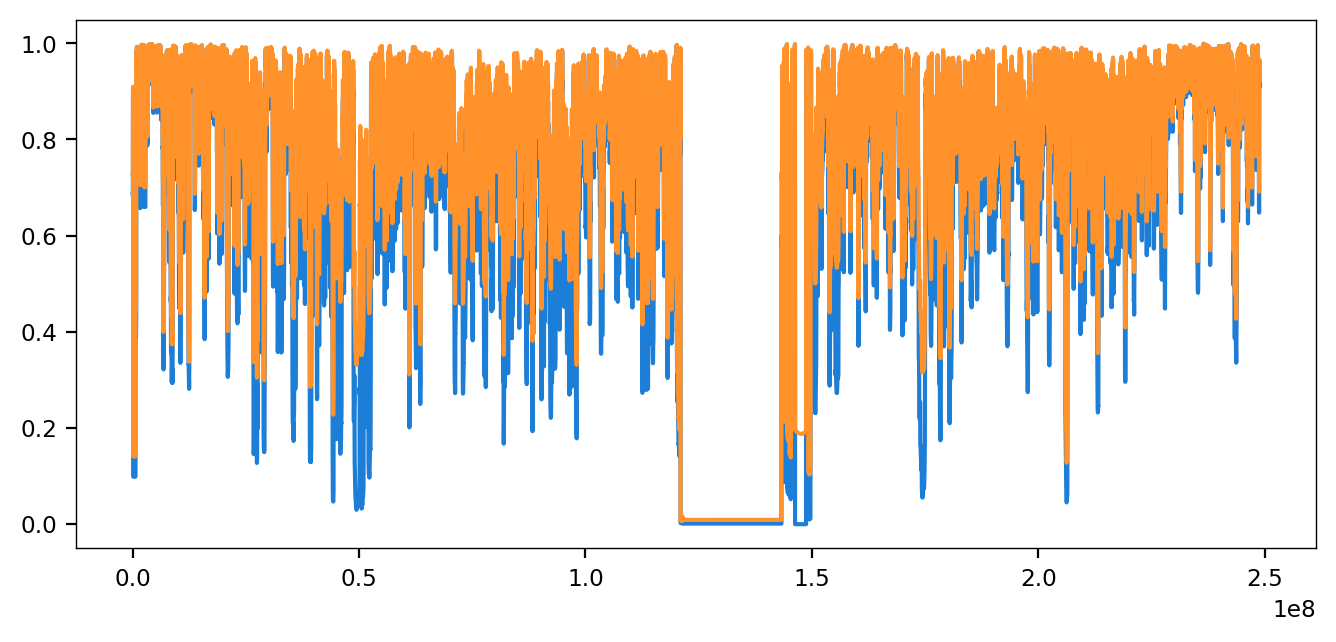

In [239]:
x, y = m.BpScores.pairs('chr1', m.w[4], 1e-4)
plt.plot(x, y[:, 1])

xf, yf = mf.BpScores.pairs('chr1', mf.w[4], 1e-4)
plt.plot(xf, yf[:, 1])
#plt.semilogy()

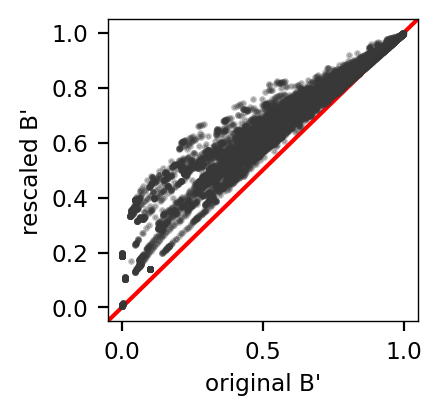

In [249]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.scatter(y[:, 1], yf[:, 1], s=2, c='0.22', alpha=0.3)
ax.set_ylabel("rescaled B'")
ax.set_xlabel("original B'")
ax.axline((0, 0), slope=1, c='r', zorder=-1)

### Raw Predicted Substitution Rates and Rescaled Rates

In [554]:
cols = ('gene_id', 'chrom', 'start', 'end', 'subrate', 'len')

dpf = pd.read_csv('../data/phylo/phylofit_cds_rates.bed', sep='\t', names=cols)

In [555]:
dpf

gene_id chrom      start        end   subrate   len
0      ENSG00000186092  chr1      69091      70008  0.006558   918
1             uc057auo  chr1     182709     184158  0.000302   404
2             uc057auq  chr1     185217     195411  0.004031  1405
3      ENSG00000284733  chr1     450740     451678  0.002883   939
4      ENSG00000284662  chr1     685716     686654  0.002883   939
...                ...   ...        ...        ...       ...   ...
19233  ENSG00000165724  chr9  137582543  137590263  0.004407   689
19234  ENSG00000197070  chr9  137605718  137615138  0.005423  1309
19235  ENSG00000181090  chr9  137619029  137834953  0.002497  3923
19236  ENSG00000148408  chr9  137877934  138121999  0.002555  7066
19237         uc064xof  chr9  138286275  138294420  0.010760   218

[19238 rows x 6 columns]

In [553]:
np.mean([x.startswith('ENSG') for x in dpf['gene_id'].values])

0.9557126520428318

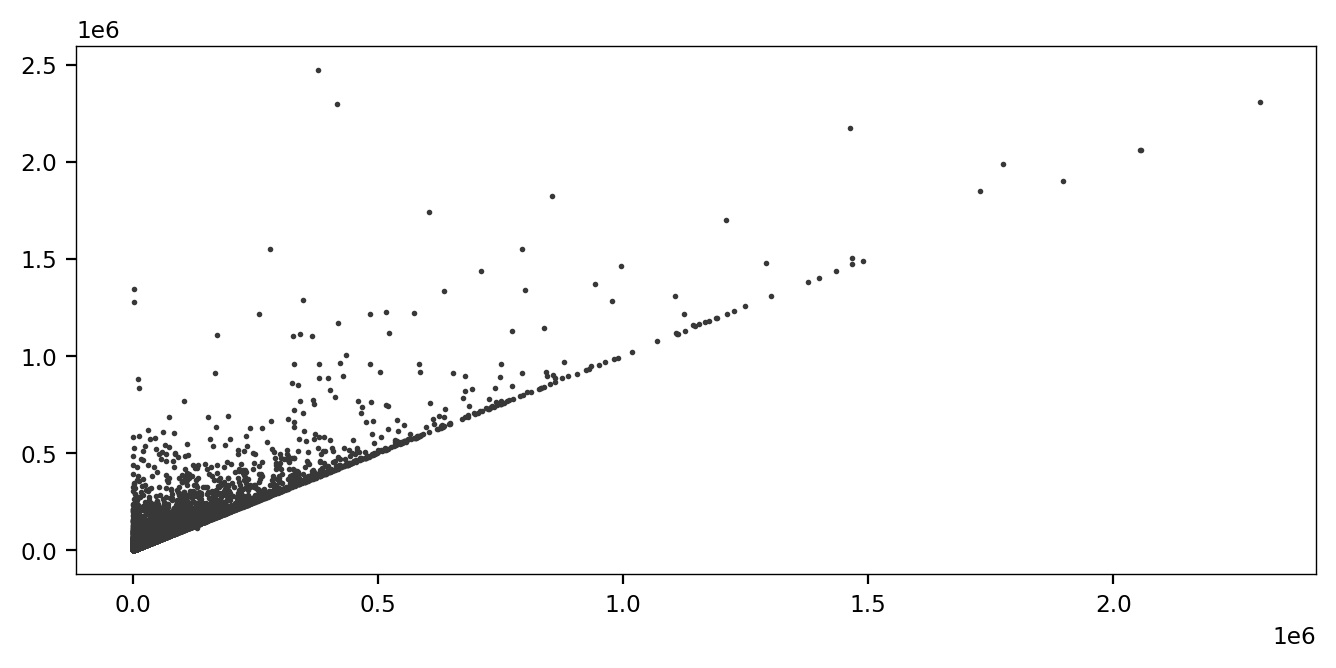

In [542]:
xx = do.merge(dpf, on='gene_id')
plt.scatter(xx['aln_len'], xx['width'], s=1, c='0.22')

In [547]:
d.shape

(16316, 29)

In [511]:
np.sum([x is not None for x in dpf['gene_id']])

15872

In [507]:
corr(xx['subrate'], xx['r_rs'])

((0.2606026545733256, 1.0458739869614031e-244),
 SpearmanrResult(correlation=0.24507208624756424, pvalue=9.125757671981132e-216))

Text(0.5, 0, 'predicted substitution rate')

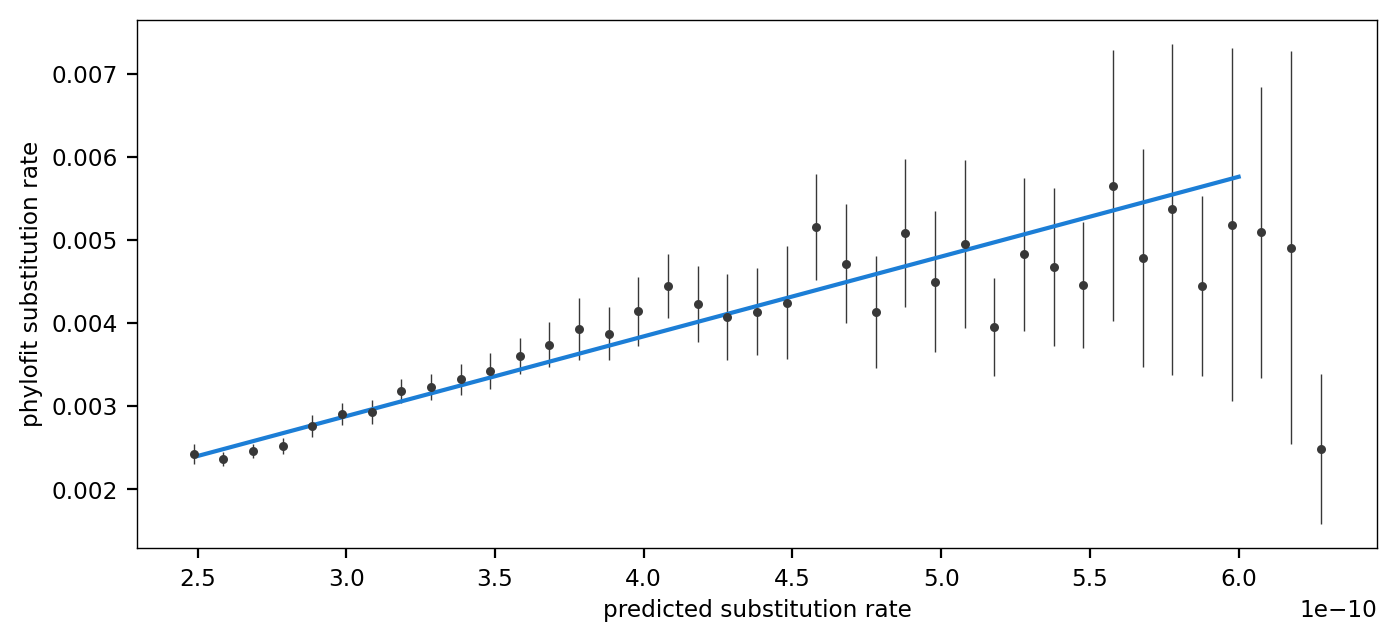

In [528]:
binned_means_plot(binned_summaries(xx['r_rs']/30, xx['subrate'], 50), min_n=10)
xr = np.linspace(2.5e-10, 6e-10, 100)
plt.plot(xr, 0.8*T_HCs[1]*xr)
plt.ylabel('phylofit substitution rate')
plt.xlabel('predicted substitution rate')

In [545]:
stats.linregress(xx['r_rs']/30, xx['subrate']), corr(xx['r_rs']/30, xx['subrate'])

(LinregressResult(slope=9736581.286396023, intercept=-3.0127947776694818e-05, rvalue=0.26060265457332554, pvalue=1.0458739869617075e-244, stderr=286330.25991315814, intercept_stderr=9.663464222334386e-05),
 ((0.2606026545733256, 1.0458739869614031e-244),
  SpearmanrResult(correlation=0.24507208624756427, pvalue=9.125757671979572e-216)))

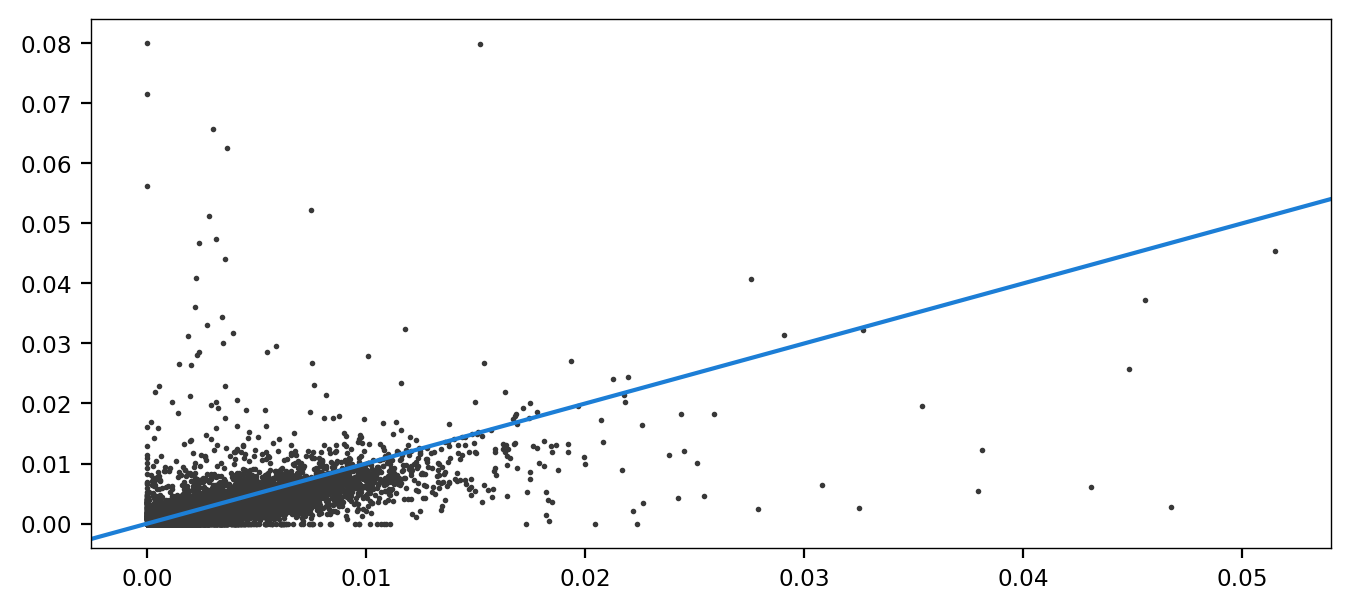

In [505]:
xx = do.merge(dpf, on='gene_id')
plt.scatter(xx['subrate'], xx['total_prop'], c='0.22', s=1)
plt.axline((0, 0), slope=1)

In [758]:
do['r_rs']

0        8.610962e-09
1        9.234576e-09
2        1.012162e-08
3        9.110700e-09
4        1.038721e-08
             ...     
16311    9.406762e-09
16312    9.390737e-09
16313    1.034954e-08
16314    1.107923e-08
16315    8.324066e-09
Name: r_rs, Length: 16316, dtype: float64

In [756]:
d['r_rs']

0        1.213545e-08
1        1.213500e-08
2        1.213586e-08
3        1.213590e-08
4        1.214276e-08
             ...     
16311    1.214230e-08
16312    1.214205e-08
16313    1.214290e-08
16314    1.214141e-08
16315    1.214225e-08
Name: r_rs, Length: 16316, dtype: float64

### Binned Ratchet Rates and phylFit Estimates (Megabase)

We load the rescaled predictions.

In [24]:
cols = ('chrom', 'start', 'end', 'R', 'r_rs', 'r_rs_bases')
r1Mb = pd.read_csv('../data/phylo/ratchet_rescaled_rates_binned_1000000.bed', names=cols,
                   na_values='.', sep='\t')
r1Mb['midpoint'] = 0.5*(r1Mb['start'] + r1Mb['end'])

cols = ('chrom', 'start', 'end', 'R', 'branch_length', 'ml_bases')
pf1Mb = pd.read_csv('../data/phylo/phylofit_rates_binned_1000000.bed', names=cols,
                   na_values='.', sep='\t')
pf1Mb['midpoint'] = 0.5*(pf1Mb['start'] + pf1Mb['end'])

### Uricchio et al (2019) Substitution Data

From [this paper](https://www.nature.com/articles/s41559-019-0890-6). See the `data/phylo/Snakefile` for more information on how this is processed. 

Since we want the proportion of subsitutions and the Urrichio data doesn't have the number of codons considered, I joined Uricchio's data with the Ensembl canonical transcript CDS lengths.

This dataset also has the phylofit substitution rates joined in.

The raw Uricchio data (`../data/phylo/41559_2019_890_MOESM3_ESM.txt`) has columns:
   
1. Ensembl coding gene ID
2. Number of non-synonymous polymorphic sites
3. Respective derived allele frequencies of these sites separated by commas
4. Number of synonymous polymorphic sites. 
5. Respective frequencies derived allele frequencies of these sites.
6. Number of fixed non-synonymous substitutions on the human branch.
7. Number of fixed synonymous substitutions on the human branch. 

In [859]:
da = pd.read_csv('../data/phylo/uricchio_data_merged.tsv', sep='\t', na_values='.')

In [860]:
da.head()

chrom   start     end          gene_id  n_nonsyn  n_syn  fixed_nonsyn  \
0  chr1  923923  944575  ENSG00000187634        28     21             8   
1  chr1  944203  959309  ENSG00000188976        31     32             4   
2  chr1  960584  965719  ENSG00000187961        11     28             0   
3  chr1  966482  975865  ENSG00000187583        47     19             0   
4  chr1  975198  982117  ENSG00000187642        31     22            11   

   fixed_syn      dnds  total_fixed  ...           S            N  \
0          4  2.000000           12  ...  677.333333  1854.666667   
1          8  0.500000           12  ...  524.666667  1722.333333   
2          8  0.000000            8  ...  484.000000  1442.000000   
3          3  0.000000            3  ...  473.666667  1359.333333   
4          3  3.666667           14  ...  626.000000  1744.000000   

           r_rs  r_rs_nbases          r_us  r_us_nbases  pf_subrate  \
0  8.610962e-09         4658  1.182606e-08       2653.0    0.007336   
1  9.234576e-09         2950  1.182483e-08       2231.0    0.007094   
2  1.012162e-08         2776  1.182549e-08       1548.0    0.006425   
3  9.110700e-09         3800  1.182515e-08       1977.0    0.004622   
4  1.038721e-08         4203  1.183362e-08       2370.0    0.013330   

   pf_nbases  width  midpoint  
0     2058.0  20652  934249.0  
1     2268.0  15106  951756.0  
2     1940.0   5135  963151.5  
3     1851.0   9383  971173.5  
4     2375.0   6919  978657.5  

[5 rows x 28 columns]

(<Figure size 1600x700 with 1 Axes>, <AxesSubplot: >)

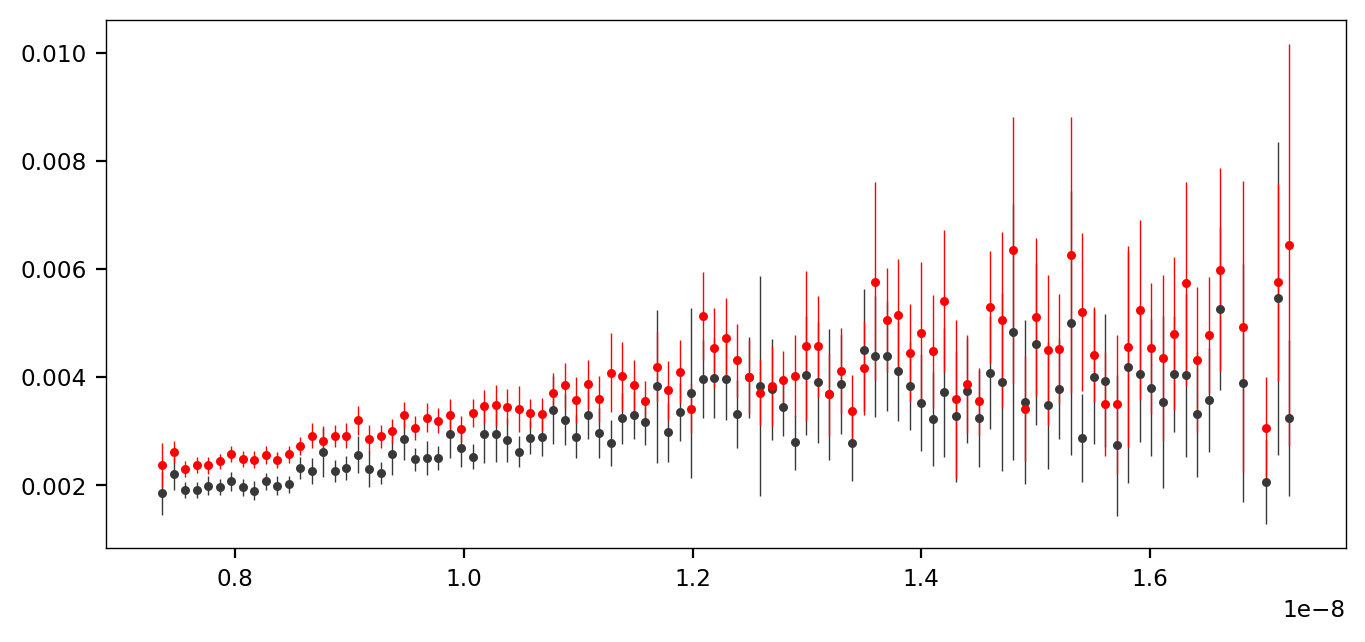

In [871]:
figax = plt.subplots()
binned_means_plot(binned_summaries(da['r_rs'], da['total_prop'], 100, cut_tails=(0, 0.99)), min_n=10, figax=figax)
binned_means_plot(binned_summaries(da['r_rs'], da['pf_subrate'], 100, cut_tails=(0, 0.99)), min_n=10, figax=figax, c= 'r')

(<Figure size 1600x700 with 1 Axes>, <AxesSubplot: >)

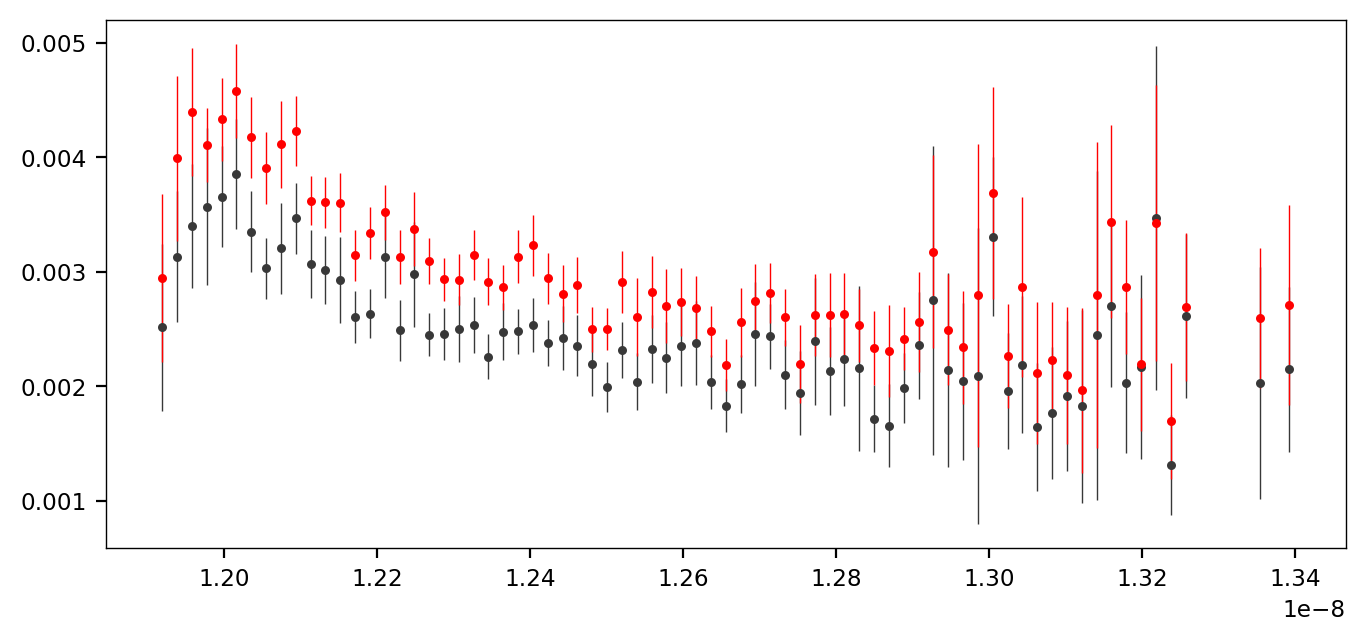

In [858]:
figax = plt.subplots()
binned_means_plot(binned_summaries(da['r_rs'], da['total_prop'], 100, cut_tails=(0, 0.99)), min_n=10, figax=figax)
binned_means_plot(binned_summaries(da['r_rs'], da['pf_subrate'], 100, cut_tails=(0, 0.99)), min_n=10, figax=figax, c= 'r')

In [876]:
dm_pc =  pd.read_table('../data/phylo/phylofit_rescaled_ratchet_phastcons_merged.bed', na_values='.', names='chrom start end gene_id subrate n r_rs'.split(' '))

(<Figure size 1600x700 with 1 Axes>, <AxesSubplot: >)

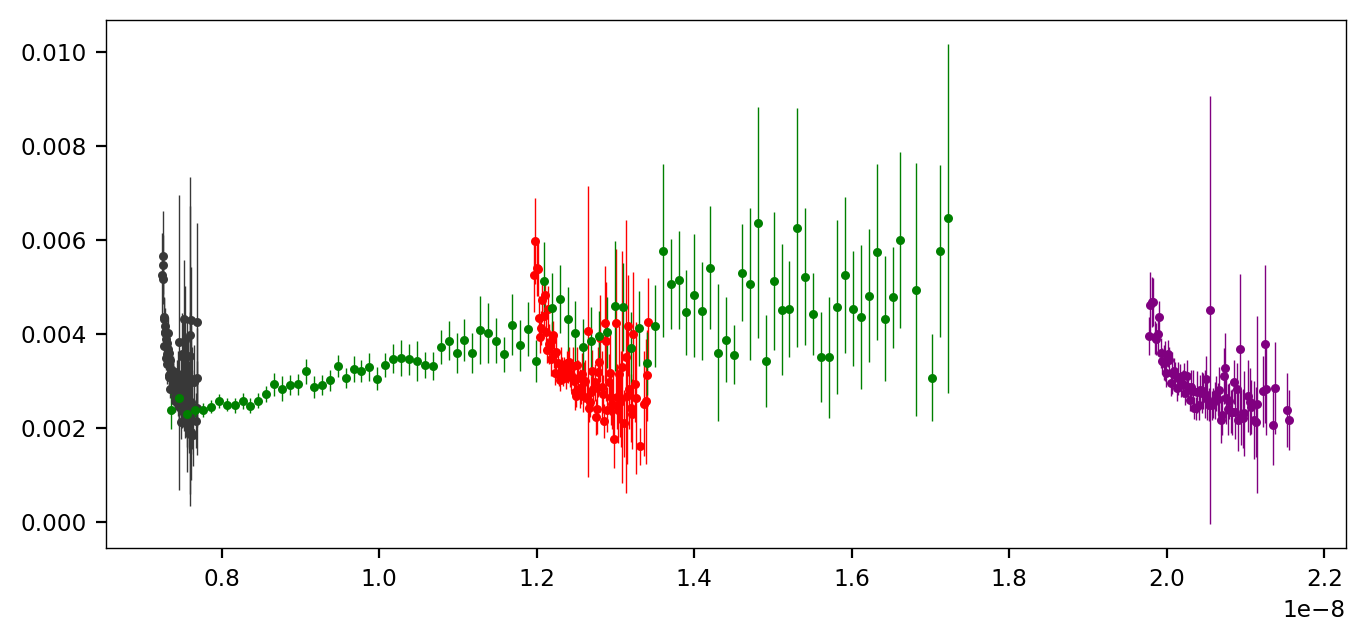

In [878]:
dm_cds =  pd.read_table('../data/phylo/phylofit_rescaled_ratchet_cds_merged.bed', na_values='.', names='chrom start end gene_id subrate n r_rs'.split(' '))
dm_utr =  pd.read_table('../data/phylo/phylofit_rescaled_ratchet_utr_merged.bed', na_values='.', names='chrom start end gene_id subrate n r_rs'.split(' '))

fig, ax = plt.subplots()
binned_means_plot(binned_summaries(dm_pc['r_rs'], dm_pc['subrate'], 100, cut_tails=(0.01, 0.99)), min_n=10, figax=(fig, ax))
binned_means_plot(binned_summaries(dm_cds['r_rs'], dm_cds['subrate'], 100, cut_tails=(0.01, 0.99)), min_n=10, figax=(fig, ax), c='r')
binned_means_plot(binned_summaries(dm_utr['r_rs'], dm_utr['subrate'], 100, cut_tails=(0.01, 0.99)), min_n=10, figax=(fig, ax), c='purple')

binned_means_plot(binned_summaries(da['r_rs'], da['pf_subrate'], 100, cut_tails=(0, 0.99)), min_n=10, figax=(fig, ax), c= 'green')


(<Figure size 1600x700 with 1 Axes>, <AxesSubplot: >)

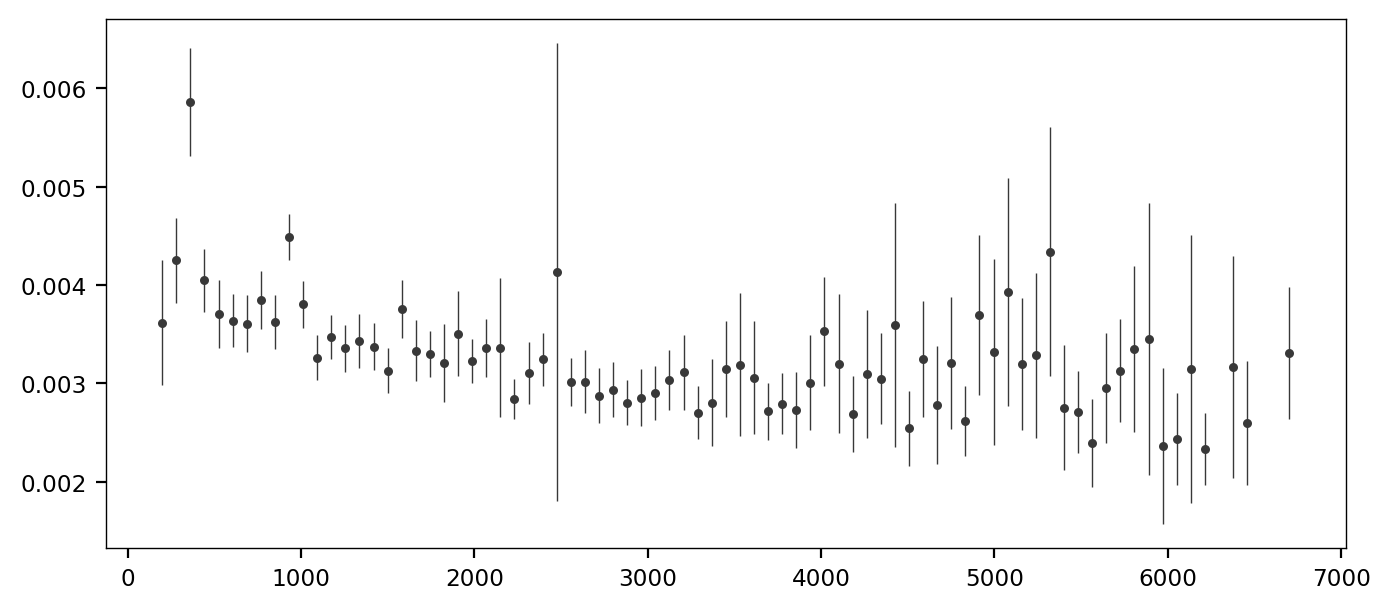

In [898]:
binned_means_plot(binned_summaries(dm_cds['n'], dm_cds['subrate'], 100, cut_tails=(0.01, 0.99)), min_n=10)


(<Figure size 1600x700 with 1 Axes>, <AxesSubplot: >)

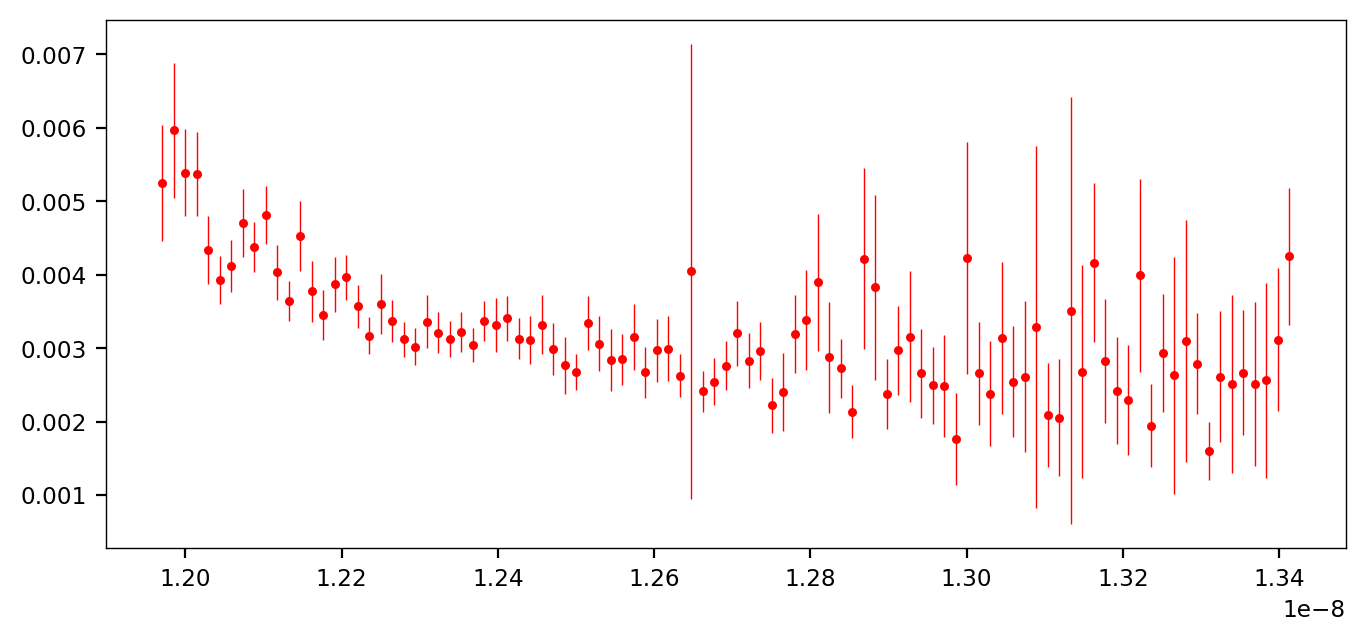

In [893]:
fig, ax = plt.subplots()
binned_means_plot(binned_summaries(dm_cds['r_rs'], dm_cds['subrate'], 100, cut_tails=(0.01, 0.99)), figax=(fig, ax), c='r')

In [885]:
dm_utr['r_rs'].mean(), dm_cds['r_rs'].mean(), dm_pc['r_rs'].mean()

(2.0229933018486284e-08, 1.2366354109762587e-08, 7.3732298673096565e-09)

In [889]:
dm_utr.loc[~dm_utr['r_rs'].isnull(), 'subrate'].mean(), dm_cds.loc[~dm_cds['r_rs'].isnull(),'subrate'].mean(), dm_pc.loc[~dm_pc['r_rs'].isnull(),'subrate'].mean()

(0.0032094356048033516, 0.00358112457059034, 0.0034118042669625875)

In [884]:
np.isnan(dm_utr['r_rs']).mean(), np.isnan(dm_cds['r_rs']).mean(), np.isnan(dm_pc['r_rs']).mean()

(0.35372699864850815, 0.023495165817652562, 0.11232976400873272)

(array([4.82950030e+08, 2.74709718e+06, 1.63355630e+04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.35615014e+04]),
 array([1.14689957e-08, 1.35276381e-08, 1.55862805e-08, 1.76449229e-08,
        1.97035653e-08, 2.17622077e-08, 2.38208501e-08, 2.58794924e-08,
        2.79381348e-08, 2.99967772e-08, 3.20554196e-08]),
 <BarContainer object of 10 artists>)

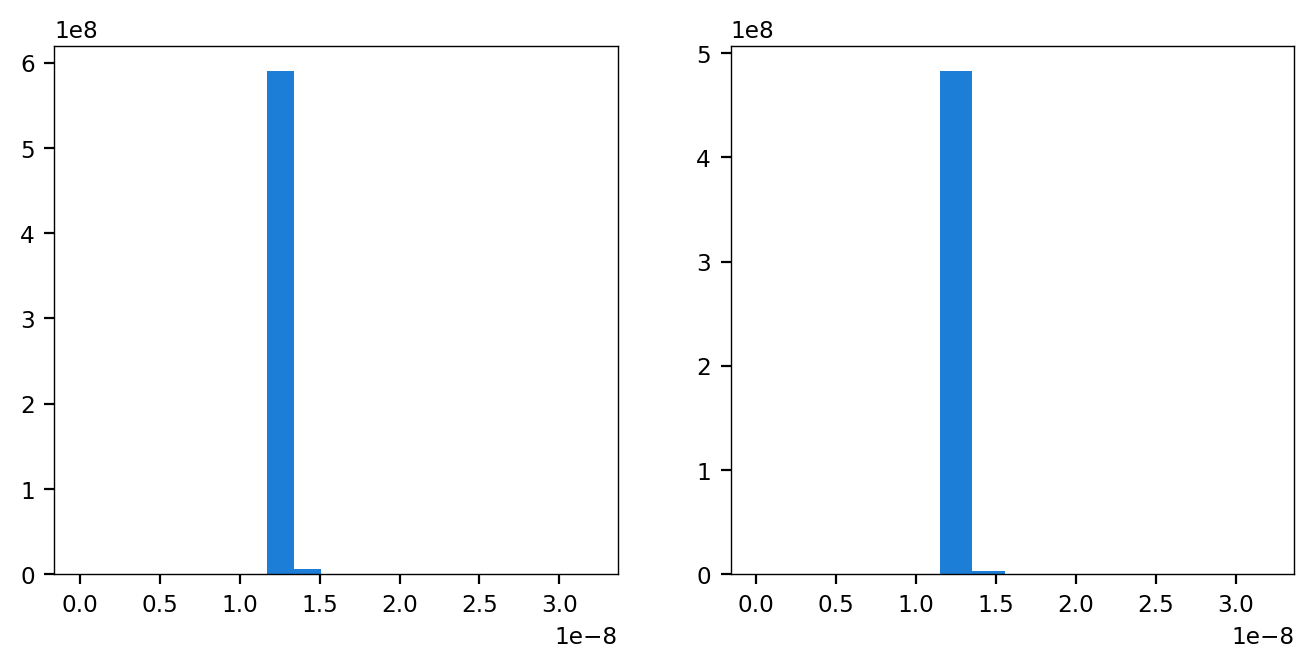

In [836]:
a  = pd.read_table('../data/phylo/old/ratchet_rescaled_data_cds.bed', names='chrom start end feature R r_rs n load'.split(' '), na_values='.')
b = pd.read_table('../data/phylo/rescaled_ratchet_data_cds.bed', names='chrom start end feature R r_rs n load'.split(' '), na_values='.')

fig, ax = plt.subplots(ncols=2, sharex=True)
ax[0].hist((a['r_rs']), density=True)
ax[1].hist((b['r_rs']), density=True)

In [838]:
a.shape, b.shape

((178417, 8), (178417, 8))

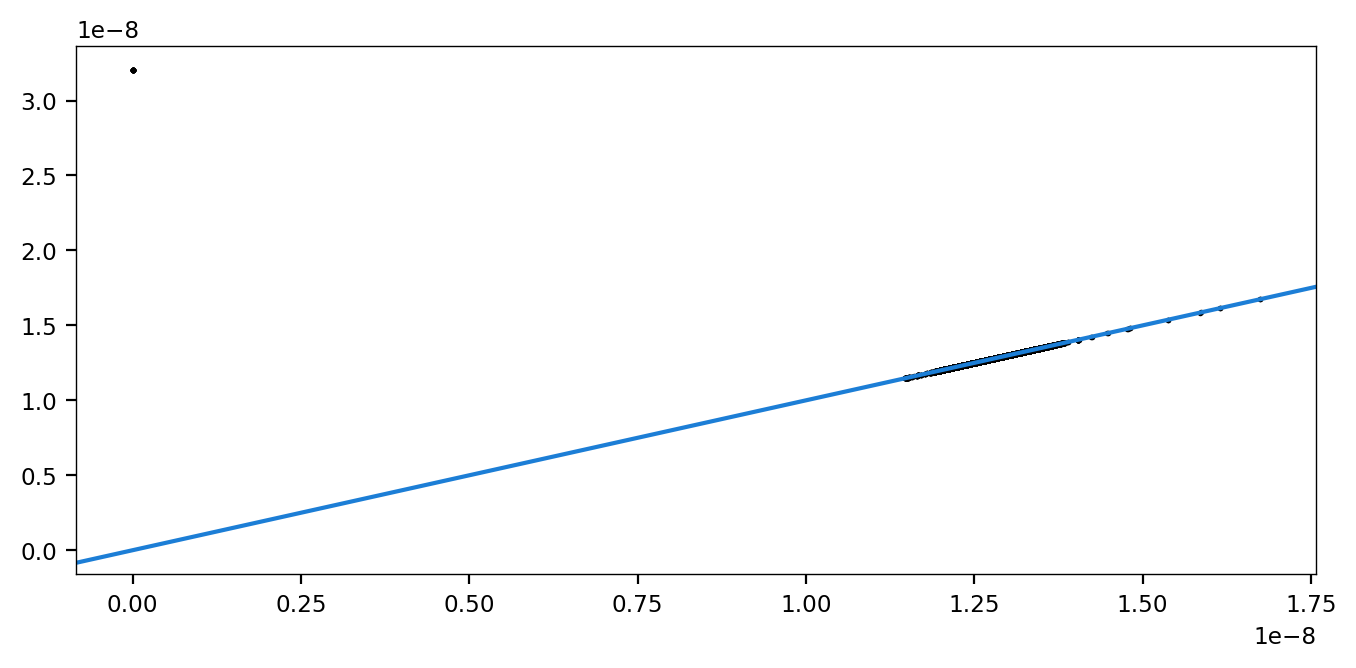

In [837]:
uu = pd.merge(a, b, on=['chrom', 'start', 'end'])
plt.scatter(uu['r_rs_x'], uu['r_rs_y'], s=1, c='k', alpha=1)
plt.axline((0, 0), slope=1)
#plt.loglog()
#plt.ylim(0.5e-8, 2e-8)
#plt.xlim(1e-8,1.52e-8)

In [801]:
dd = pd.read_table('../data/phylo/please.bed', names='chrom start end gene_id subrate n r_rs'.split(' '), na_values='.')
dd2 = pd.read_table('../data/phylo/please2.bed', names='chrom start end gene_id subrate n r_rs'.split(' '), na_values='.')

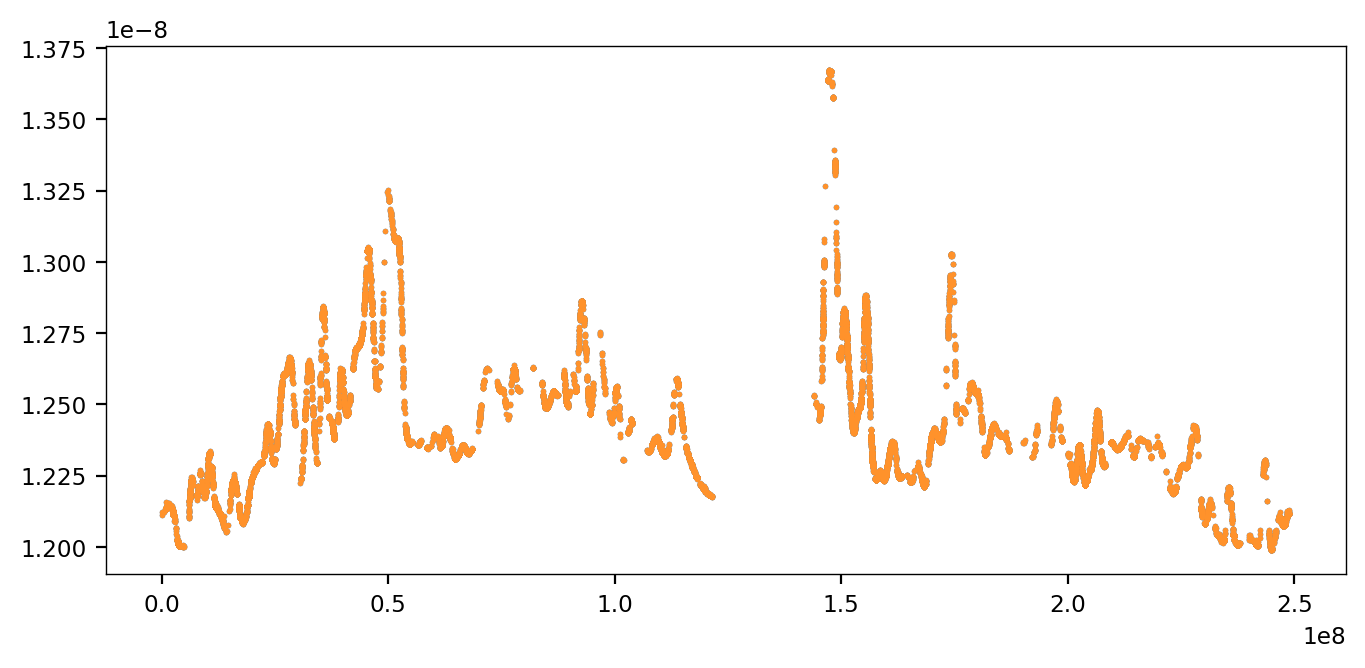

In [835]:
ax = a.loc[a['chrom'] == 'chr1']
plt.scatter(ax['start'], ax['r_rs'], s=1)

bx = b.loc[b['chrom'] == 'chr1']
plt.scatter(bx['start'], bx['r_rs'], s=1)

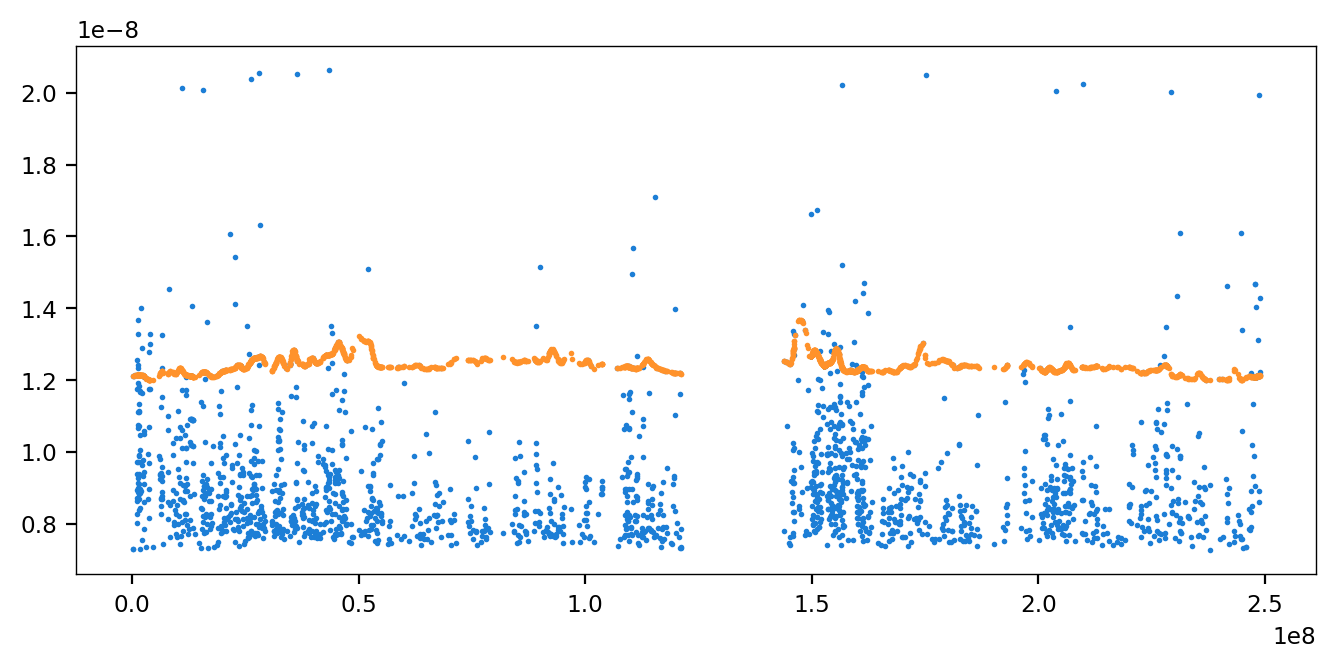

In [834]:
dx = dd.loc[dd['chrom'] == 'chr1']
plt.scatter(dx['start'], dx['r_rs'], s=1)

dx = dd2.loc[dd2['chrom'] == 'chr1']
plt.scatter(dx['start'], dx['r_rs'], s=1)

(<Figure size 1600x700 with 1 Axes>, <AxesSubplot: >)

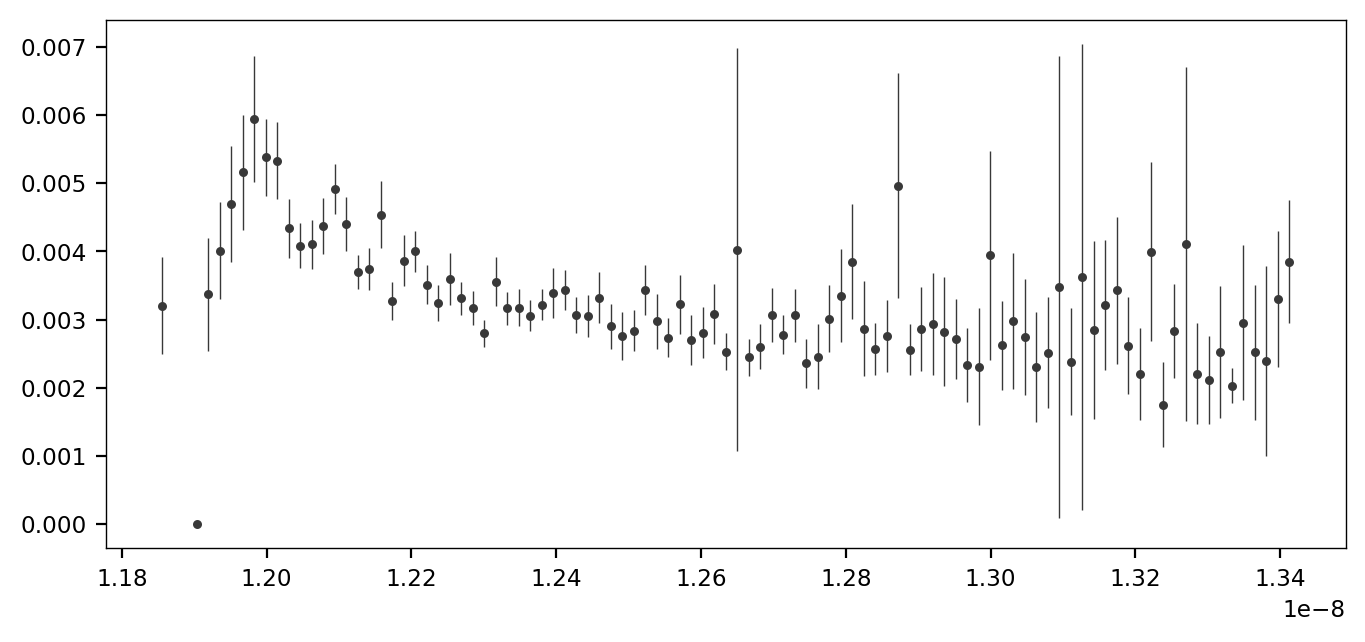

In [802]:
binned_means_plot(binned_summaries(dd2['r_rs'], dd2['subrate'], 100, cut_tails=(1e-3, 0.99)))

(<Figure size 1600x700 with 1 Axes>, <AxesSubplot: >)

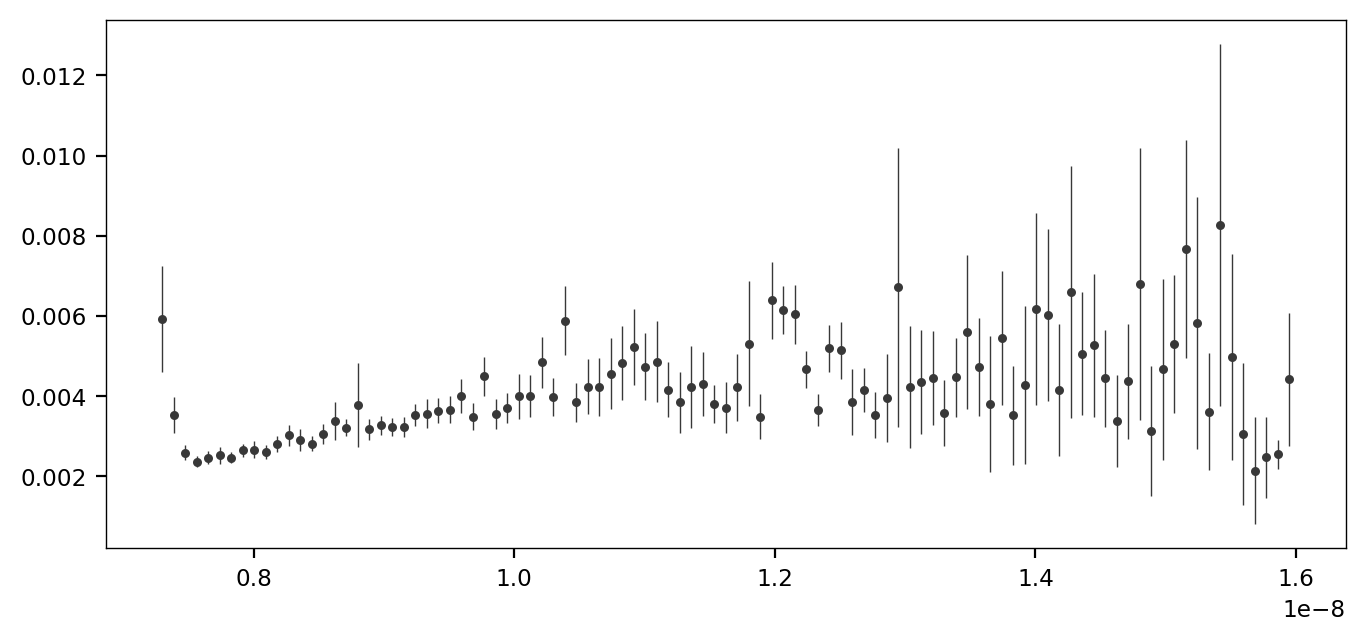

In [803]:
binned_means_plot(binned_summaries(dd['r_rs'], dd['subrate'], 100, cut_tails=(1e-3, 0.99)))

(array([4.82748593e+08, 3.07845681e+06, 7.76081550e+04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.76081550e+04]),
 array([1.14785371e-08, 1.35362253e-08, 1.55939136e-08, 1.76516018e-08,
        1.97092901e-08, 2.17669783e-08, 2.38246666e-08, 2.58823548e-08,
        2.79400431e-08, 2.99977313e-08, 3.20554196e-08]),
 <BarContainer object of 10 artists>)

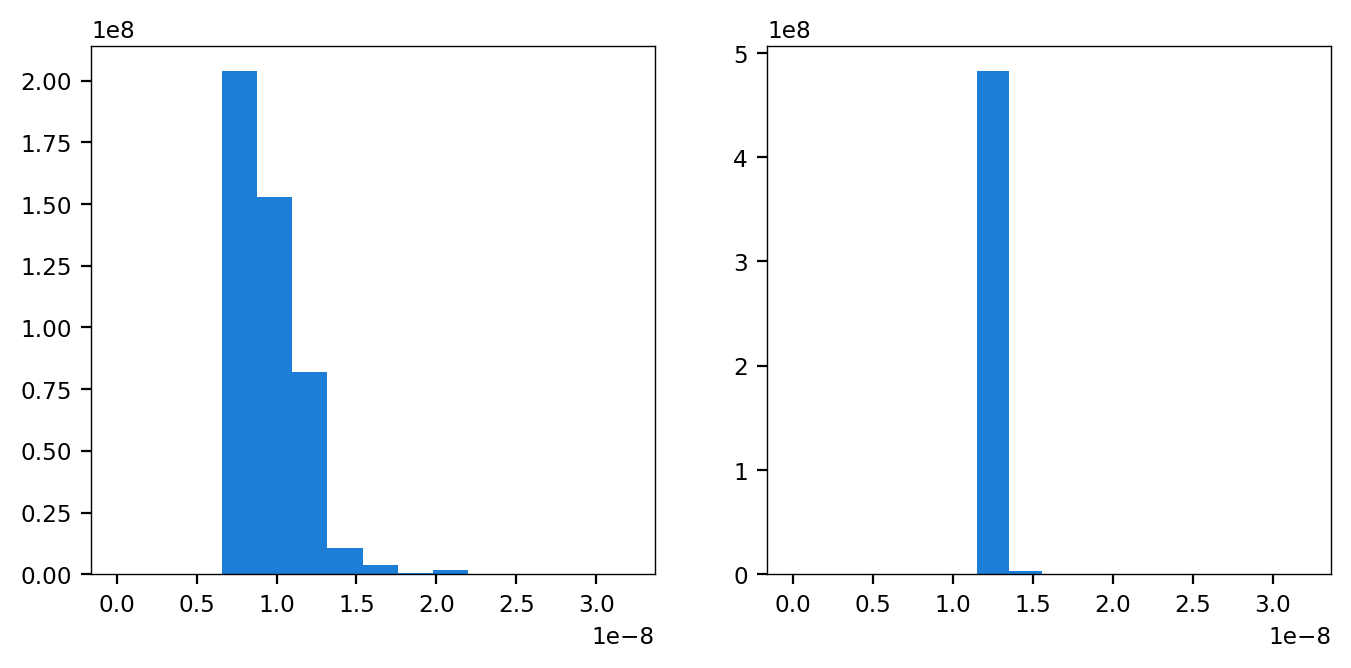

In [812]:
fig, ax = plt.subplots(ncols=2, sharex=True)
ax[0].hist((dd['r_rs']), density=True)
ax[1].hist((dd2['r_rs']), density=True)

(1e-08, 1.52e-08)

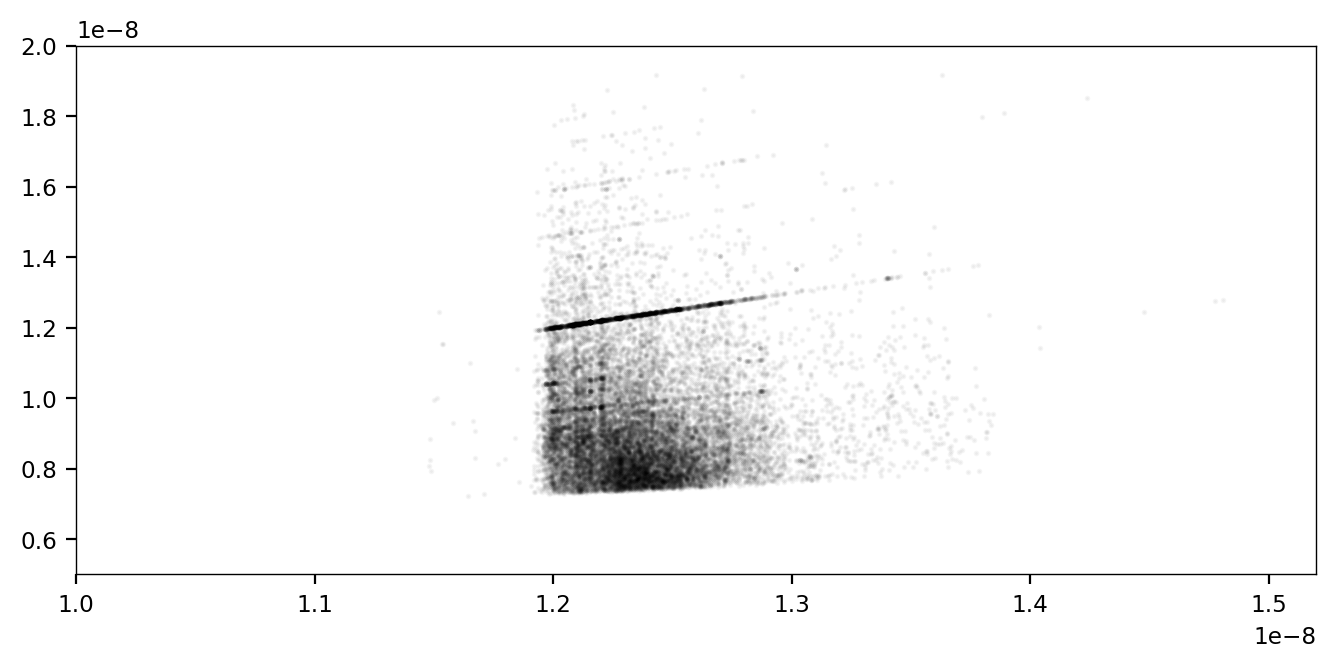

In [823]:
uu = pd.merge(dd2, dd, on=['chrom', 'start', 'end'])
plt.scatter(uu['r_rs_x'], uu['r_rs_y'], s=1, c='k', alpha=0.04)
#plt.loglog()
plt.ylim(0.5e-8, 2e-8)
plt.xlim(1e-8,1.52e-8)

In [824]:
dd

chrom      start        end          gene_id   subrate     n  \
0      chr1      69091      70008  ENSG00000186092  0.006558   918   
1      chr1     182709     184158         uc057auo  0.000302   404   
2      chr1     185217     195411         uc057auq  0.004031  1405   
3      chr1     450740     451678  ENSG00000284733  0.002883   939   
4      chr1     685716     686654  ENSG00000284662  0.002883   939   
...     ...        ...        ...              ...       ...   ...   
19233  chr9  137582543  137590263  ENSG00000165724  0.004407   689   
19234  chr9  137605718  137615138  ENSG00000197070  0.005423  1309   
19235  chr9  137619029  137834953  ENSG00000181090  0.002497  3923   
19236  chr9  137877934  138121999  ENSG00000148408  0.002555  7066   
19237  chr9  138286275  138294420         uc064xof  0.010760   218   

               r_rs  
0      1.212344e-08  
1      7.290779e-09  
2      7.290778e-09  
3      1.212278e-08  
4      1.213249e-08  
...             ...  
19233  8.620071e-09  
19234  9.544992e-09  
19235  1.101771e-08  
19236  8.039253e-09  
19237  7.299362e-09  

[19238 rows x 7 columns]

In [810]:
ix = np.array([1.00000000e-11, 6.30957344e-11, 3.98107171e-10, 2.51188643e-09,
       1.58489319e-08, 1.00000000e-07])
iy = np.array([9.98340554e-12, 6.29910305e-11, 3.97446533e-10, 2.50771809e-09,
       1.58226315e-08, 9.98340554e-08])

In [811]:
interp1d(ix, iy)(6.259241714010282e-10)

array(6.24885483e-10)

(array([9.2000e+01, 1.0302e+04, 5.0280e+03, 5.9700e+02, 1.9200e+02,
        9.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.38274203, 0.39828794, 0.41383385, 0.42937976, 0.44492567,
        0.46047158, 0.47601749, 0.4915634 , 0.50710931, 0.52265522,
        0.53820114]),
 <BarContainer object of 10 artists>)

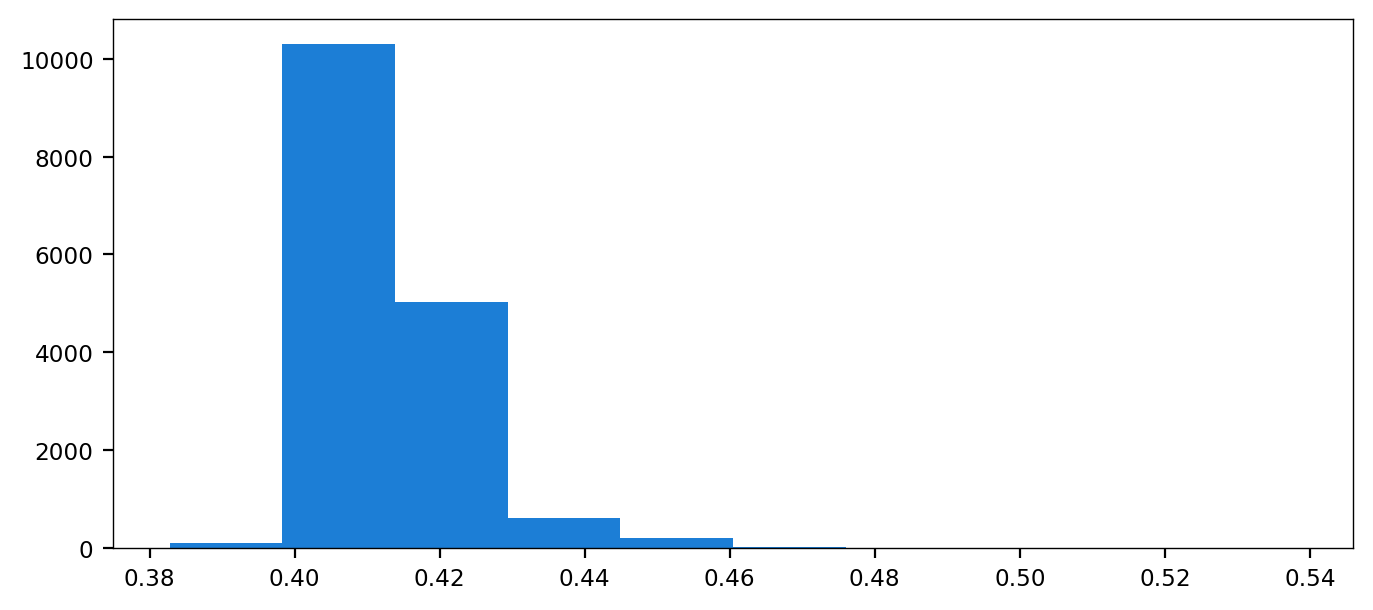

In [766]:
plt.hist(da['r_rs']/3e-8)

(<Figure size 1600x700 with 1 Axes>, <AxesSubplot: >)

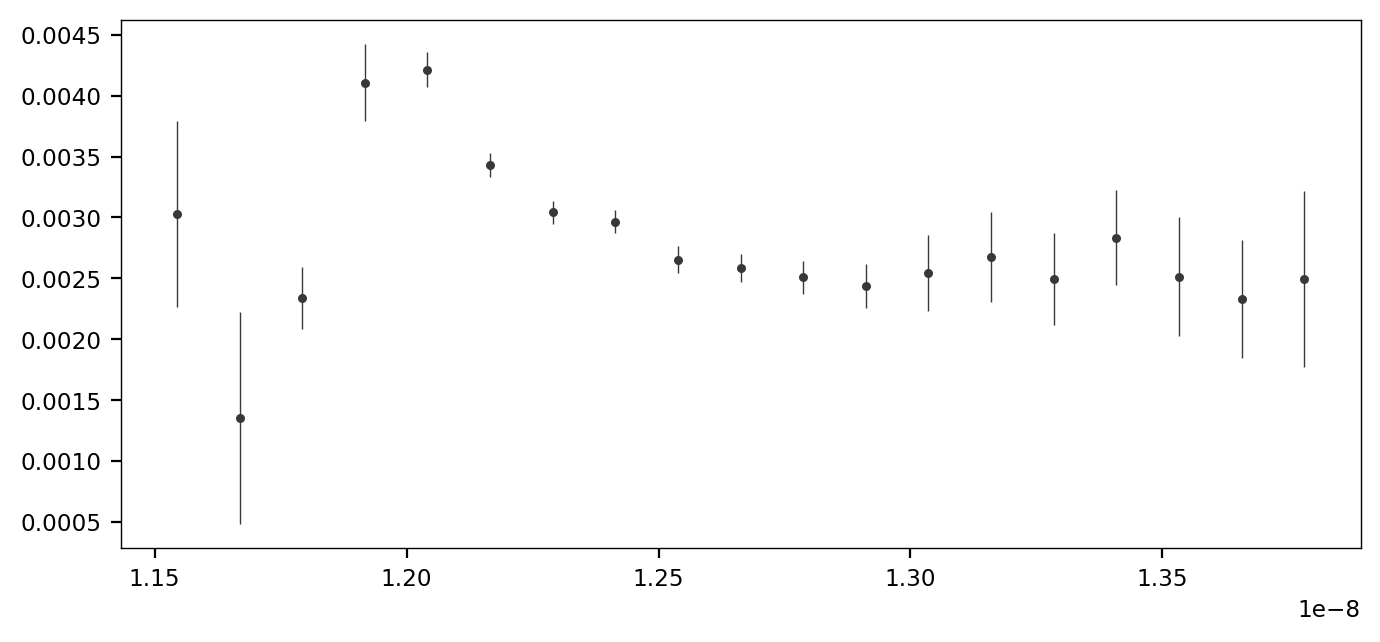

In [764]:
ff = pd.merge(dpf, da, on='gene_id')
figax = plt.subplots()
binned_means_plot(binned_summaries(ff['r_rs'], ff['pf_subrate_x'], 20, cut_tails=(0, 0.9999)), figax=figax)
#binned_means_plot(binned_summaries(ff['r_rs'], ff['pf_subrate'], 20, cut_tails=(0, 0.9999)), figax=figax, c='r')

In [732]:
xxx, yyy = ff['r_rs'], ff['pf_subrate']
keep = np.isfinite(xxx) & np.isfinite(yyy)
xxx, yyy = xxx[keep], yyy[keep]
stats.linregress(xxx, yyy)

LinregressResult(slope=53232251.11076661, intercept=-0.6263355872821594, rvalue=0.056115035485633034, pvalue=1.734613763570037e-12, stderr=7539993.978930851, intercept_stderr=0.08916651721996117)

In [580]:
do

chrom      start        end          gene_id  n_nonsyn  n_syn  \
0      chr1     923923     944575  ENSG00000187634        28     21   
1      chr1     944203     959309  ENSG00000188976        31     32   
2      chr1     960584     965719  ENSG00000187961        11     28   
3      chr1     966482     975865  ENSG00000187583        47     19   
4      chr1     975198     982117  ENSG00000187642        31     22   
...     ...        ...        ...              ...       ...    ...   
16311  chr9  137554444  137578925  ENSG00000148399        11      7   
16312  chr9  137582081  137590512  ENSG00000165724         3      2   
16313  chr9  137605685  137615360  ENSG00000197070        12     11   
16314  chr9  137618992  137870016  ENSG00000181090        18     27   
16315  chr9  137877782  138124624  ENSG00000148408        28     41   

       fixed_nonsyn  fixed_syn      dnDs  total_fixed  ...          r_rs  \
0                 8          4  2.000000           12  ...  8.610962e-09   
1                 4          8  0.500000           12  ...  9.234576e-09   
2                 0          8  0.000000            8  ...  1.012162e-08   
3                 0          3  0.000000            3  ...  9.110700e-09   
4                11          3  3.666667           14  ...  1.038721e-08   
...             ...        ...       ...          ...  ...           ...   
16311             2          2  1.000000            4  ...  9.406762e-09   
16312             0          2  0.000000            2  ...  9.390737e-09   
16313             5          2  2.500000            7  ...  1.034954e-08   
16314             2          4  0.500000            6  ...  1.107923e-08   
16315             3         12  0.250000           15  ...  8.324066e-09   

       r_rs_nbases  branch_length  bl_nbases   width     midpoint         B  \
0             4658       0.009005    96703.0   20652     934249.0  0.705373   
1             2950       0.009129    55542.0   15106     951756.0  0.703260   
2             2776       0.009129    55542.0    5135     963151.5  0.701900   
3             3800       0.009129    55542.0    9383     971173.5  0.700950   
4             4203            NaN        NaN    6919     978657.5  0.700069   
...            ...            ...        ...     ...          ...       ...   
16311         2452       0.008632  1000000.0   24481  137566684.5  0.755153   
16312         1483       0.008632  1000000.0    8431  137586296.5  0.755153   
16313         2167       0.008632  1000000.0    9675  137610522.5  0.755153   
16314        22280       0.008060  1271165.0  251024  137744504.0  0.755153   
16315        15596       0.006690   459642.0  246842  138001203.0  0.755153   

             r_year     r_rs_year                  bins  
0      4.045149e-10  2.870321e-10  (2.85e-10, 2.88e-10]  
1      4.044999e-10  3.078192e-10   (3.07e-10, 3.1e-10]  
2      4.045287e-10  3.373875e-10  (3.35e-10, 3.39e-10]  
3      4.045299e-10  3.036900e-10  (3.01e-10, 3.04e-10]  
4      4.047587e-10  3.462403e-10  (3.44e-10, 3.49e-10]  
...             ...           ...                   ...  
16311  4.047433e-10  3.135587e-10  (3.13e-10, 3.16e-10]  
16312  4.047349e-10  3.130246e-10  (3.13e-10, 3.16e-10]  
16313  4.047634e-10  3.449845e-10  (3.44e-10, 3.49e-10]  
16314  4.047137e-10  3.693077e-10  (3.65e-10, 3.72e-10]  
16315  4.047415e-10  2.774689e-10  (2.76e-10, 2.78e-10]  

[16316 rows x 32 columns]

In [701]:
d = pd.read_csv('../data/phylo/uricchio_data_merged.tsv', sep='\t', na_values='.')

In [702]:
d.head()

chrom   start     end          gene_id  n_nonsyn  n_syn  fixed_nonsyn  \
0  chr1  923923  944575  ENSG00000187634        28     21             8   
1  chr1  944203  959309  ENSG00000188976        31     32             4   
2  chr1  960584  965719  ENSG00000187961        11     28             0   
3  chr1  966482  975865  ENSG00000187583        47     19             0   
4  chr1  975198  982117  ENSG00000187642        31     22            11   

   fixed_syn      dnds  total_fixed  ...           S            N  \
0          4  2.000000           12  ...  677.333333  1854.666667   
1          8  0.500000           12  ...  524.666667  1722.333333   
2          8  0.000000            8  ...  484.000000  1442.000000   
3          3  0.000000            3  ...  473.666667  1359.333333   
4          3  3.666667           14  ...  626.000000  1744.000000   

           r_rs  r_rs_nbases          r_us  r_us_nbases  pf_subrate  \
0  1.213545e-08       2653.0  1.182606e-08       2653.0    0.007336   
1  1.213500e-08       2231.0  1.182483e-08       2231.0    0.007094   
2  1.213586e-08       1548.0  1.182549e-08       1548.0    0.006425   
3  1.213590e-08       1977.0  1.182515e-08       1977.0    0.004622   
4  1.214276e-08       2370.0  1.183362e-08       2370.0    0.013330   

   pf_nbases  width  midpoint  
0     2058.0  20652  934249.0  
1     2268.0  15106  951756.0  
2     1940.0   5135  963151.5  
3     1851.0   9383  971173.5  
4     2375.0   6919  978657.5  

[5 rows x 28 columns]

In [703]:
dpf = pd.read_table('../data/phylo/phylofit_cds_rates.bed', names=('chrom', 'start', 'end', 'gene_id', 'pf_subrate', 'pf_nbases'))
dpf

chrom      start        end          gene_id  pf_subrate  pf_nbases
0      chr1      69091      70008  ENSG00000186092    0.006558        918
1      chr1     182709     184158         uc057auo    0.000302        404
2      chr1     185217     195411         uc057auq    0.004031       1405
3      chr1     450740     451678  ENSG00000284733    0.002883        939
4      chr1     685716     686654  ENSG00000284662    0.002883        939
...     ...        ...        ...              ...         ...        ...
19233  chr9  137582543  137590263  ENSG00000165724    0.004407        689
19234  chr9  137605718  137615138  ENSG00000197070    0.005423       1309
19235  chr9  137619029  137834953  ENSG00000181090    0.002497       3923
19236  chr9  137877934  138121999  ENSG00000148408    0.002555       7066
19237  chr9  138286275  138294420         uc064xof    0.010760        218

[19238 rows x 6 columns]

In [704]:
dpf['gene_id']

0        ENSG00000186092
1               uc057auo
2               uc057auq
3        ENSG00000284733
4        ENSG00000284662
              ...       
19233    ENSG00000165724
19234    ENSG00000197070
19235    ENSG00000181090
19236    ENSG00000148408
19237           uc064xof
Name: gene_id, Length: 19238, dtype: object

In [705]:
dd = pd.merge(d, dpf, on='gene_id')
dd.head()

chrom_x  start_x   end_x          gene_id  n_nonsyn  n_syn  fixed_nonsyn  \
0    chr1   923923  944575  ENSG00000187634        28     21             8   
1    chr1   944203  959309  ENSG00000188976        31     32             4   
2    chr1   960584  965719  ENSG00000187961        11     28             0   
3    chr1   966482  975865  ENSG00000187583        47     19             0   
4    chr1   975198  982117  ENSG00000187642        31     22            11   

   fixed_syn      dnds  total_fixed  ...  r_us_nbases  pf_subrate_x  \
0          4  2.000000           12  ...       2653.0      0.007336   
1          8  0.500000           12  ...       2231.0      0.007094   
2          8  0.000000            8  ...       1548.0      0.006425   
3          3  0.000000            3  ...       1977.0      0.004622   
4          3  3.666667           14  ...       2370.0      0.013330   

   pf_nbases_x  width  midpoint  chrom_y  start_y   end_y  pf_subrate_y  \
0       2058.0  20652  934249.0     chr1   925942  944153      0.007336   
1       2268.0  15106  951756.0     chr1   944694  959240      0.007094   
2       1940.0   5135  963151.5     chr1   960694  965191      0.006425   
3       1851.0   9383  971173.5     chr1   966532  974575      0.004622   
4       2375.0   6919  978657.5     chr1   976172  981029      0.013330   

   pf_nbases_y  
0         2058  
1         2268  
2         1940  
3         1851  
4         2375  

[5 rows x 33 columns]

(<Figure size 1600x700 with 1 Axes>, <AxesSubplot: >)

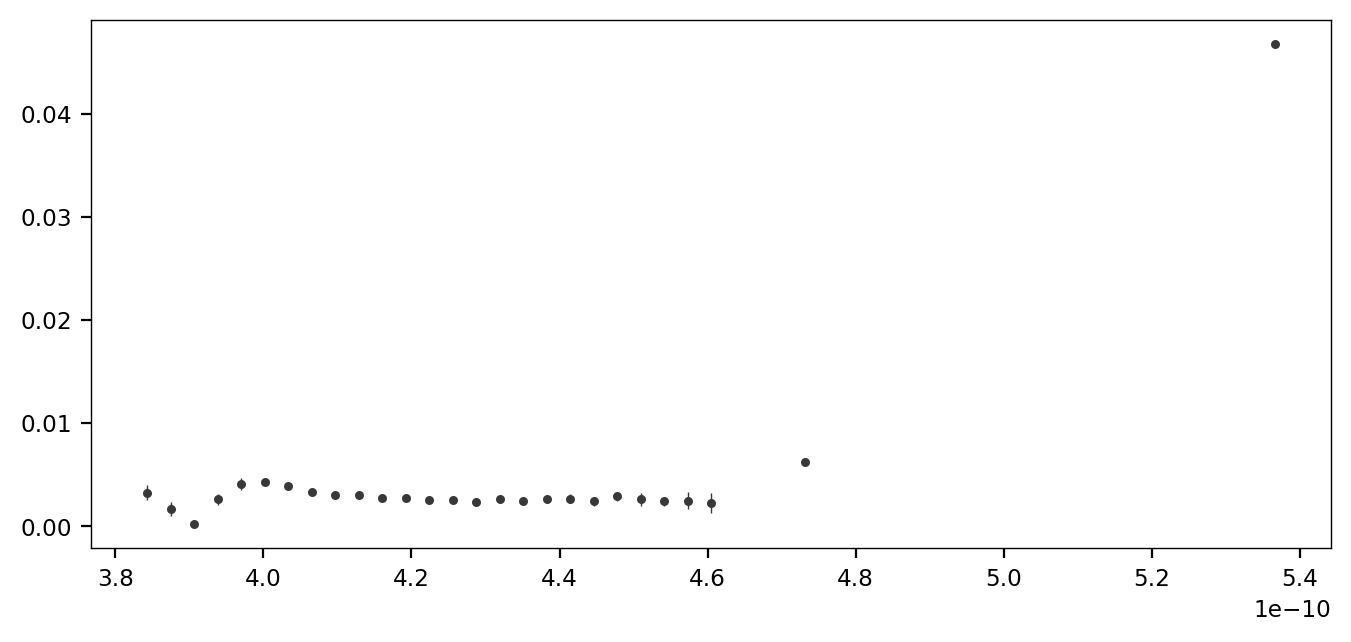

In [708]:
binned_means_plot(binned_summaries(dd['r_rs']/30, dd['pf_subrate_y'], 50))

(array([1.700e+01, 7.467e+03, 7.035e+03, 1.362e+03, 2.830e+02, 5.500e+01,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-7.93997259, -7.92516875, -7.9103649 , -7.89556106, -7.88075721,
        -7.86595336, -7.85114952, -7.83634567, -7.82154183, -7.80673798,
        -7.79193414]),
 <BarContainer object of 10 artists>)

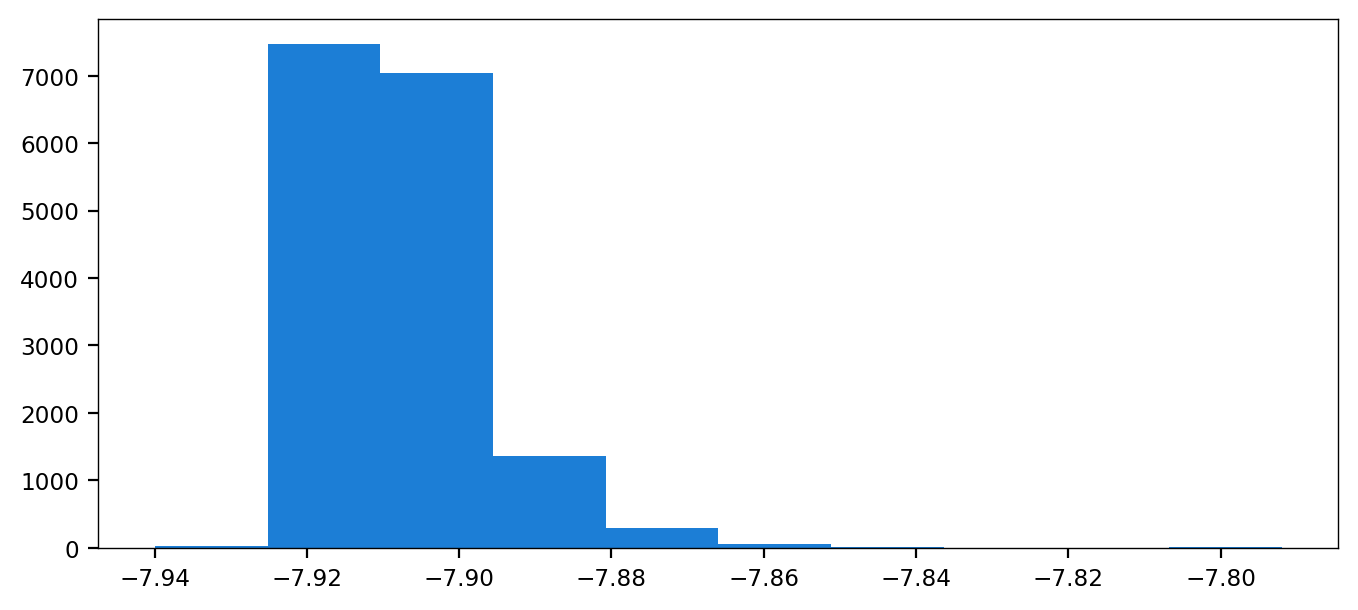

In [709]:
plt.hist(np.log10(d['r_rs']))

(array([3341., 4144., 3275., 2277., 1496.,  817.,  512.,  338.,   89.,
          27.]),
 array([-8.13608238, -8.08829199, -8.04050159, -7.9927112 , -7.9449208 ,
        -7.89713041, -7.84934001, -7.80154962, -7.75375923, -7.70596883,
        -7.65817844]),
 <BarContainer object of 10 artists>)

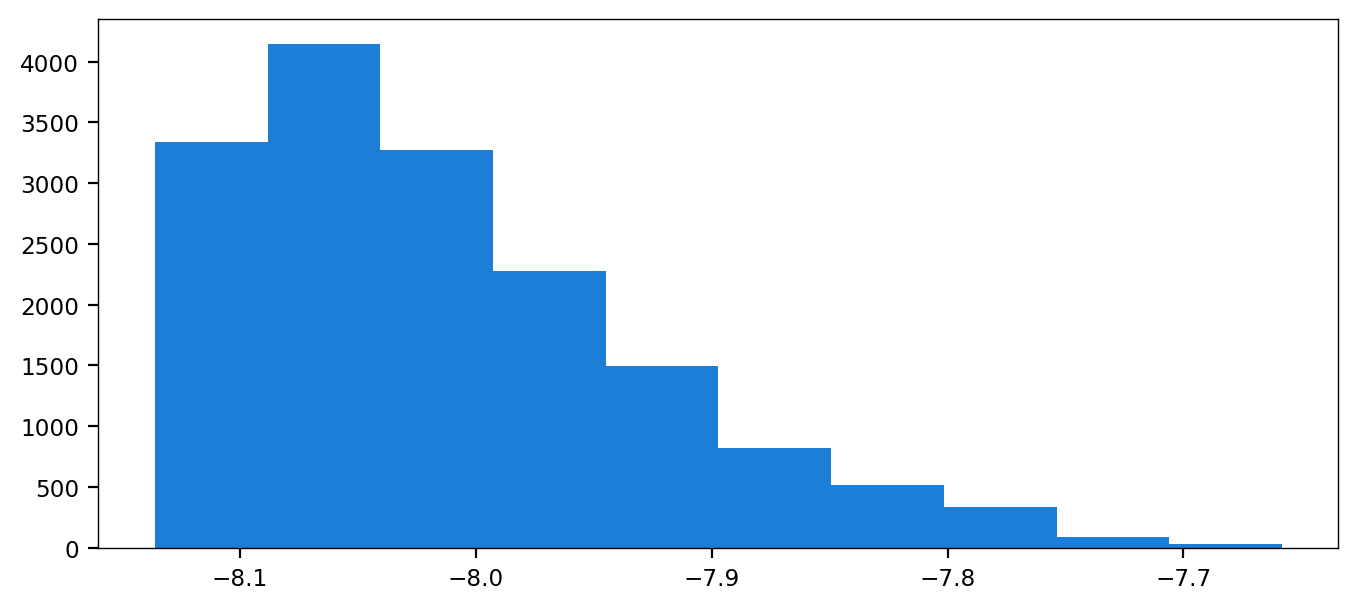

In [710]:
plt.hist(np.log10(do['r_rs']))

In [647]:
corr(d['r_rs']/30, d['pf_subrate'])

((0.053711500929630125, 7.842190338218134e-12),
 SpearmanrResult(correlation=0.06562811486001734, pvalue=6.15386289386832e-17))

(<Figure size 1600x700 with 1 Axes>, <AxesSubplot: >)

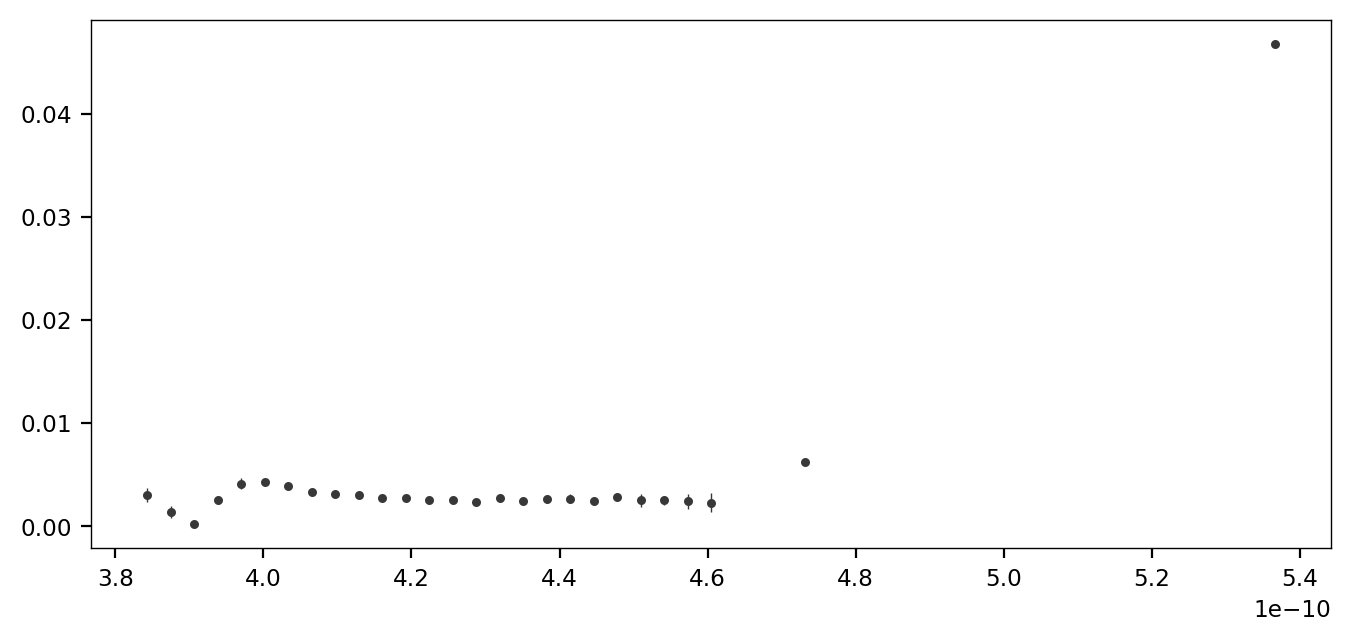

In [716]:
binned_means_plot(binned_summaries(d['r_rs']/30, d['pf_subrate'], 50))

In [652]:
a = pd.read_table('../data/phylo/old/ratchet_data_cds.bed', names=('chrom', 'start', 'end', 'feature', 'Ra', 'ra', 'na', 'la'))
b = pd.read_table('../data/phylo/rescaled_ratchet_data_cds.bed', names=('chrom', 'start', 'end', 'feature', 'Rb', 'rb', 'nb', 'lb'))

In [653]:
dd = pd.merge(a, b, left_on=['chrom', 'start', 'end'], right_on=['chrom', 'start', 'end'])

In [654]:
dd.head()

chrom   start     end feature_x            Ra            ra   na  \
0  chr1   65565   65573       cds  9.458620e-08  1.182328e-08    8   
1  chr1   69037   70008       cds  1.149277e-05  1.183601e-08  971   
2  chr1  450740  451678       cds  1.110131e-05  1.183508e-08  938   
3  chr1  685716  686654       cds  1.110145e-05  1.183524e-08  938   
4  chr1  924432  924948       cds  6.104379e-06  1.183019e-08  516   

             la feature_y            Rb            rb   nb            lb  
0 -1.115196e-12       cds  1.007548e-07  1.259435e-08    8 -2.669570e-13  
1 -1.366266e-10       cds  1.222916e-05  1.259439e-08  971 -3.240281e-11  
2 -1.319047e-10       cds  1.181354e-05  1.259439e-08  938 -3.130151e-11  
3 -1.319160e-10       cds  1.181523e-05  1.259619e-08  938 -3.132040e-11  
4 -7.229241e-11       cds  6.500567e-06  1.259800e-08  516 -1.723997e-11

[]

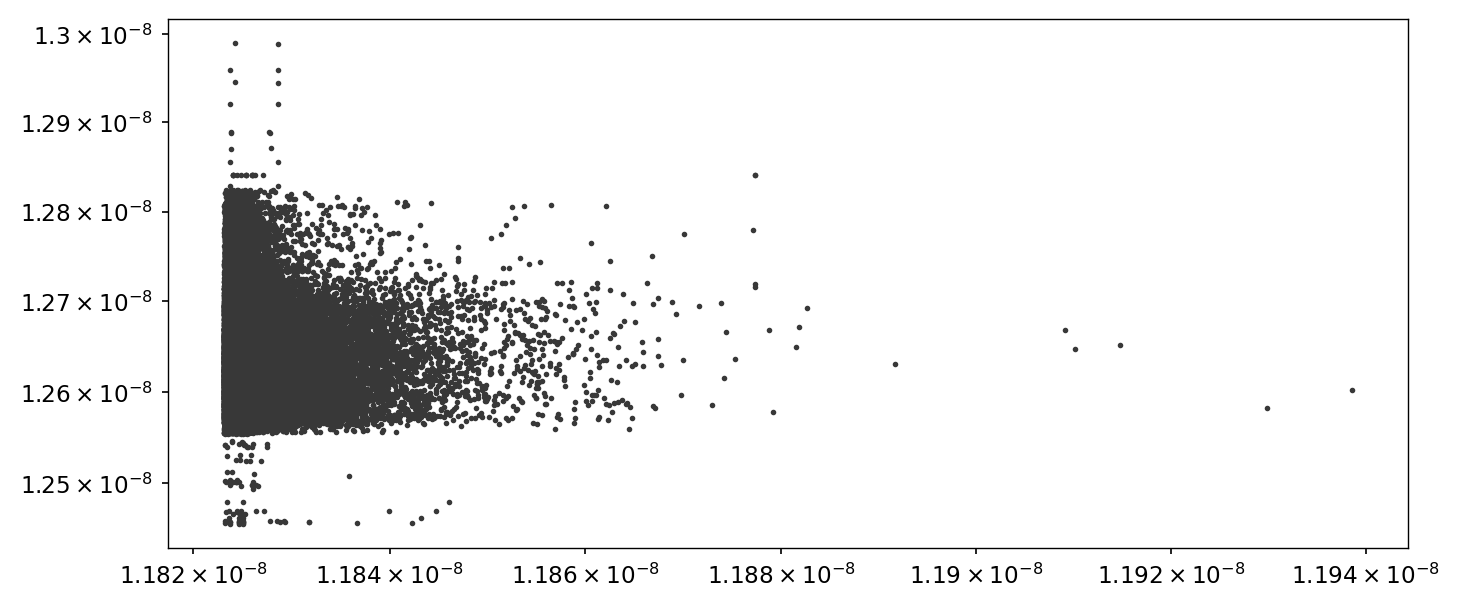

In [655]:
plt.scatter(dd['ra'], dd['rb'], c='0.22', s=1)
plt.loglog()

In [635]:
b.head()

chr1   65565   65573  cds  9.690641446455992e-08  1.211330180806999e-08  \
0  chr1   69037   70008  cds           1.177186e-05           1.212344e-08   
1  chr1  450740  451678  cds           1.137116e-05           1.212278e-08   
2  chr1  685716  686654  cds           1.138028e-05           1.213249e-08   
3  chr1  924432  924948  cds           6.263342e-06           1.213826e-08   
4  chr1  925941  926013  cds           8.736224e-07           1.213364e-08   

     8  -1.2732132757954249e-12  
0  971            -1.558763e-10  
1  938            -1.504999e-10  
2  938            -1.512040e-10  
3  516            -8.327834e-11  
4   72            -1.157427e-11

In [609]:
corr(d['total_prop'], d['pf_subrate'])

((0.5742642678938091, 0.0),
 SpearmanrResult(correlation=0.7422253295271082, pvalue=0.0))

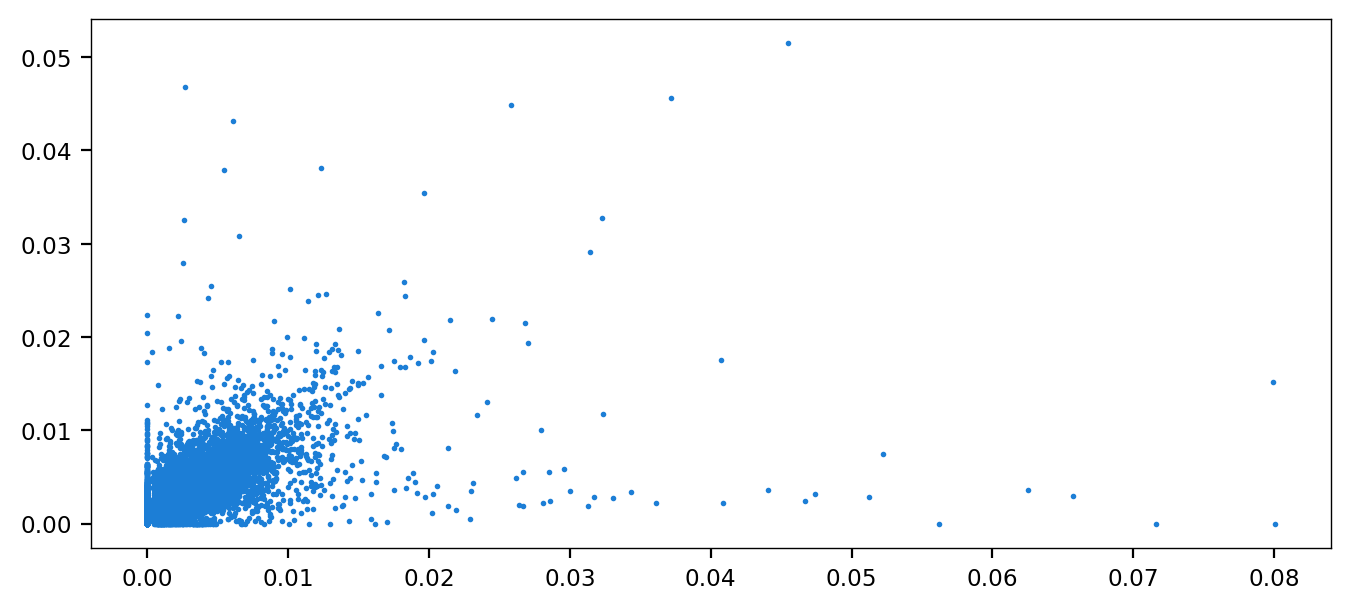

In [608]:
plt.scatter(d['total_prop'], d['pf_subrate'], s=1)

In [594]:
    new_cols = ['chrom',  'start', 'end', 'gene_id', 'n_nonsyn', 'n_syn',
                'fixed_nonsyn', 'fixed_syn', 'dnds',
                'total_fixed', 'len', 'cai', 'gc', 'gc3', 'syn_prop',
                'nonsyn_prop', 'total_prop', 'dNdS', 'S', 'N',

                'r_rs', 'r_rs_nbases',
                'r_us', 'r_us_nbases',
                'pf_subrate', 'pf_nbases',
                ]

In [563]:
len(new_cols)

26

In [564]:
d.shape

(16315, 26)

#### Join in B Predictions

Note — there are a few outlier B > 1 likely from interpolator error (TODO).

In [296]:
for chrom in d.chrom.unique():
    chrom_bs = bpfit_sm.predict_B_at_pos(chrom, d.loc[d['chrom'] == chrom, 'midpoint'])
    chrom_bs[chrom_bs > 1] = 1
    d.loc[d['chrom'] == chrom, 'B'] = chrom_bs

Some summary statistics on the lengths of genes, and number of bases used for estimates:

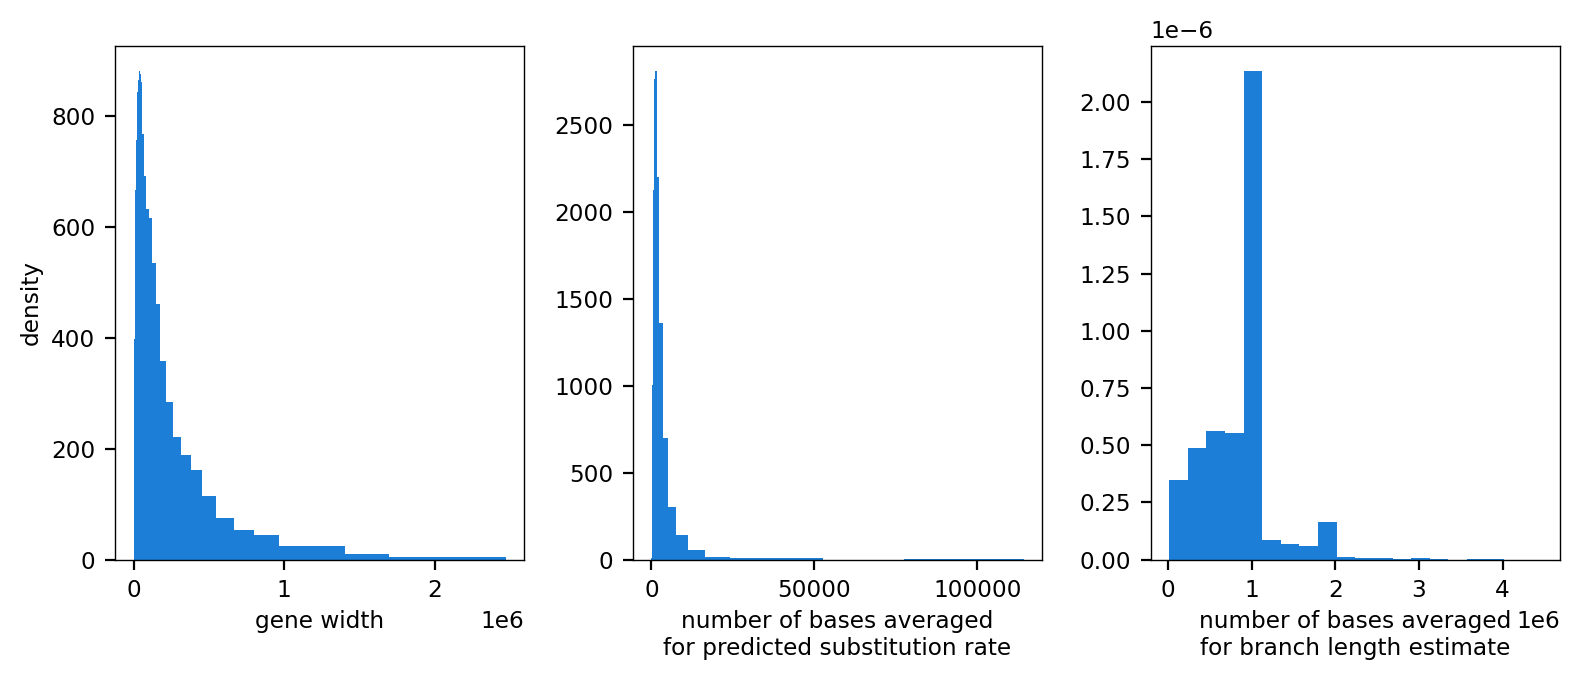

In [28]:
# width of genes, number of bases averaged for ratchet estimate, 
# number of bases averaged for 

fig, ax = plt.subplots(ncols=3)


ax[0].hist(*logbins(d['width'], 50, density=True))
ax[1].hist(*logbins(d['r_nbases'], 30, density=True))
_ = ax[2].hist(d['bl_nbases'], 20, density=True)
ax[0].set_ylabel('density')
ax[0].set_xlabel('gene width')
ax[1].set_xlabel('number of bases averaged\nfor predicted substitution rate')
ax[2].set_xlabel('number of bases averaged\nfor branch length estimate')
plt.tight_layout()

What's the correspondance between phylofit branch lengths and Uricchio's substitution proportions?

In [29]:
corr(d['branch_length'], d['total_prop'])

((0.1674625136298407, 4.4498990795268144e-85),
 SpearmanrResult(correlation=0.206790854125823, pvalue=1.1222011876070762e-129))

In [30]:
corr(d['branch_length'], d['syn_prop'])

((0.14806506559564211, 1.0246408682489994e-66),
 SpearmanrResult(correlation=0.1699826587436179, pvalue=1.2268769265975793e-87))

In [31]:
corr(d['branch_length'], d['nonsyn_prop'])

((0.12684957228228788, 2.6212014059155865e-49),
 SpearmanrResult(correlation=0.13419846333442986, pvalue=5.0316817080962134e-55))

There are correlated, but different. The estimates from phyloFit are **not** subset by feature, and are thus noiser because they mix features under different levels of constraint. The main analysis focuses just on the gene substitution rates from Uricchi et al.

#### Comparison Between PhyloFit and Substitutions from Uricchio et al.

Now let's look at the phyloFit branch length estimates.

Text(0.5, 0, 'predicted substitution rate')

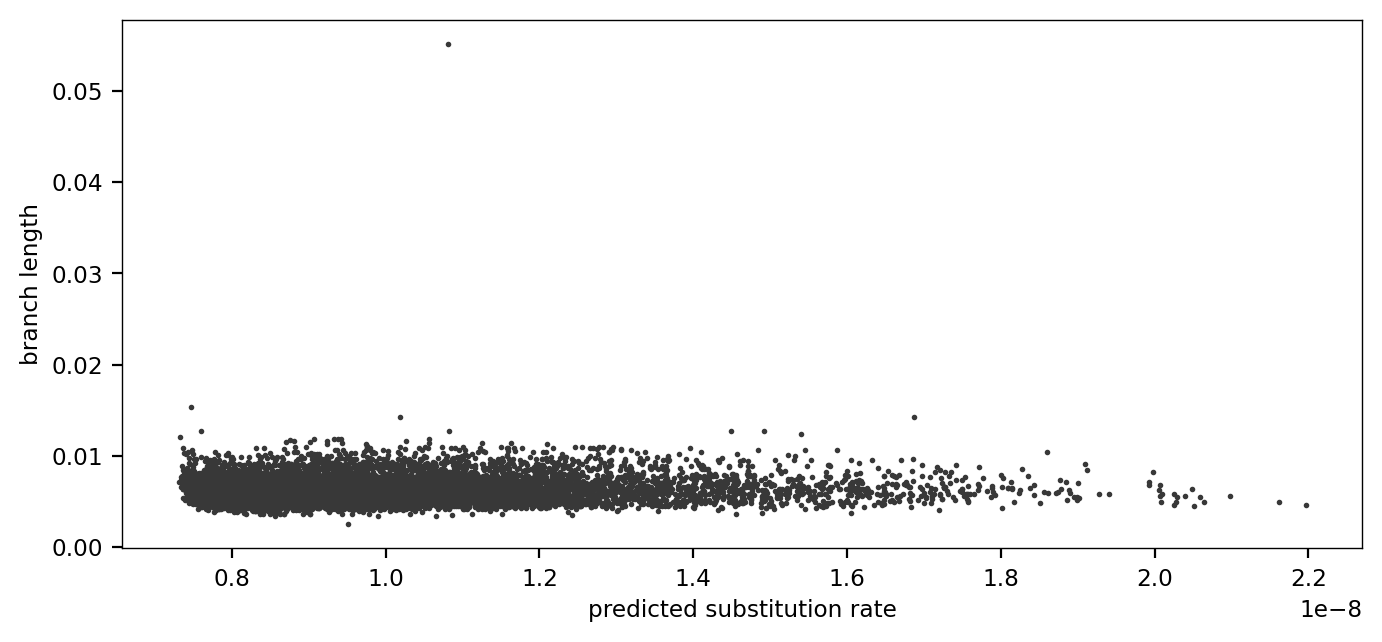

In [32]:
fig, ax = plt.subplots()
ax.scatter(d['r_rs'], d['branch_length'], c='0.22', s=1, alpha=1)
ax.set_ylabel('branch length')
ax.set_xlabel('predicted substitution rate')

One outlier, but the trend is interesting. Let's compare the trends between this and the total CDS substitution rate.

Note that the branch length estimates are **very approximate** — because the substitutions are not directly counted **in the region** but are estimated from the overlapping branch rates of all overlapping alignments (even those of different features).

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:665: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(np.array(bin_map[i]))
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(<Figure size 1600x700 with 1 Axes>, <AxesSubplot: >)

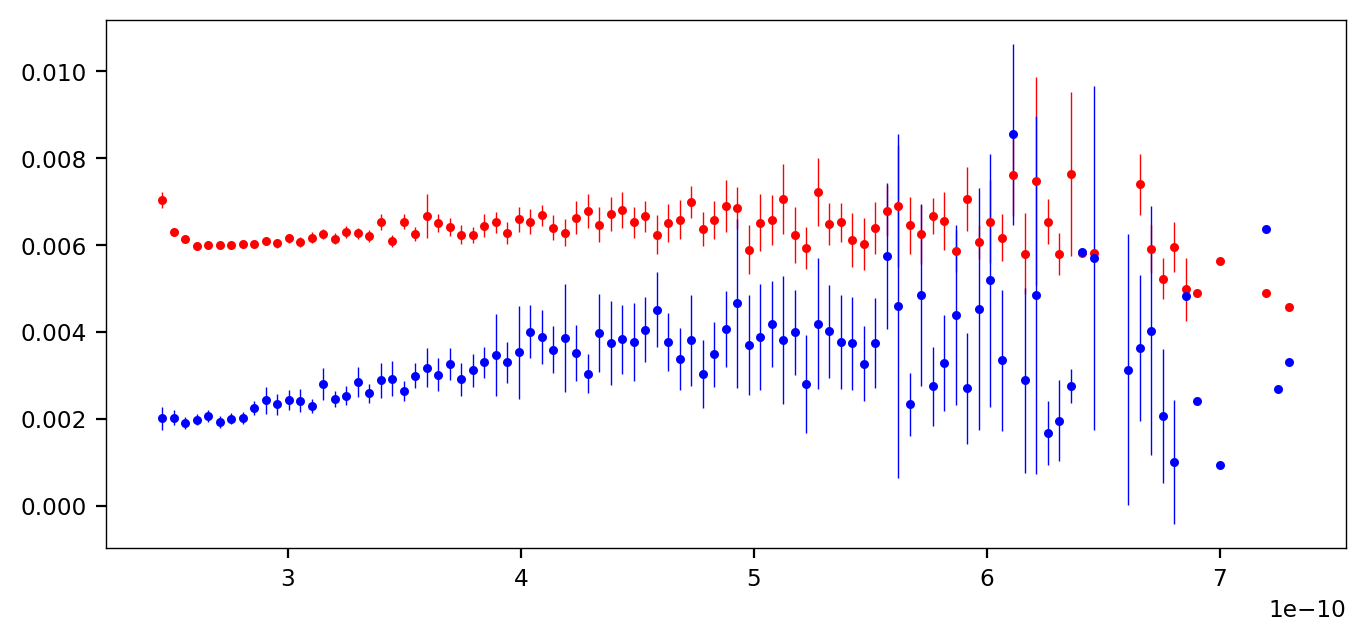

In [33]:
fig, ax = plt.subplots()
binned_means_plot(binned_summaries(d['r_rs']/30, d['branch_length'], 100), figax=(fig, ax), c='r')
binned_means_plot(binned_summaries(d['r_rs']/30, d['total_prop'], 100), figax=(fig, ax), c='b')

We see the same trend — higher predicted substitution rates, higher branch length estimates. The rates are higher due to more UTRs, introns, etc that also aligned.  Note the uptick — I've seen this a few times, and it could be that adaptive rates are higher when the substitution rates are lower (e.g. lower HRI). This will require further investigation though.

#### Outlier Filtering

There are a few extreme outliers we remove.

(array([6190., 4742., 2611., 1317.,  688.,  392.,  254.,   88.,   27.,
           7.]),
 array([7.31000408e-09, 8.77596070e-09, 1.02419173e-08, 1.17078739e-08,
        1.31738306e-08, 1.46397872e-08, 1.61057438e-08, 1.75717004e-08,
        1.90376570e-08, 2.05036137e-08, 2.19695703e-08]),
 <BarContainer object of 10 artists>)

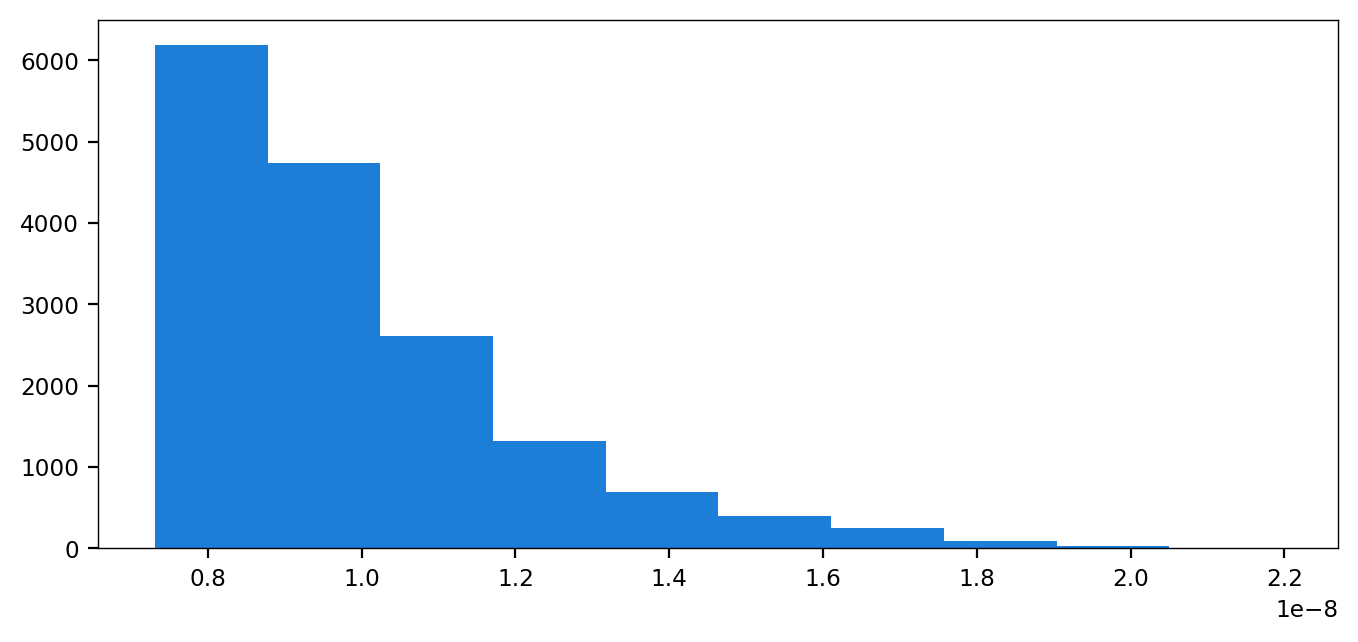

In [34]:
plt.hist(d['r_rs'])

Text(0.5, 0, 'predicted substitution rate')

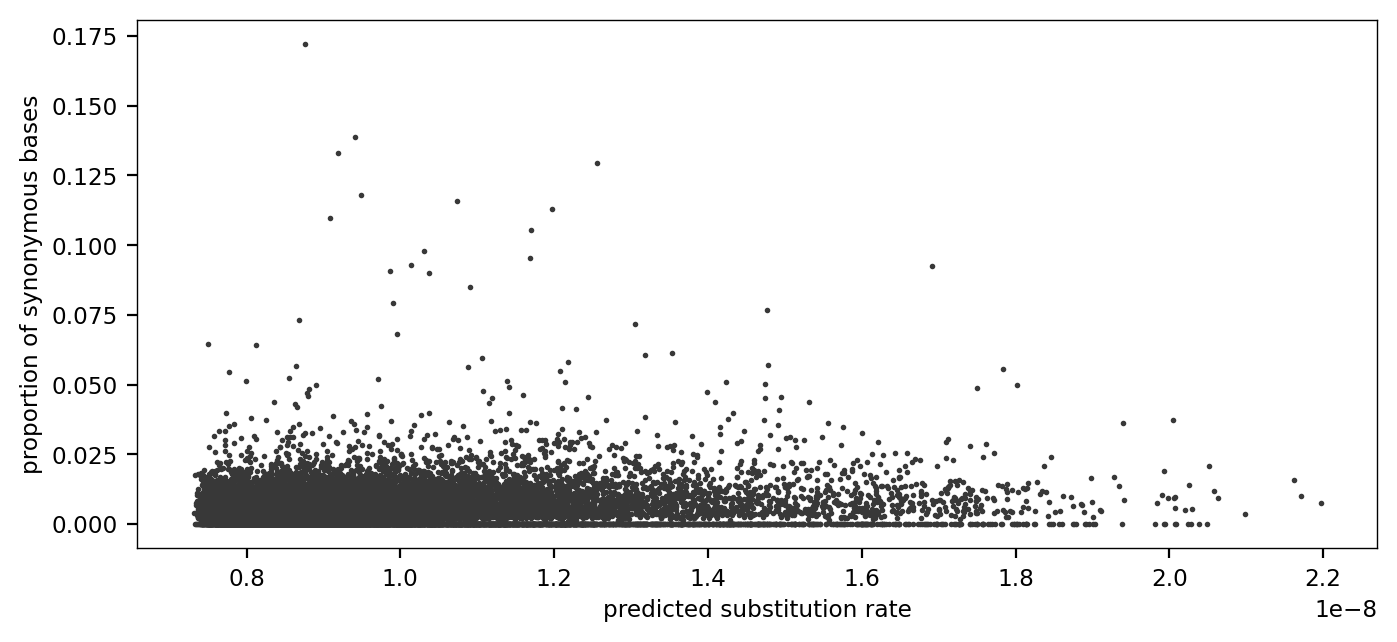

In [35]:
fig, ax = plt.subplots()
ax.scatter(d['r_rs'], d['syn_prop'], c='0.22', s=1, alpha=1)
ax.set_ylabel('proportion of synonymous bases')
ax.set_xlabel('predicted substitution rate')

Text(0.5, 0, 'predicted substitution rate')

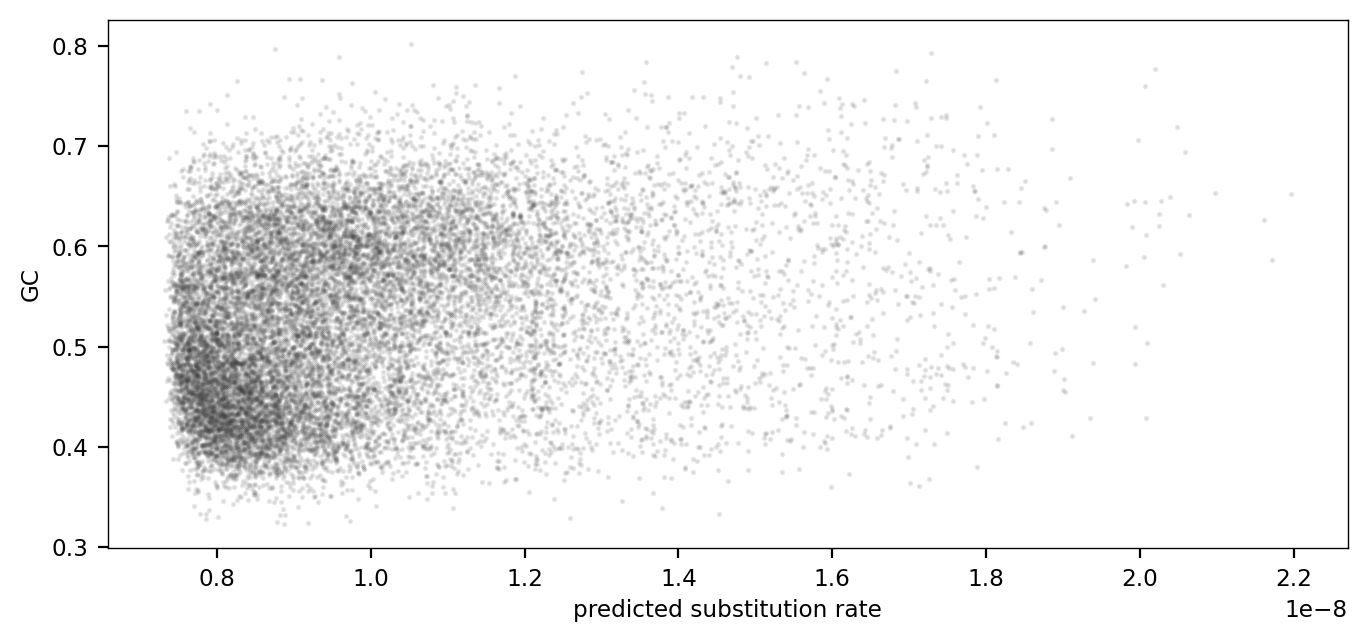

In [36]:
fig, ax = plt.subplots()
ax.scatter(d['r_rs'], d['gc'], c='0.22', s=1, alpha=0.1)
ax.set_ylabel('GC')
ax.set_xlabel('predicted substitution rate')

Now let's look at predicted (rescaled) substitution rates across the chromosomes:

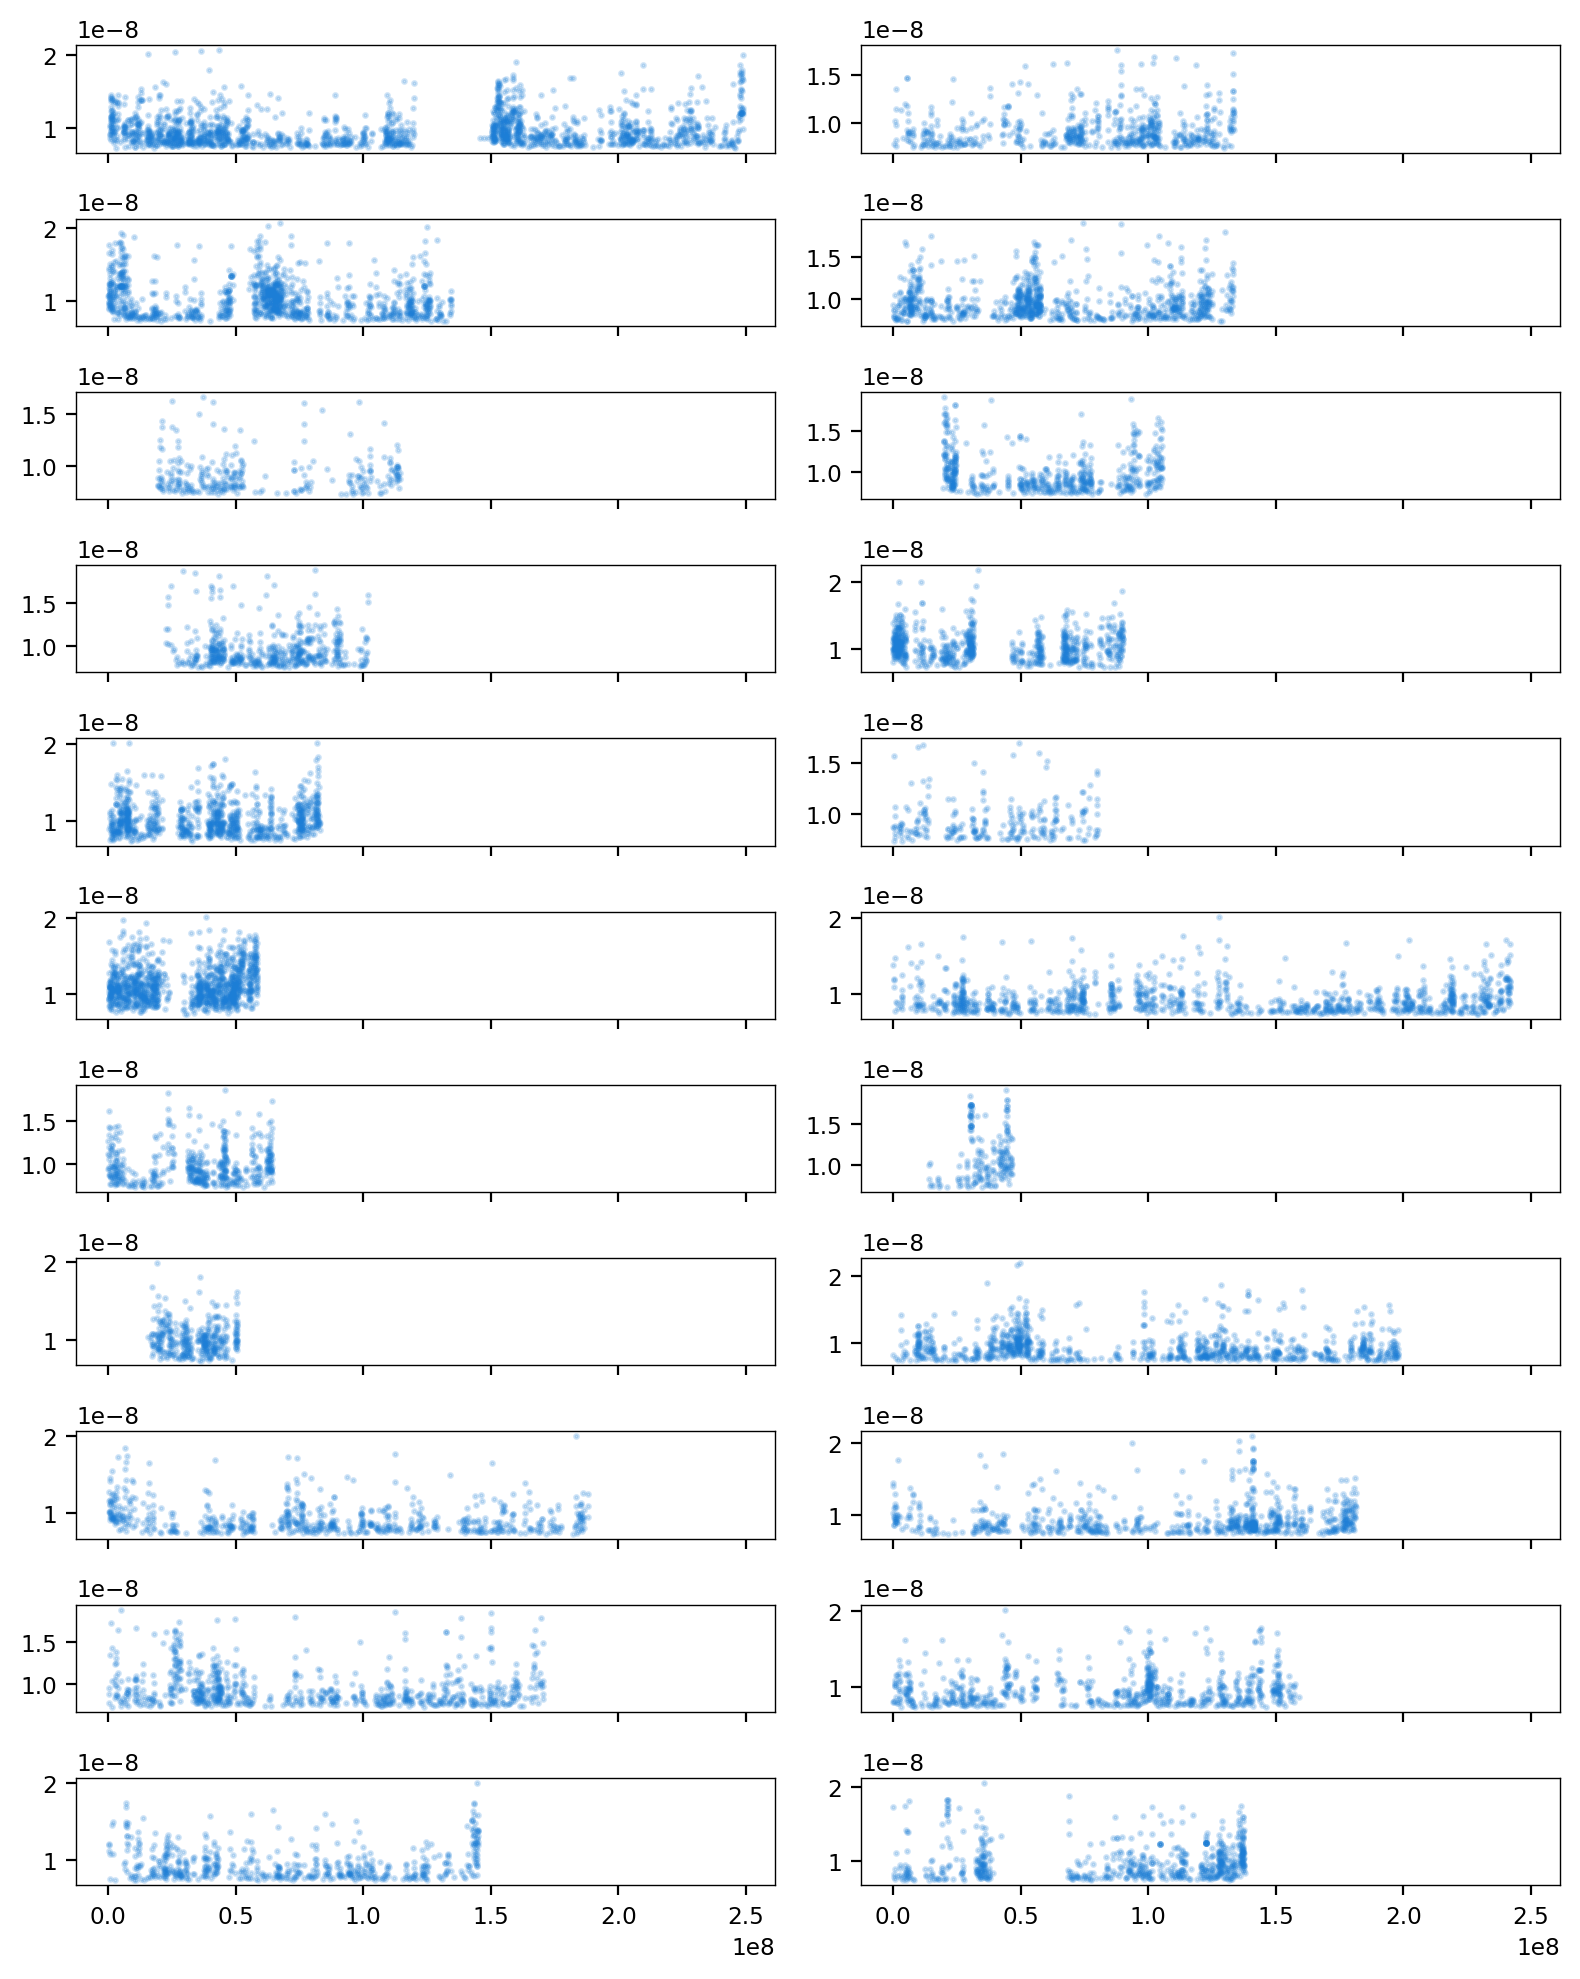

In [276]:
fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(d['chrom'].unique()):
    dx = d.loc[d['chrom'] == chrom]
    ax[rows.flat[i], cols.flat[i]].scatter(dx['start'], dx['r_rs'], s=2, alpha=0.2)
    
plt.tight_layout()

Now let's look at branch length (from PhyloFit) in the Urrichio et al data along the genome. Immediately we see some very strong outliers that we remove.

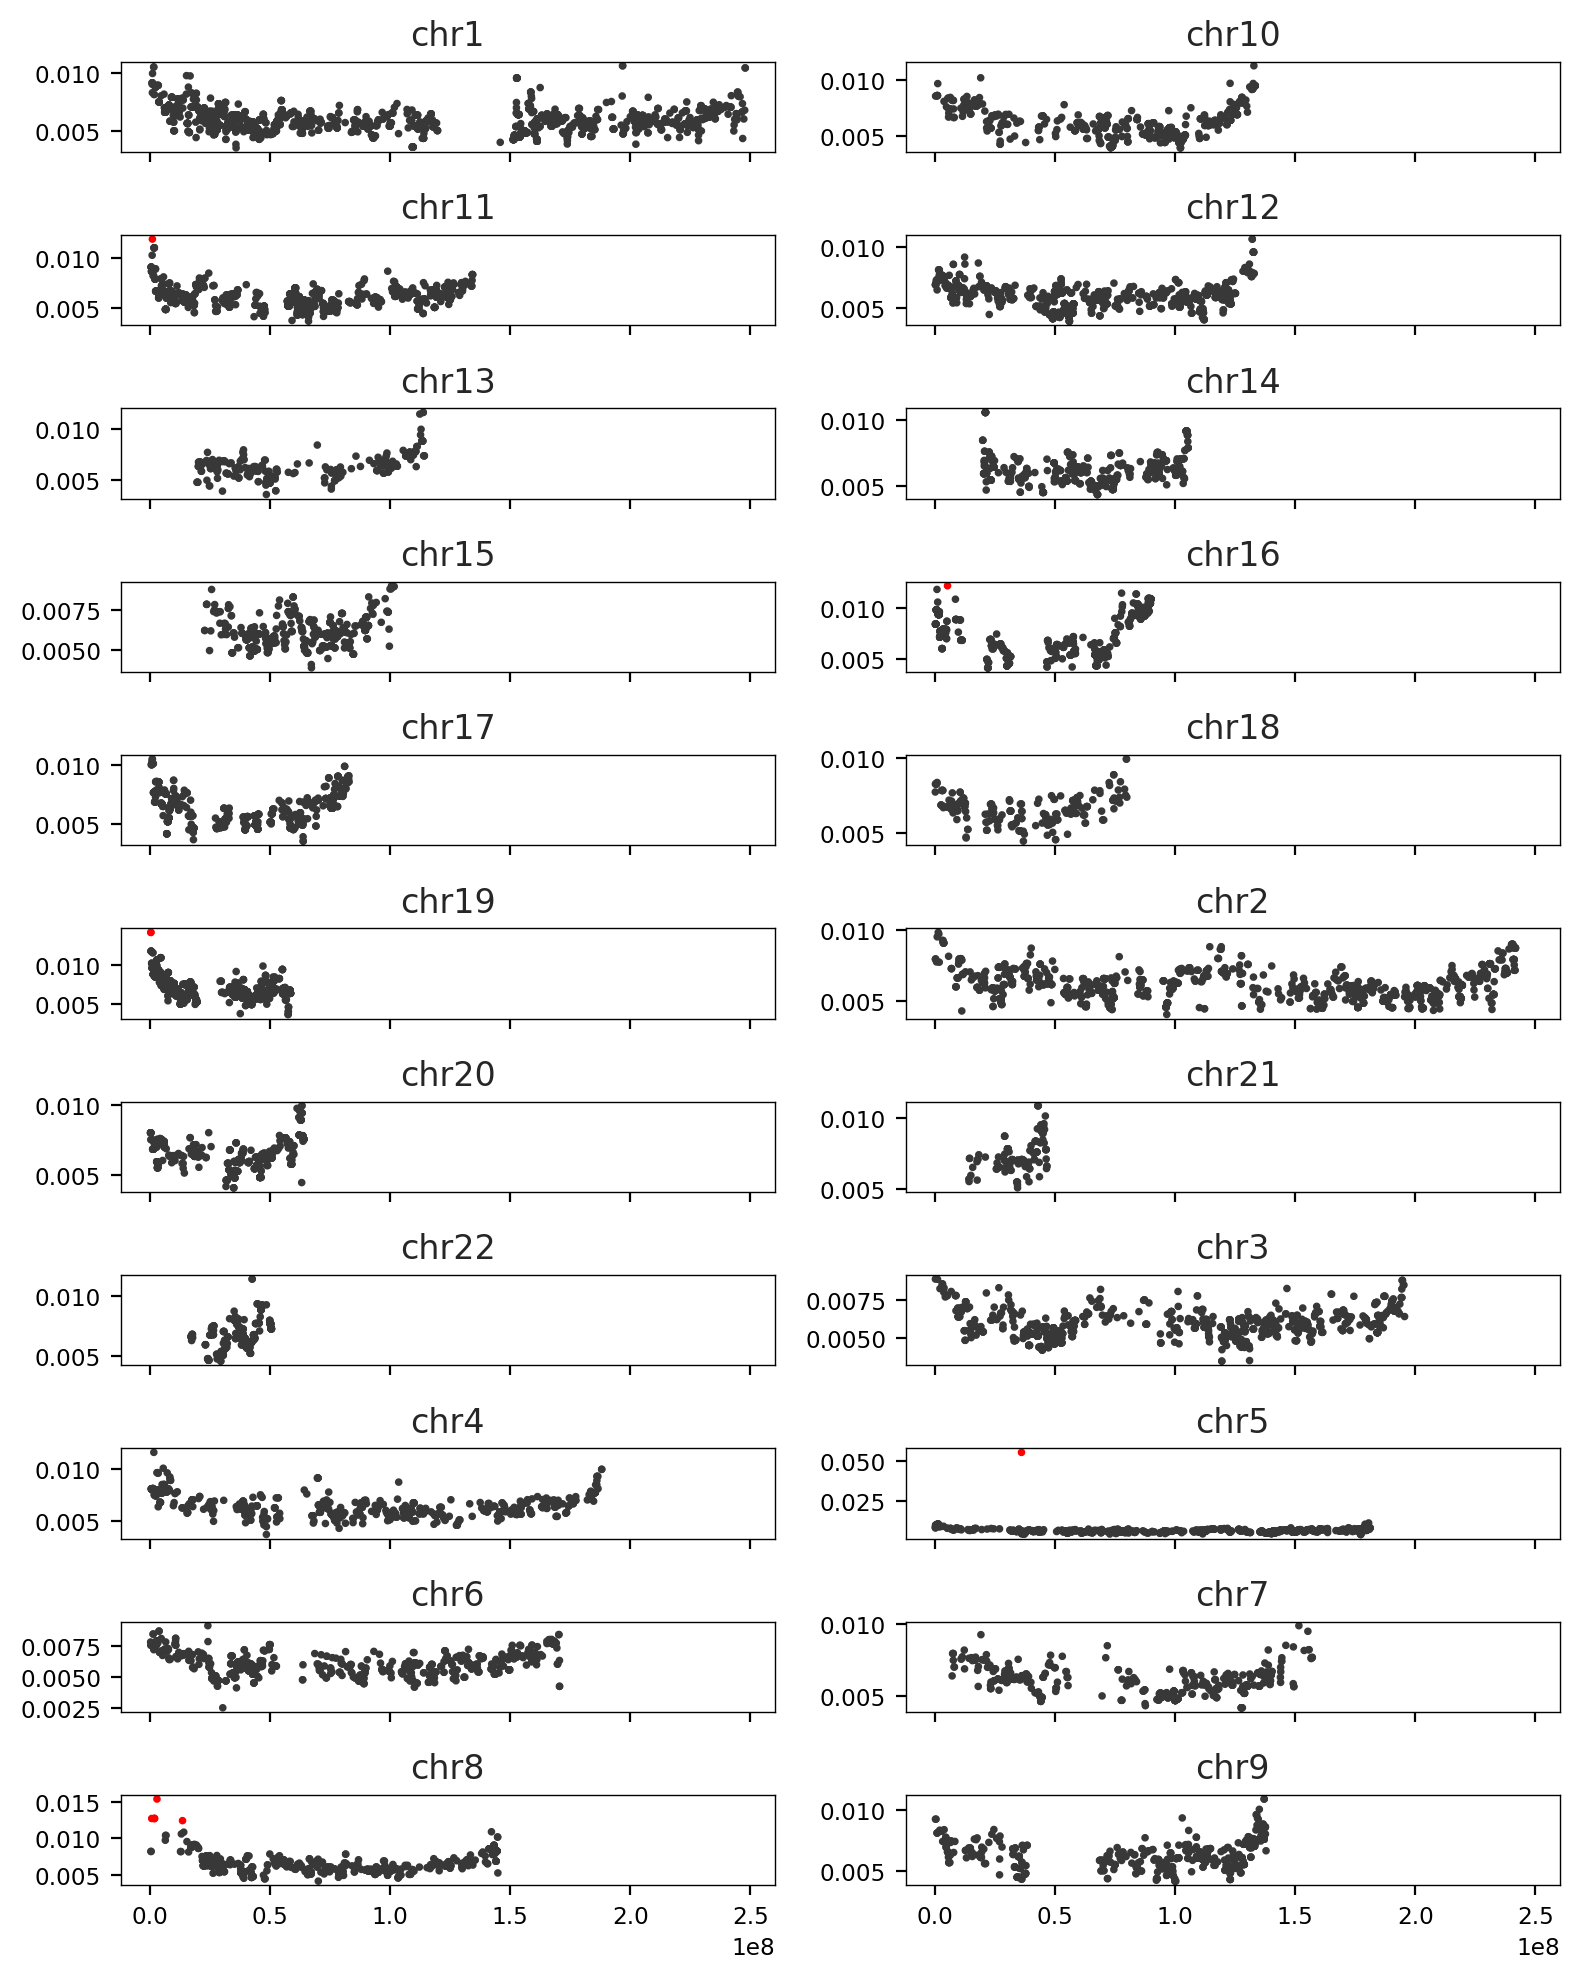

In [38]:
thresh = np.nanquantile(d['branch_length'], 0.999)

fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(d['chrom'].unique()):
    dx = d.loc[d['chrom'] == chrom]
    exclude = dx['branch_length'] > thresh
    ax[rows.flat[i], cols.flat[i]].scatter(dx['start'], dx['branch_length'], c=[{True: 'r', False: '0.22'}[x] for x in exclude], s=3)
    ax[rows.flat[i], cols.flat[i]].set_title(chrom)
plt.tight_layout()

In [307]:
# mask out those high branch lengths
do = d.copy()
do.loc[(d['branch_length'] >= thresh), 'branch_length'] = np.nan

### Comparison of 1Mbp Binned Ratchet Rates with the phyloFit Binned Branch Lengths

Let's just look at the large-scale spatial patterns between predicted substitution rate and the estimated branch lengths from phyloFit, at the megabase scale.

Note that this is **confounded** by the density of features, meaning within a window the ratchet rate is an average over all features hypothesized to be under selection.



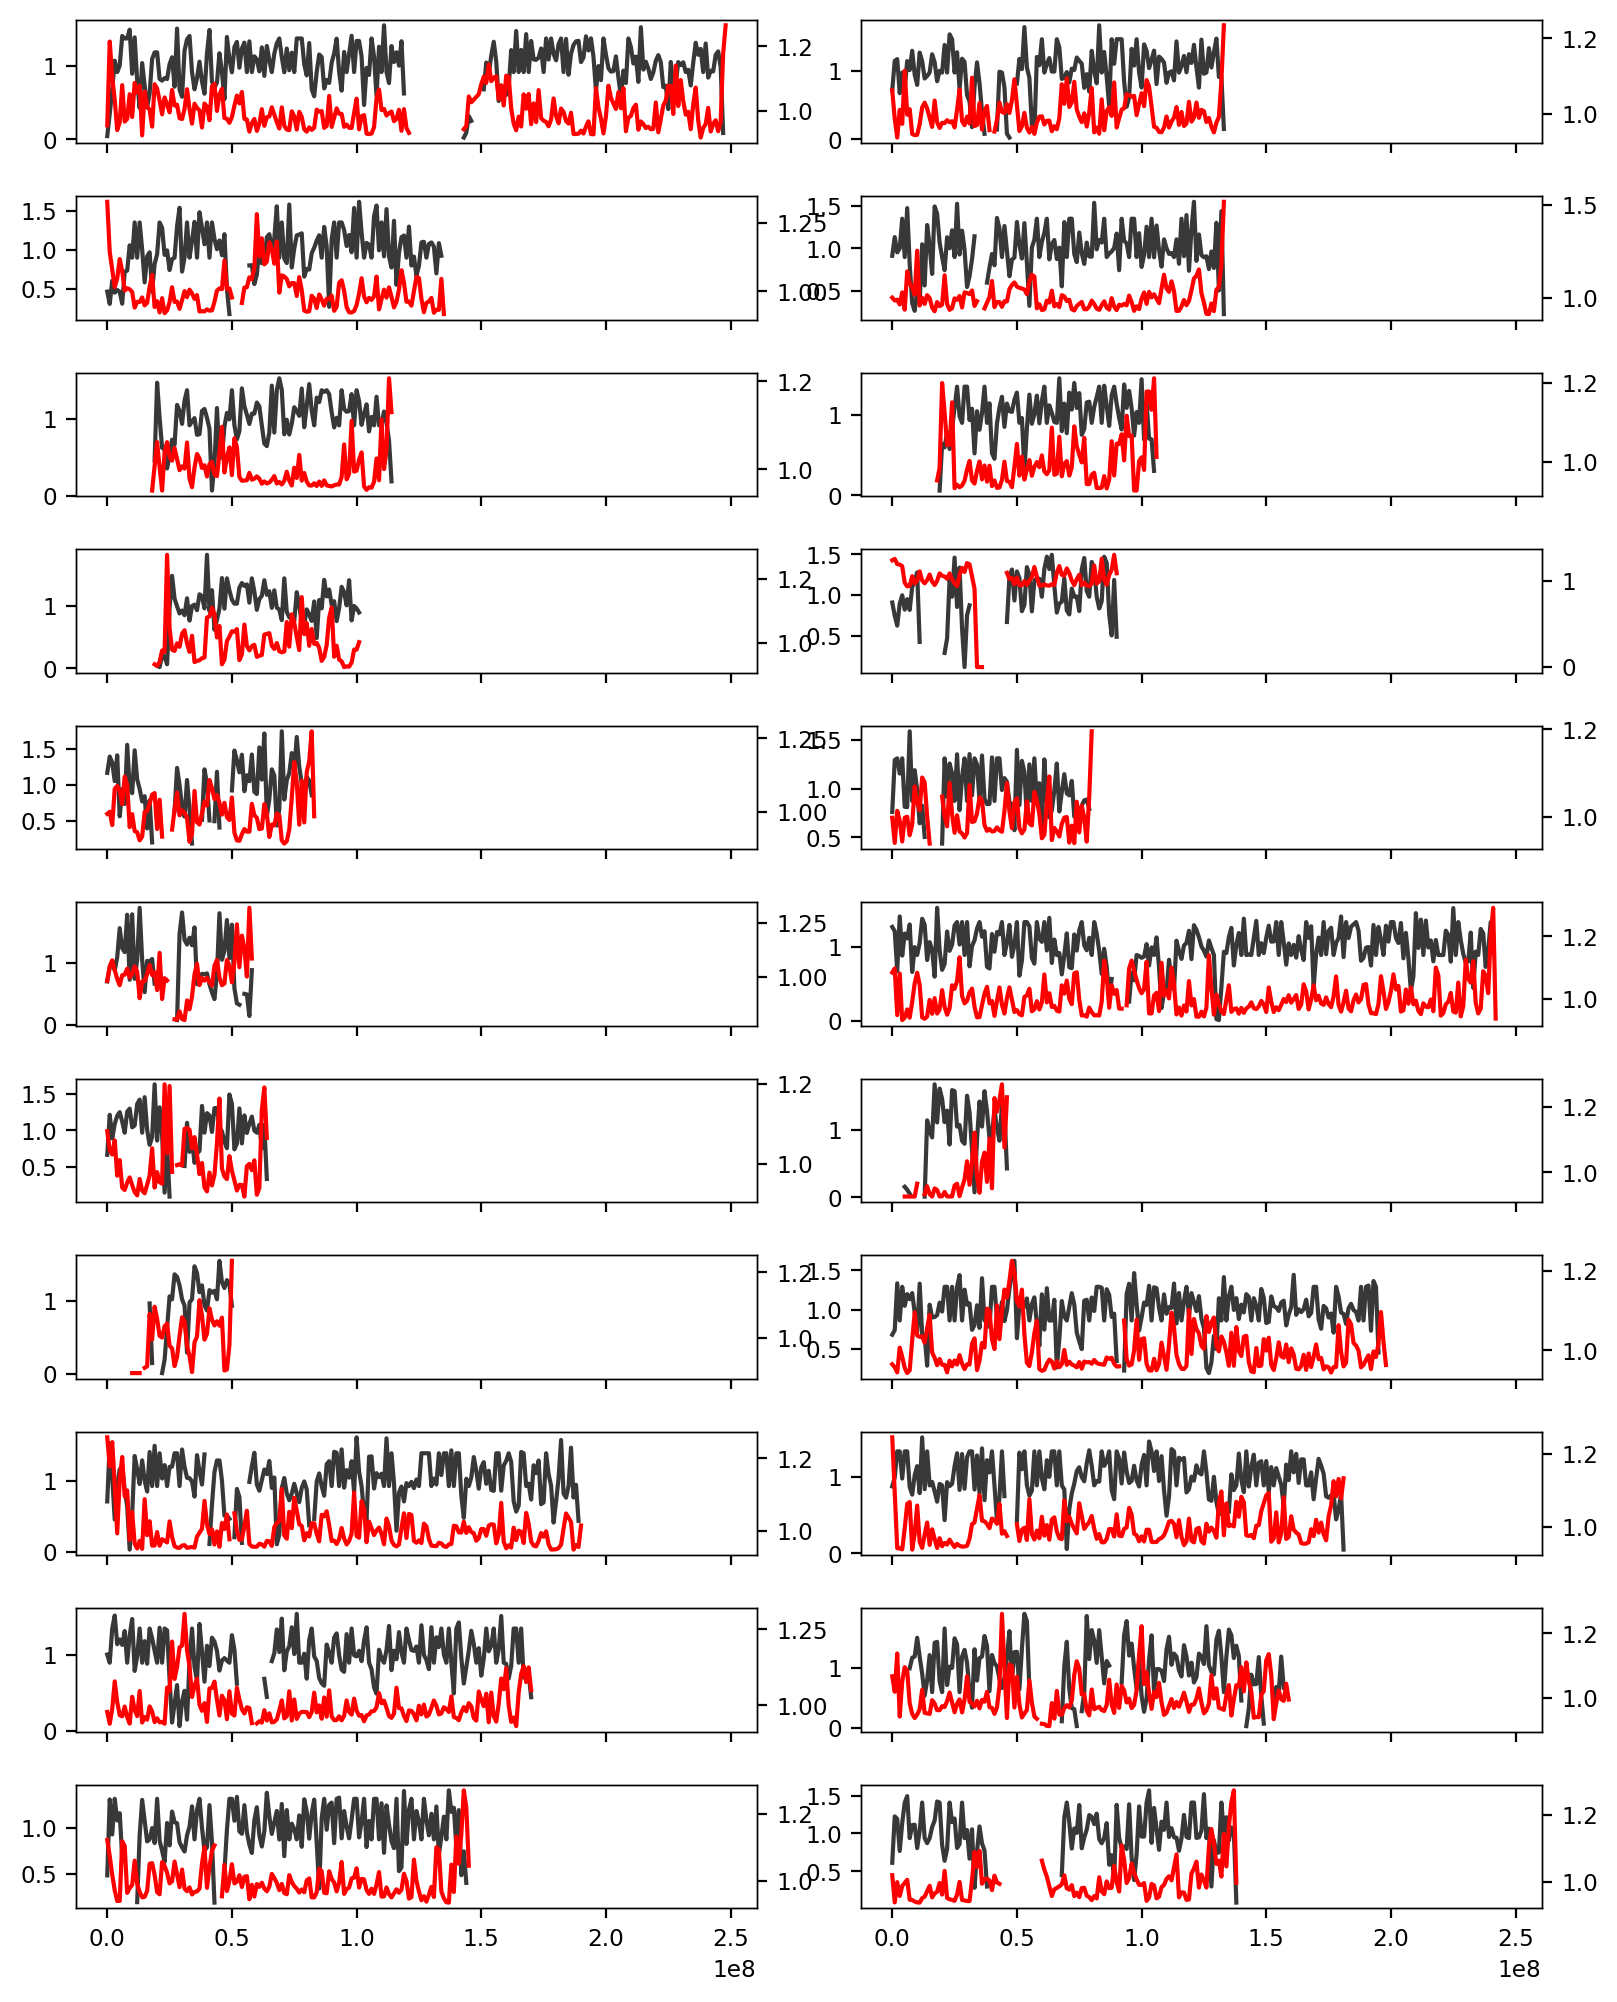

In [277]:
fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True)
plt.tight_layout()

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

bls, pred_subs = [], []
for i, chrom in enumerate(do['chrom'].unique()):
    dx = pf1Mb.loc[pf1Mb['chrom'] == chrom]
    fax = ax[rows.flat[i], cols.flat[i]]
    fax.plot(dx['start'], mean_ratio(dx['branch_length']), c='0.22')
    ax2 = fax.twinx()
    
    rx = r1Mb.loc[r1Mb['chrom'] == chrom]
    ax2.plot(rx['start'], mean_ratio(rx['r_rs']), c='r', zorder=-1)
    bls.extend(dx['branch_length'])
    pred_subs.extend(rx['r_rs'])
    
    #rx = rd2_1Mbp.loc[rd2_1Mbp['chrom'] == chrom]
    #ax2.plot(rx['start'], mean_ratio(rx['r']), c='g', linestyle='dashed')


Text(0.5, 0, 'predicted substitution rate')

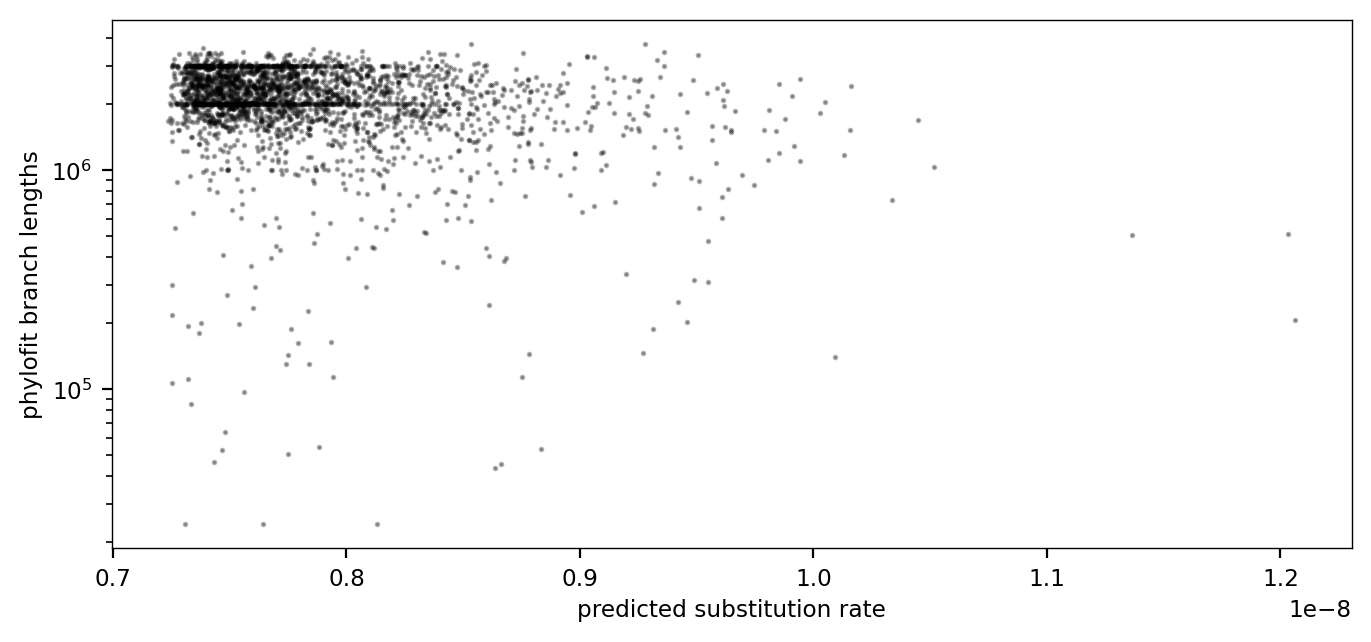

In [41]:
plt.scatter(pred_subs, bls, s=1, c='k', alpha=0.3)
plt.semilogy()
plt.ylabel('phylofit branch lengths')
plt.xlabel('predicted substitution rate')

Note the strange branch length estimates... this is most likely a large block being broken up, but needs further checks in the future. We don't use this data much...

In [486]:
tr = '((((Homo sapiens,(Pan troglodytes,Pan paniscus)),Gorilla gorilla),Pongo abelii))'

smap = {'Homo sapiens': 'hg38', 'Pan paniscus': 'panPan1', 'Pan troglodytes': 'panTro4', 'Gorilla gorilla': 'gorGor3', 'Pongo abelii': 'ponAbe2'}

for name, assem in smap.items():
    tr = tr.replace(name, assem)
    
tr

'((((hg38,(panTro4,panPan1)),gorGor3),ponAbe2))'

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:665: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(np.array(bin_map[i]))
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 0, 'predicted substitution rate')

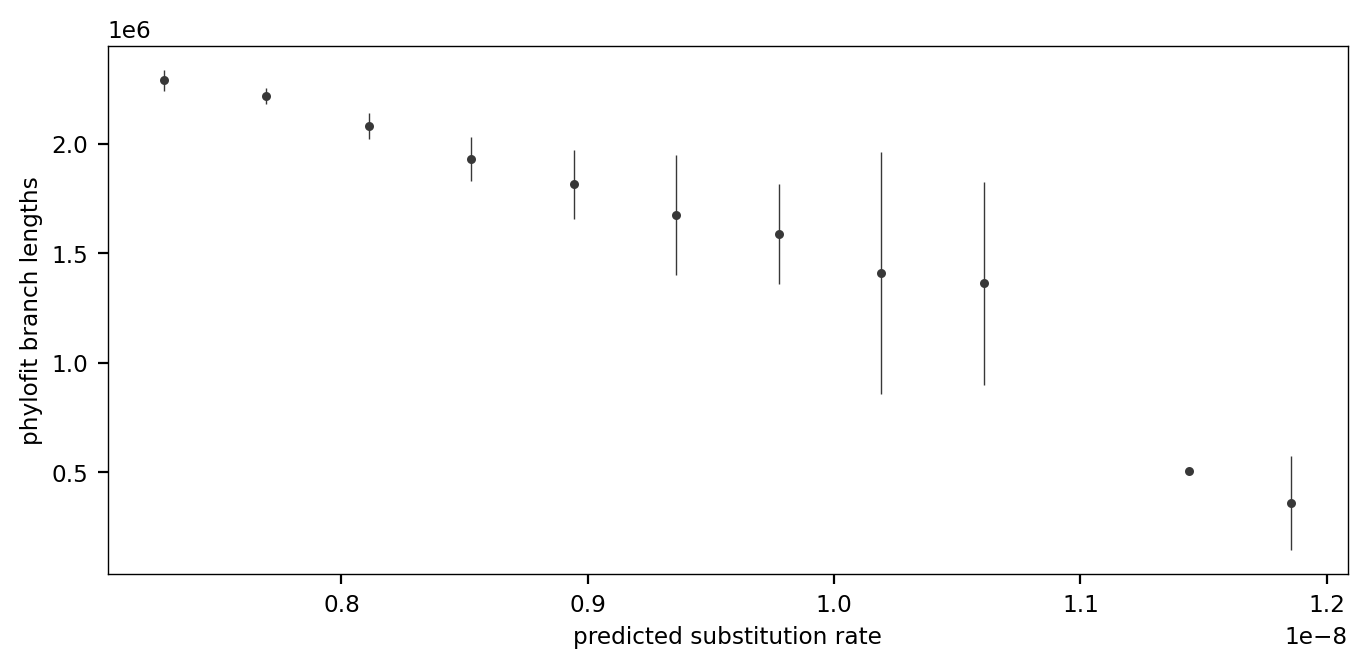

In [42]:
binned_means_plot(binned_summaries(pred_subs, bls, 30))
plt.ylabel('phylofit branch lengths')
plt.xlabel('predicted substitution rate')

Basically, there looks to be a significant but messy negative correlation across windows between predicted substitution rate and branch length.

In [43]:
corr(pred_subs, bls)

((-0.25589368560240244, 5.692109650846044e-40),
 SpearmanrResult(correlation=-0.2035772987534648, pvalue=1.3020772980369262e-25))

This is likely caused by confounding by the placement of conserved regions. For example, windows with more conserved regions have a higher prediction substitution rate, which puts these regions under selective constraint and causes a lower branch length. This confounding is why the gene-level analysis best, it compares the **segment (e.g. CDS) predicted substitution rate** with the **observed number of substitutions**.

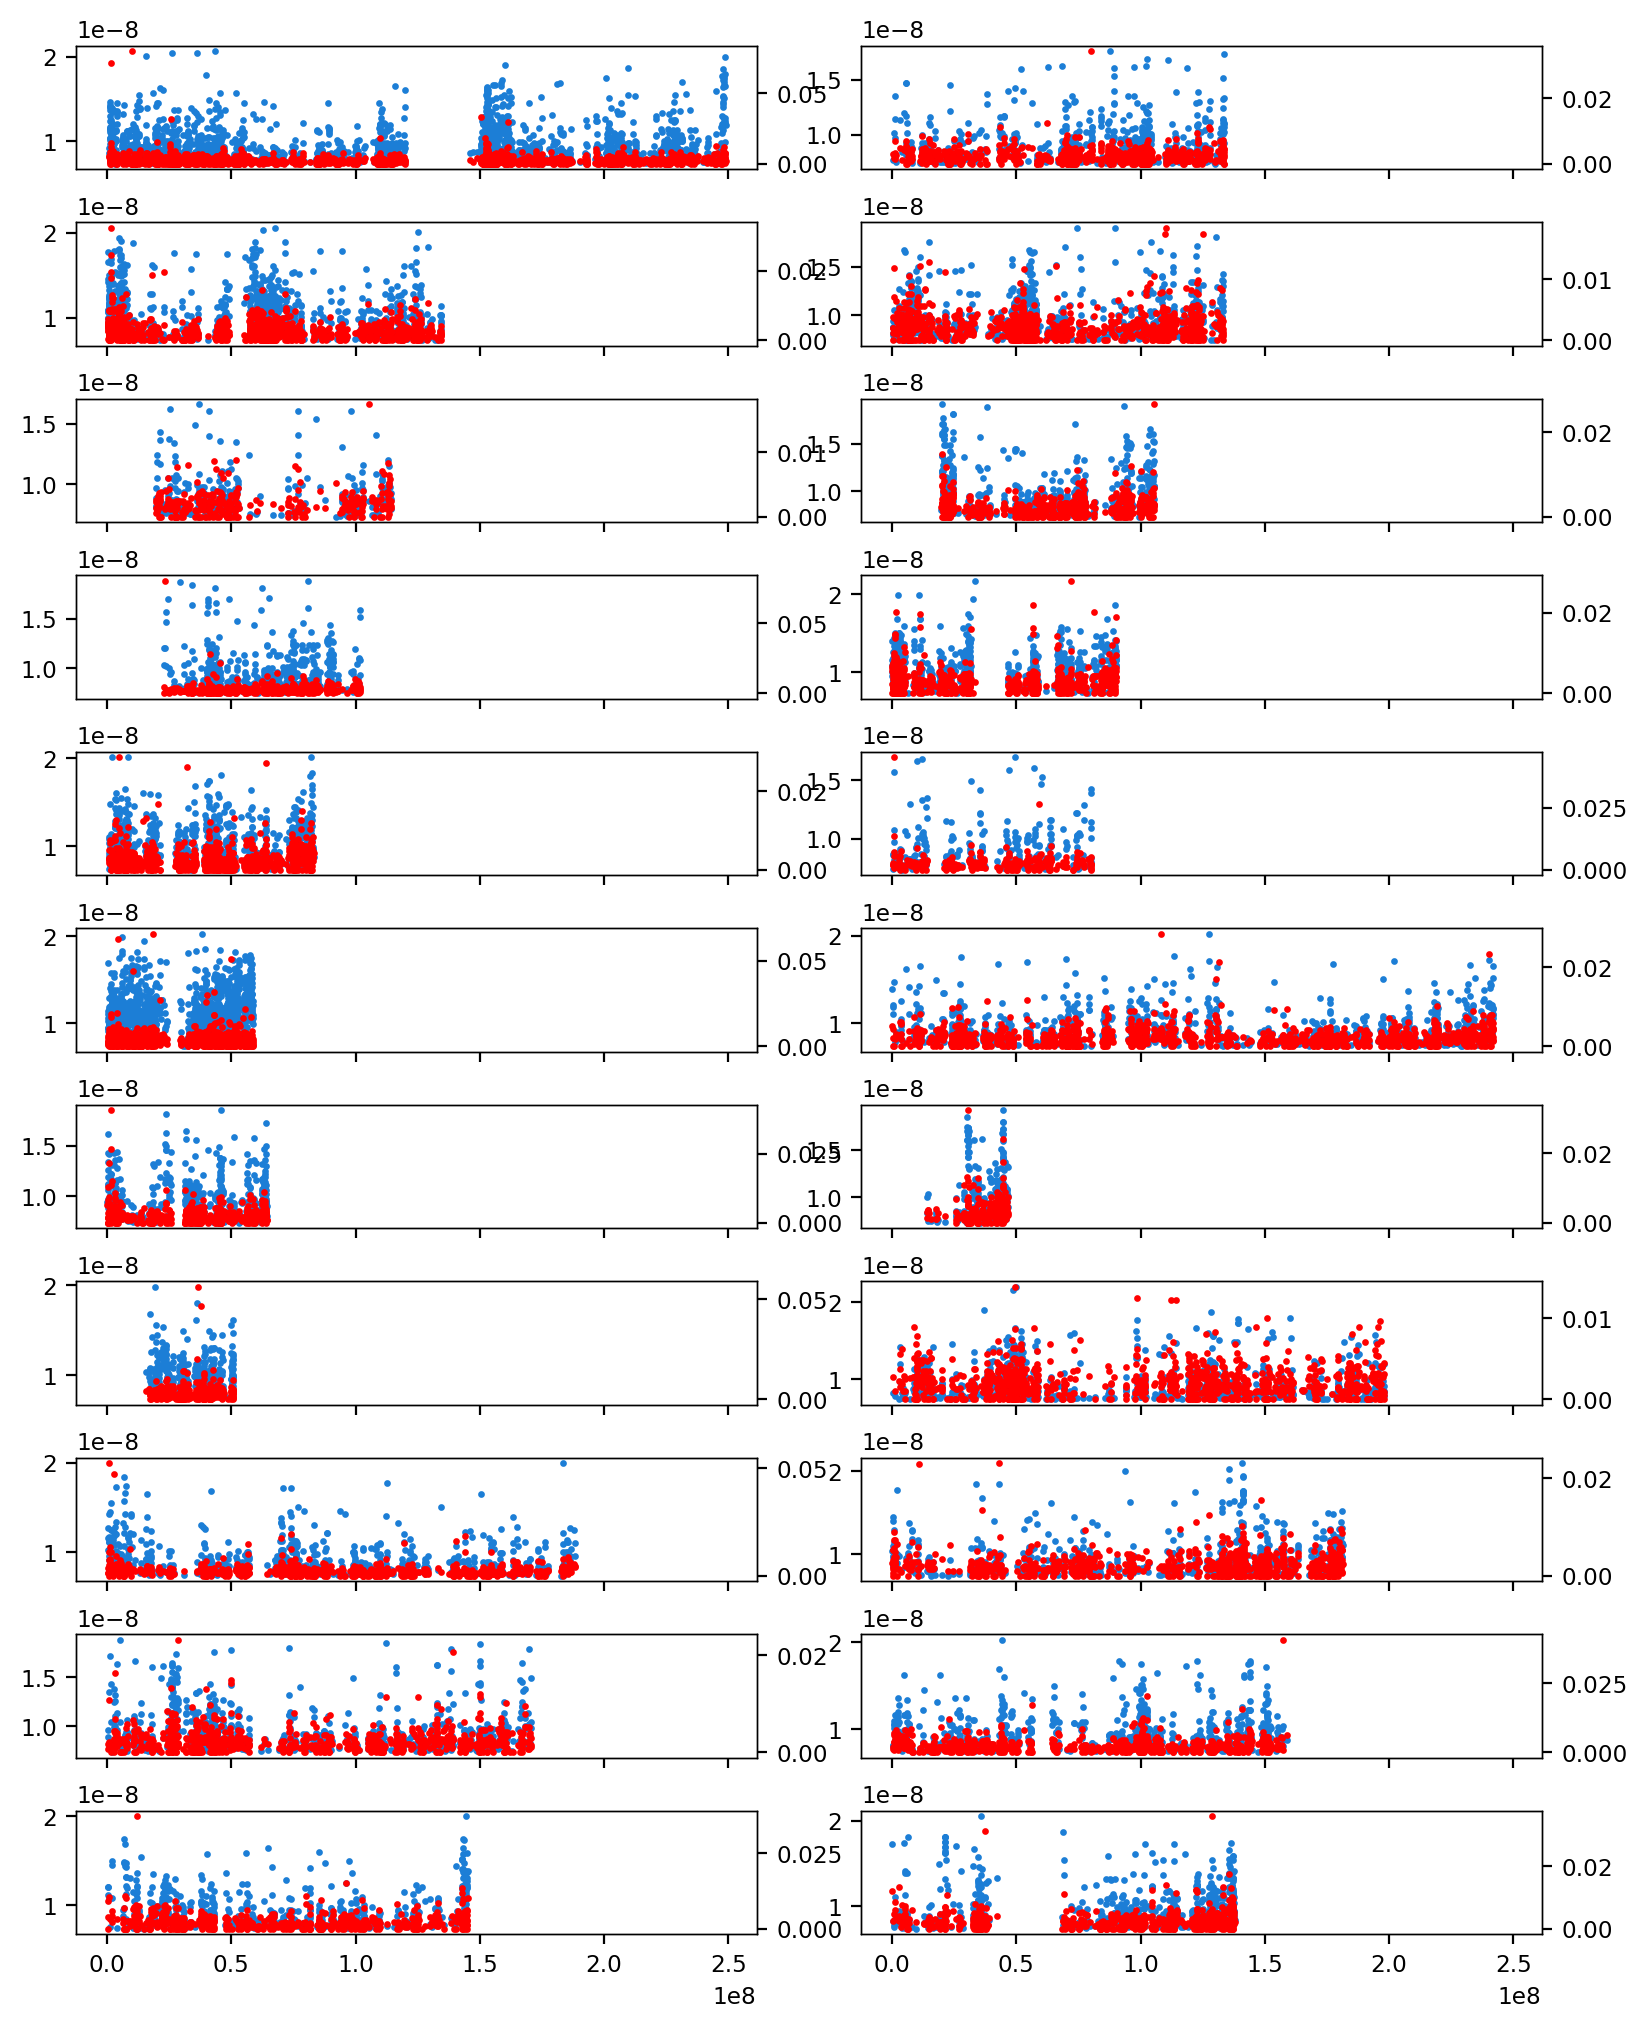

In [282]:
fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True)
plt.tight_layout()

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

bls, pred_subs = [], []
for i, chrom in enumerate(do['chrom'].unique()):
    dx = do.loc[do['chrom'] == chrom]
    fax = ax[rows.flat[i], cols.flat[i]]
    #stats.binned_statistic(dx['midpoint'], dx['r_rs'], bins=bin_chroms(
    #fax.scatter(, s=2)
    ax2 = fax.twinx()
    ax2.scatter(dx['midpoint'], dx['total_prop'], c='r', s=2)    
    
    #rx = rd2_1Mbp.loc[rd2_1Mbp['chrom'] == chrom]
    #ax2.plot(rx['start'], mean_ratio(rx['r']), c='g', linestyle='dashed')


### PhyloFit Branch Length Estimates

The raw phylofit data, see the `Snakefile` for how this is processed.

Note that the alignments are fairly large and between 10 primate species. The regions that can be aligned are likely under more contraint compared to regions that are not alignable. 

In [44]:
cols = ['chrom', 'start', 'end', 'branch_length', 'bl_nbases']
p = pd.read_csv('../data/phylo/phylofit_rates.bed', sep='\t', na_values='.', names=cols)
p['width'] = p['end'] - p['start']

In [45]:
p.head()

chrom    start      end  branch_length  bl_nbases   width
0  chr1   917515   943305       0.008880      41161   25790
1  chr1   943306   972277       0.009129      55542   28971
2  chr1  1034538  1055058       0.006629      33328   20520
3  chr1  1055059  1167921       0.009928     459429  112862
4  chr1  1564774  1623511       0.010481     178850   58737

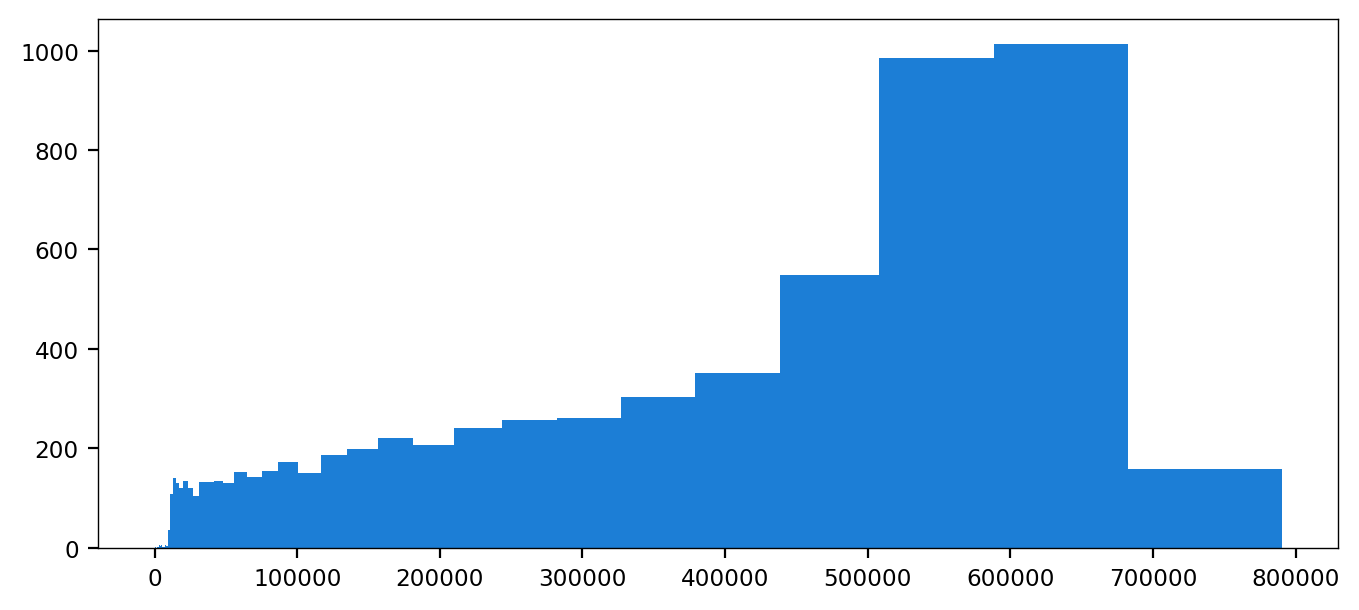

In [46]:
_ = plt.hist(*logbins(p['width'], 60))

[]

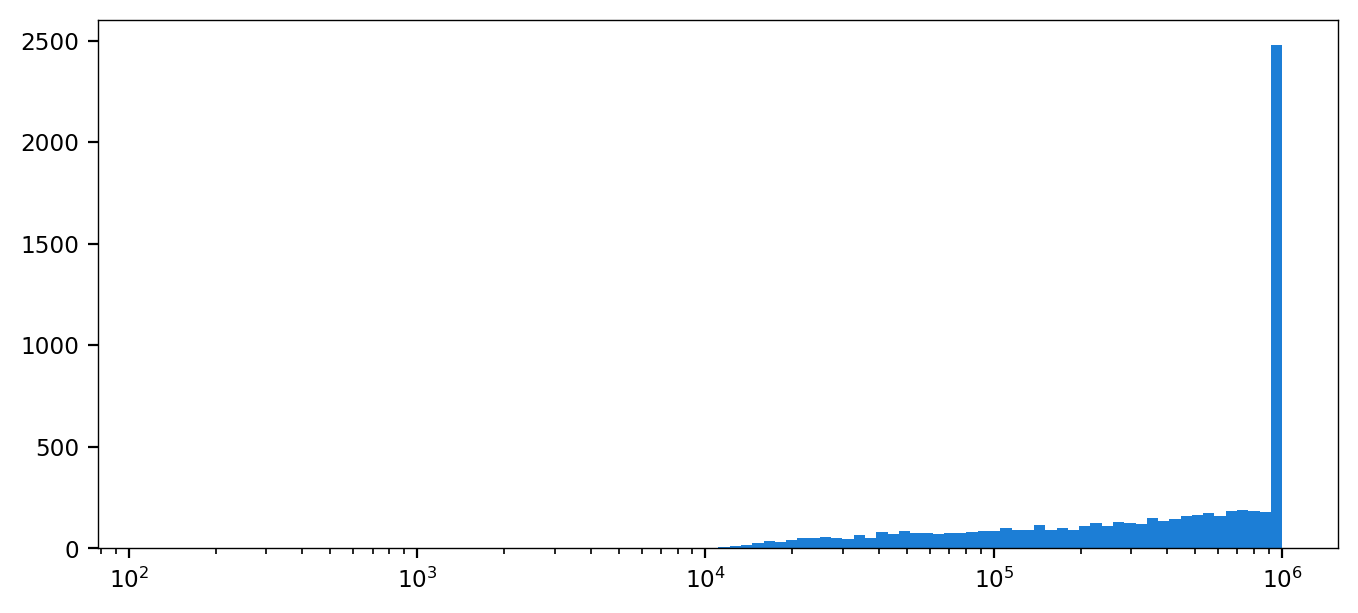

In [47]:
plt.hist(*logbins(p['bl_nbases'], 100))
plt.semilogx()

Esemble's data includes alignments only up to a megabase in length, hence the over-representation of this bin.

In [48]:
p['bl_nbases'].max()

1000000

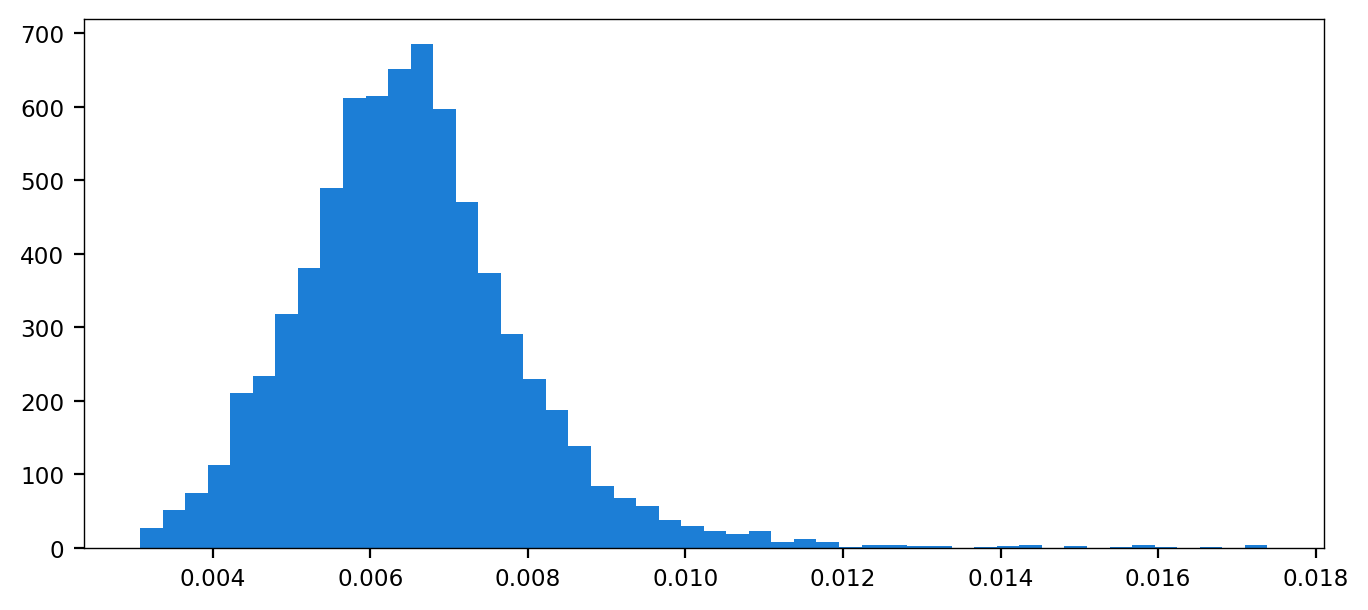

In [49]:
_ = plt.hist(censor(p['branch_length'], (0.001, 0.999)), 50)

## Gene-level Substitution Analysis and Parametric Models

### Set Commonly-used variables, Rescale to Years

I assume the generation time is $g = 30$ years/gen.

```
R subs/gen x 1/(g years/gen) = R/g subs/year
```

(This is all done by the units framework now...)


In [362]:
# the per-bp substitution rates are in subs/gen, we convert them here to mutations/year
do['r_year'] = np.array((do['r'].values * u.mutations/u.human_gen).to('mutations/year'))
do['r_rs_year']  = np.array((do['r_rs'].values * u.mutations/u.human_gen).to('mutations/year'))

In [363]:
## commonly used values.
## NOTE: x_rs is rescaled to YEARS!
x, x_rs, nonsyn_prop, syn_prop, total_prop, branch_length = (do['r_year'].values, do['r_rs_year'].values, do['nonsyn_prop'].values, 
                                                             do['syn_prop'].values, do['total_prop'].values, do['branch_length'].values)
b = do['B'].values

#keep = syn_prop > 0
#x_rs, syn_prop = x_rs[keep], syn_prop[keep]

[]

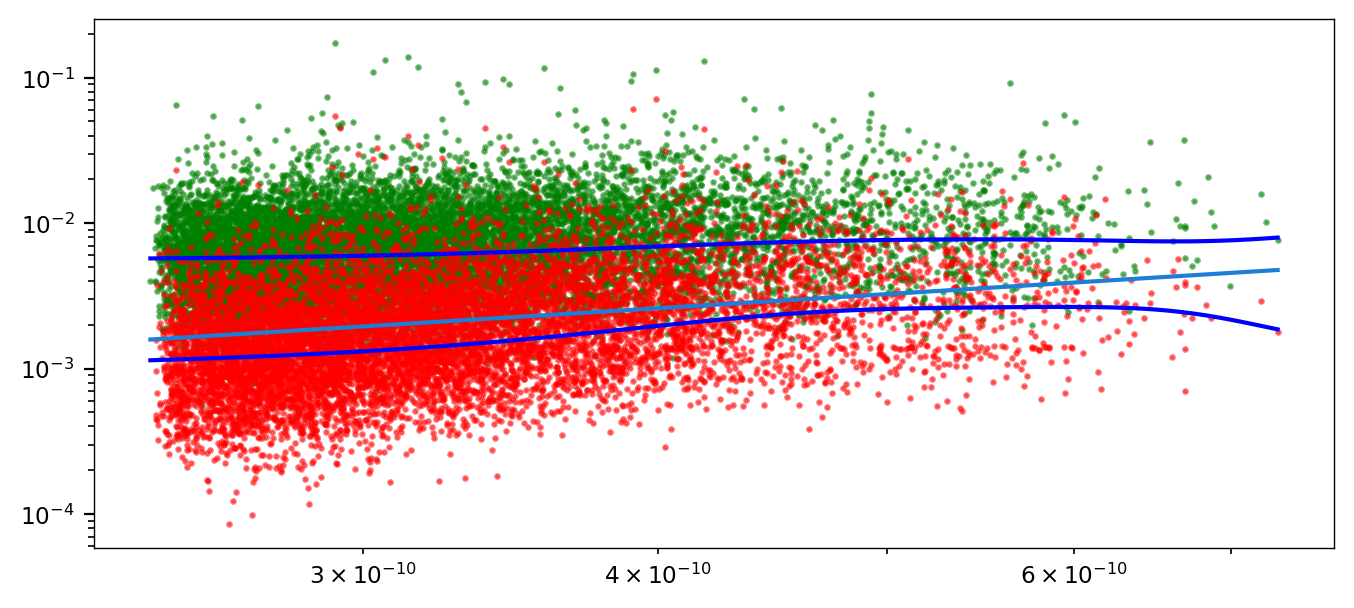

In [52]:
fig, ax = plt.subplots()

ax.scatter(x_rs, syn_prop, c='green', s=2, alpha=0.5)
ax.scatter(x_rs, nonsyn_prop, c='r', s=2, alpha=0.5)

xval = x_rs
rate_grid = np.linspace(xval.min(), xval.max(), 100)
ax.plot(rate_grid, KernelRegression(h=5e-11).fit(xval, syn_prop).predict(rate_grid), c='b')
#ax.plot(rate_grid, 6.5e6*rate_grid)

ax.plot(rate_grid, KernelRegression(h=5e-11).fit(xval, nonsyn_prop).predict(rate_grid), c='b')
ax.plot(rate_grid, 6.5e6*rate_grid)

ax.semilogx()
ax.semilogy()


[]

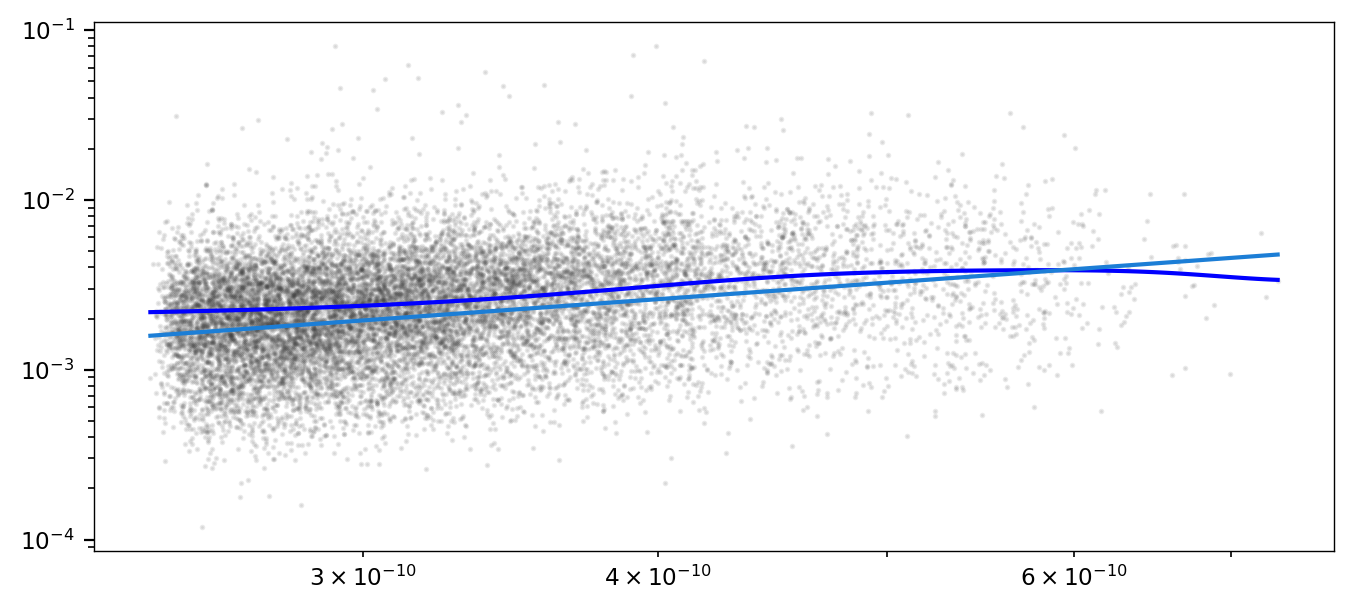

In [53]:
fig, ax = plt.subplots()

ax.scatter(x_rs, total_prop, c='0.22', s=1, alpha=0.1)

xval = x_rs
rate_grid = np.linspace(xval.min(), xval.max(), 100)
ax.plot(rate_grid, KernelRegression(h=5e-11).fit(xval, total_prop).predict(rate_grid), c='b')
ax.plot(rate_grid, 6.5e6*rate_grid)

ax.semilogx()
ax.semilogy()


In [196]:
x_rs

0        2.870321e-10
1        3.078192e-10
2        3.373875e-10
3        3.036900e-10
4        3.462403e-10
             ...     
16311    3.135587e-10
16312    3.130246e-10
16313    3.449845e-10
16314    3.693077e-10
16315    2.774689e-10
Name: r_rs_year, Length: 16316, dtype: float64

### Correlations

#### Correlations between Predicted and Observed Substitution Rates

In [54]:
corr(d['r_rs'], d['total_prop']), corr(d['r_rs'], d['syn_prop']), corr(d['r_rs'], d['nonsyn_prop'])

(((0.19107139860951688, 5.778145028491153e-134),
  SpearmanrResult(correlation=0.21099378519515583, pvalue=1.3945319861241544e-163)),
 ((0.0998517646057235, 1.9768893980340133e-37),
  SpearmanrResult(correlation=0.0635541347949618, pvalue=4.450703503892629e-16)),
 ((0.20396563833114864, 9.025041122028251e-153),
  SpearmanrResult(correlation=0.19152197348967517, pvalue=1.3393205066236933e-134)))

Now let's look at GC, which could be a confounder:

In [55]:
corr(d['r_rs'], d['gc']), corr(d['r_rs'], d['gc3'])

(((0.24377083143339068, 2.4066563670853273e-219),
  SpearmanrResult(correlation=0.2710308871959067, pvalue=1.2077960745688494e-272)),
 ((0.25331863628796886, 2.779543901530697e-237),
  SpearmanrResult(correlation=0.2871748309283591, pvalue=2.7111821192328593e-307)))

GC could be a confounder; our prediction accuracy could be an artifact of some other relationship. We explore this more below with linear fits.

What about B?

In [287]:
corr(d['r_rs'], d['B']) 

((0.10127526275406225, 1.8420504062999564e-38),
 SpearmanrResult(correlation=0.1380489457078496, pvalue=3.09503312039414e-70))

There is a positive correlation between B and our predicted substitution rate. This is interesting — it shows that predicted substitution rates aren't intuitively like HRI would suggest, e.g. lower B, higher substitution rates. How well does B alone do in predicting substitution rates?

#### Bootstrap CIs for Correlation

In [56]:
bs_spear = []
bs_pear = []

n = do.shape[0]
nboot = 1000
for b in range(nboot):
    idx = np.random.randint(0, n, n)
    cors = corr(do['r_rs'].values[idx], do['total_prop'].values[idx])
    bs_spear.append(cors[1])
    bs_pear.append(cors[0])

In [57]:
spearman_est = corr(do['r_rs'], do['total_prop'])[1].correlation
pearson_est = corr(do['r_rs'], do['total_prop'])[0][0]

spearman_est, pearson_est

(0.21099378519515583, 0.19107139860951688)

In [58]:
bs_spearman = np.array([cor for cor, pval in bs_spear])
bs_pearson = np.array([cor for cor, pval in bs_pear])

(array([ 15.,  50., 110., 178., 192., 190., 149.,  76.,  27.,  13.]),
 array([0.16375266, 0.1694473 , 0.17514194, 0.18083659, 0.18653123,
        0.19222588, 0.19792052, 0.20361516, 0.20930981, 0.21500445,
        0.2206991 ]),
 <BarContainer object of 10 artists>)

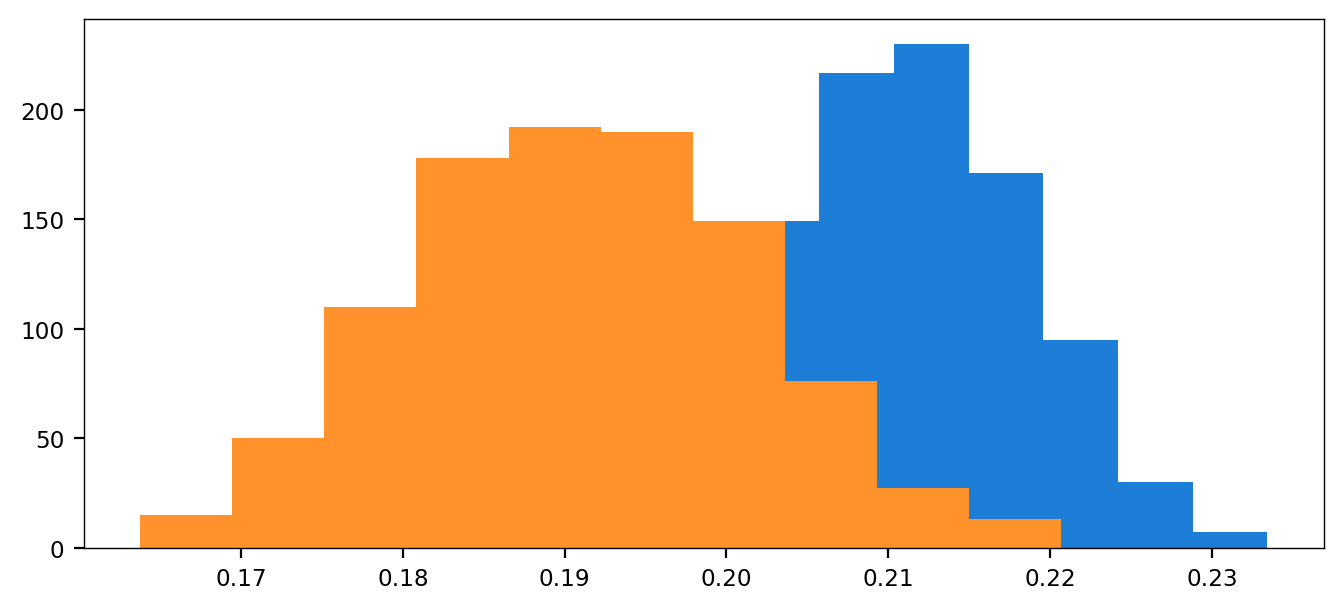

In [59]:
plt.hist(bs_spearman)
plt.hist(bs_pearson)


In [60]:
from bgspy.bootstrap import pivot_ci

lower, upper = pivot_ci(bs_spearman, spearman_est)
lower, spearman_est, upper

(0.19688077198055776, 0.21099378519515583, 0.22497941966715085)

In [62]:
lower, upper = pivot_ci(bs_pearson, pearson_est)
lower, pearson_est, upper

(0.17019560110082746, 0.19107139860951688, 0.21038718836789033)

### B and Predicted Substitution Rates by Genes

Let's look more now at the relationship between **rescaled** B' and the substitution rates (predicted and observed).

#### Correlations between B and CDS Substitutions


In [336]:
corr(do['B'], do['total_prop'])

((0.08482409894372914, 1.9158721566259496e-27),
 SpearmanrResult(correlation=0.12210401351686263, pvalue=3.1072521550292326e-55))

First, everything is correlated with everything; it's important to note this in the paper — the causality is unclear, but the fit with the theoretic selection model is fairly strong evidence that this is truly selection rather than other backdoor paths. 

Second, the correlation here is what we'd expect given Murphy et al. (2002) look at different mutation rates for different spectra — it's in the same direction. 

[]

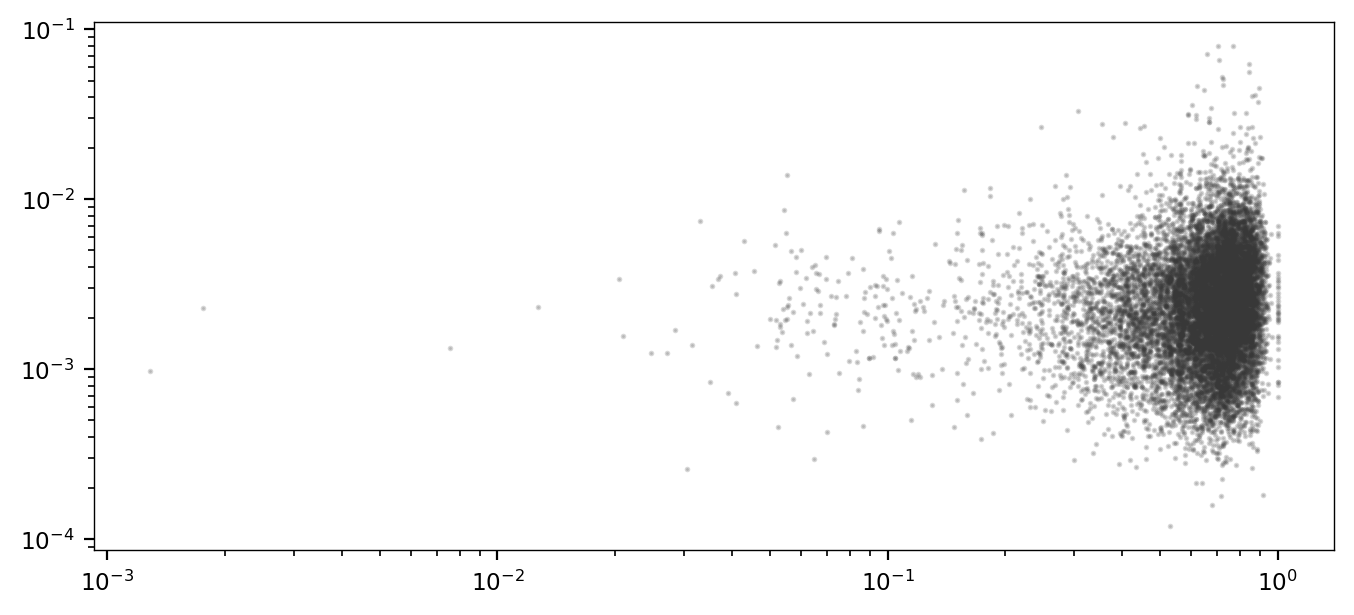

In [337]:
plt.scatter(do['B'], do['total_prop'], s=1, c='0.22', alpha=0.2)
plt.loglog()

#### Binned Summary Plots

(<Figure size 1600x700 with 1 Axes>, <AxesSubplot: >)

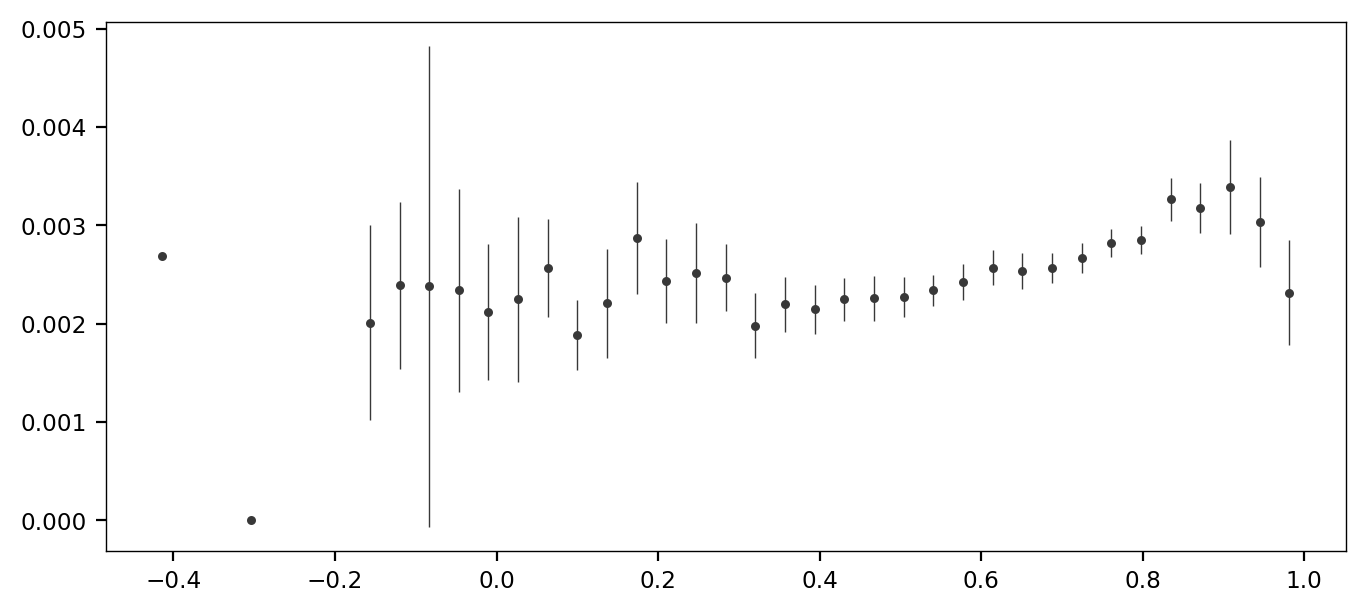

In [338]:
binned_means_plot(binned_summaries(do['B'], do['total_prop'], 40))

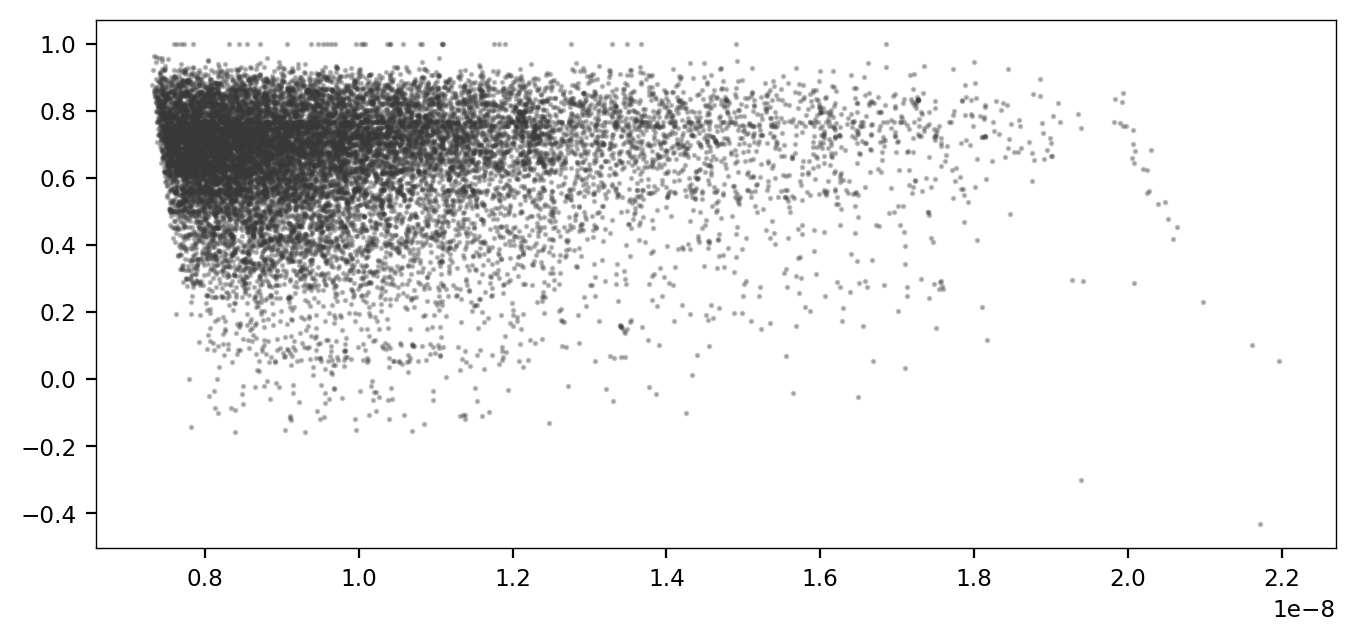

In [333]:
plt.scatter(do['r_rs'].values, do['B'].values, s=1, c='0.22', alpha=0.3)

In [322]:
kf_r_rs_B = bin_kfolds(do['r_rs'], do['B'], bins=np.arange(5, 300, 10))

75

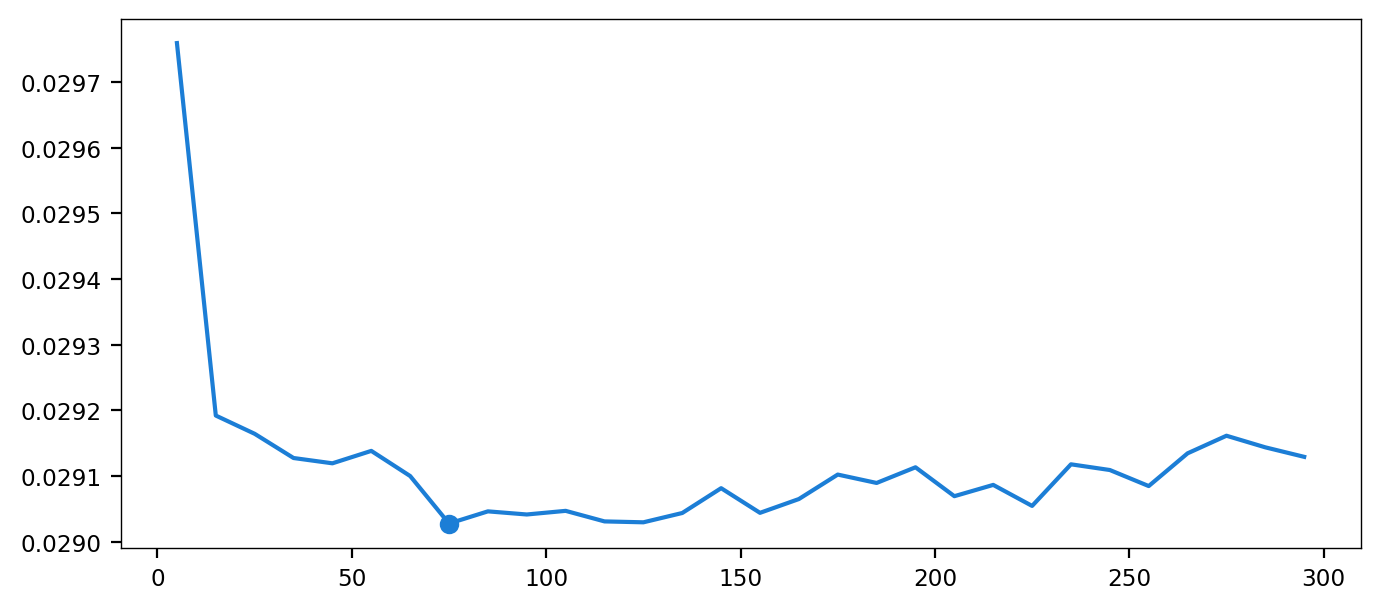

In [329]:
kfolds_results(kf_r_rs_B)

In [400]:
corr(do['r_rs'].values, do['B'].values)

((-0.004572243749247835, 0.5592272137734421),
 SpearmanrResult(correlation=0.0012835897388824887, pvalue=0.8697739026138415))

Text(0, 0.5, "rescaled B'")

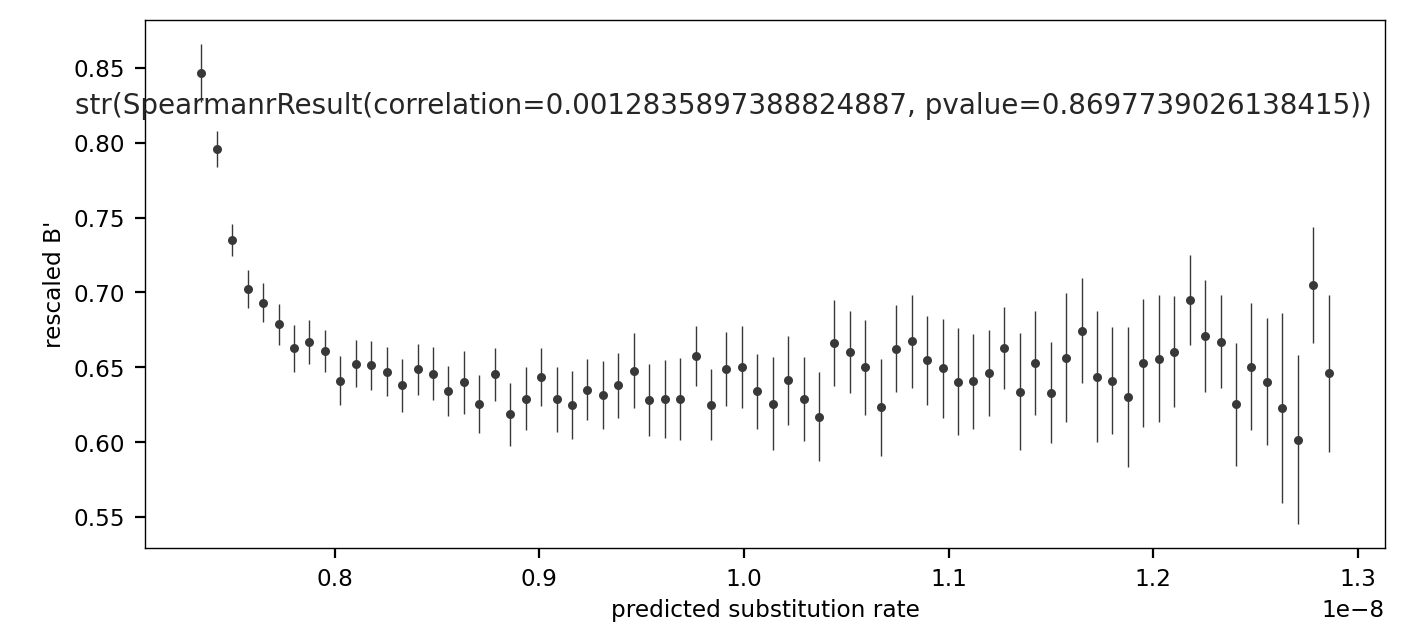

In [396]:
#binned_means_plot(binned_summaries(do['r_rs'].values, mean_ratio(do['B'].values), 75), min_n=10)
b_rs_stats = binned_summaries(do['r_rs'].values, do['B'].values, 75, cut_tails=(0, 0.9))
binned_means_plot(b_rs_stats, min_n=10)
plt.text(0, 1, f"str({corr(do['r_rs'].values, do['B'].values)[1]})",  transform=ax.transAxes)
plt.xlabel("predicted substitution rate")
plt.ylabel("rescaled B'")

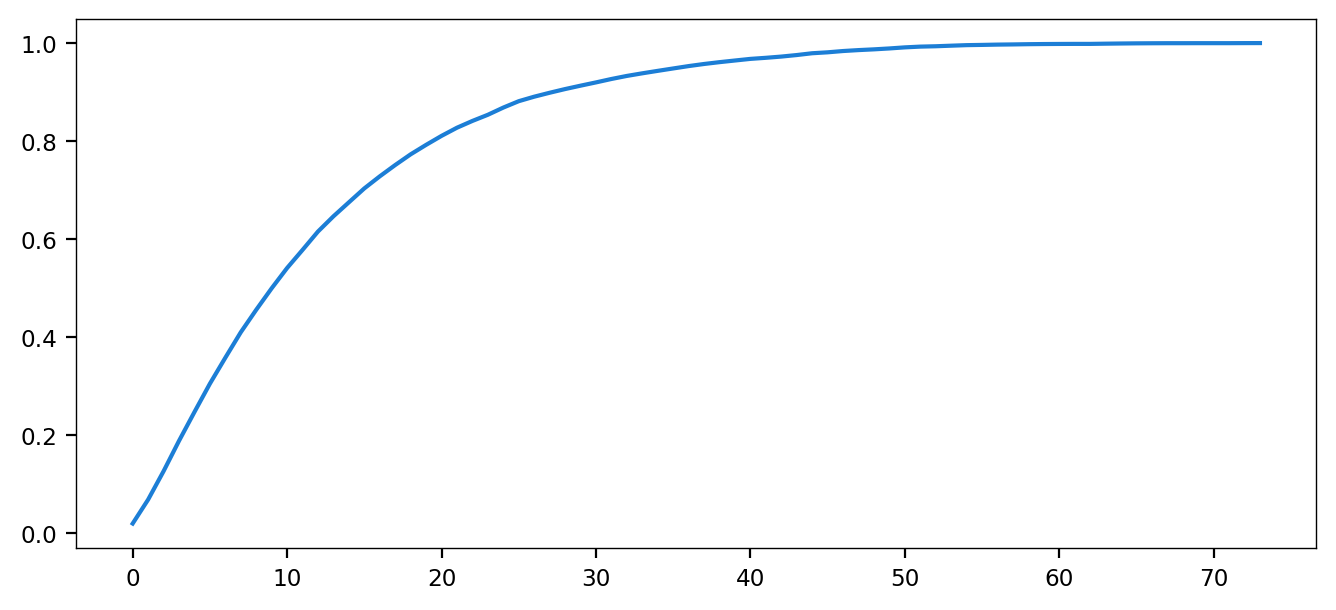

In [358]:
b_rs_stats['prop'] = [x/b_rs_stats['n'].sum() for x in b_rs_stats['n']]
plt.plot(np.cumsum(b_rs_stats['prop']))

Text(0.5, 0, "rescaled B'")

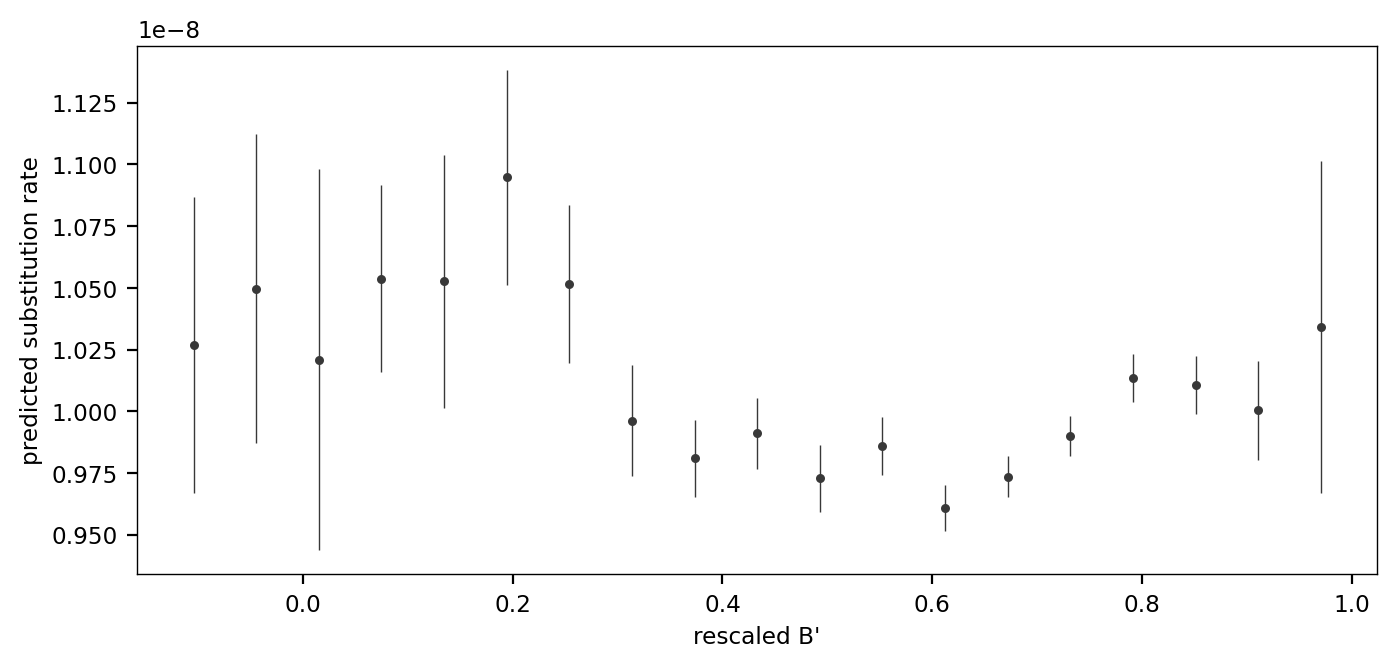

In [390]:
#binned_means_plot(binned_summaries(do['r_rs'].values, mean_ratio(do['B'].values), 75), min_n=10)
b_rs_stats = binned_summaries(do['B'].values, do['r_rs'].values, 25)
binned_means_plot(b_rs_stats, min_n=10)
plt.ylabel("predicted substitution rate")
plt.xlabel("rescaled B'")

### Prediction Model Fits

These are all here for completeness, but the important summary are the graphics in the next session.

In [63]:
import statsmodels.formula.api as smf
import statsmodels as sm

models = {}

site_types = ('total', 'syn', 'nonsyn')

for stype in site_types:
    models[stype] = {'pred_subrate + gc': smf.ols(f'{stype}_prop ~ r_rs_year + gc', data=do).fit(),
                    'pred_subrate': smf.ols(f'{stype}_prop ~ r_rs_year', data=do).fit(),
                    'gc': smf.ols(f'{stype}_prop ~ gc', data=do).fit()}

In [64]:
for model, res in models['syn'].items():
    print(f"\n########### {model} ###########\n")
    print(res.summary())


########### pred_subrate + gc ###########

                            OLS Regression Results                            
Dep. Variable:               syn_prop   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     129.8
Date:                Tue, 17 Jan 2023   Prob (F-statistic):           1.15e-56
Time:                        10:57:54   Log-Likelihood:                 57547.
No. Observations:               16316   AIC:                        -1.151e+05
Df Residuals:                   16313   BIC:                        -1.151e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

In [65]:
for model, res in models['nonsyn'].items():
    print(f"\n########### {model} ###########\n")
    print(res.summary())


########### pred_subrate + gc ###########

                            OLS Regression Results                            
Dep. Variable:            nonsyn_prop   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     355.8
Date:                Tue, 17 Jan 2023   Prob (F-statistic):          5.60e-152
Time:                        10:57:54   Log-Likelihood:                 74632.
No. Observations:               16316   AIC:                        -1.493e+05
Df Residuals:                   16313   BIC:                        -1.492e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

In [66]:
for model, res in models['total'].items():
    print(f"\n########### {model} ###########\n")
    print(res.summary())


########### pred_subrate + gc ###########

                            OLS Regression Results                            
Dep. Variable:             total_prop   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     351.1
Date:                Tue, 17 Jan 2023   Prob (F-statistic):          5.00e-150
Time:                        10:57:55   Log-Likelihood:                 71787.
No. Observations:               16316   AIC:                        -1.436e+05
Df Residuals:                   16313   BIC:                        -1.435e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

In [67]:
for stype in site_types:
    print(f"## {stype} ##")
    print(sorted({m: r.aic for m, r in models[stype].items()}.items(), key=lambda x: x[1] ))
    print("\n")

## total ##
[('pred_subrate + gc', -143567.40839077177), ('pred_subrate', -143488.5416917804), ('gc', -143093.33131555014)]


## syn ##
[('pred_subrate + gc', -115087.33928260871), ('pred_subrate', -114995.1663387873), ('gc', -114987.67230768179)]


## nonsyn ##
[('pred_subrate + gc', -149257.83093936084), ('pred_subrate', -149256.46266610333), ('gc', -148628.7972496686)]




### Model Prediction Checks and Graphics

Note: I narrow the x-axis a bit; part of the purpose of the figure is to show the good fit of the model, but this just shows the tail of high GC windows.

#### Cross-validation of number of bins

In [69]:
kf_res_quantile = bin_kfolds(do['r_rs_year'], do['total_prop'], method='quantile')

In [70]:
kf_res_interval = bin_kfolds(do['r_rs_year'], do['total_prop'], bins=np.arange(5, 100, 1))

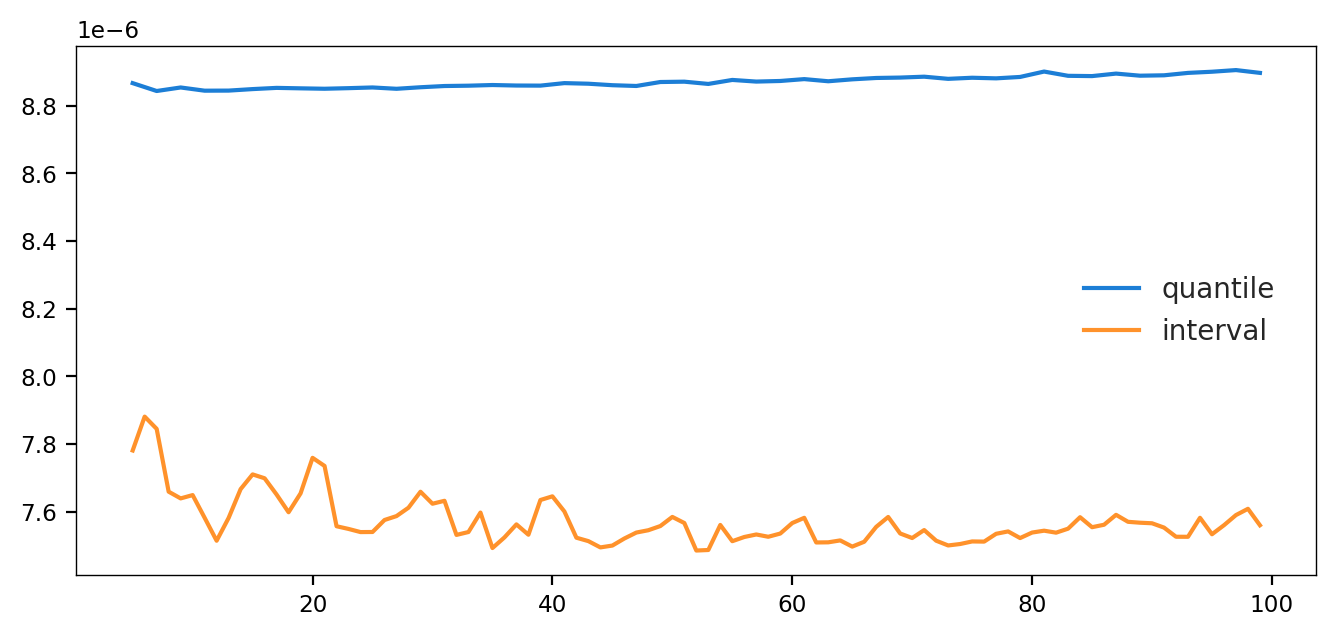

In [71]:
plt.plot(*kf_res_quantile, label='quantile')
plt.plot(*kf_res_interval, label='interval')
plt.legend()

Quantile binning sucks, let's stick with interval.

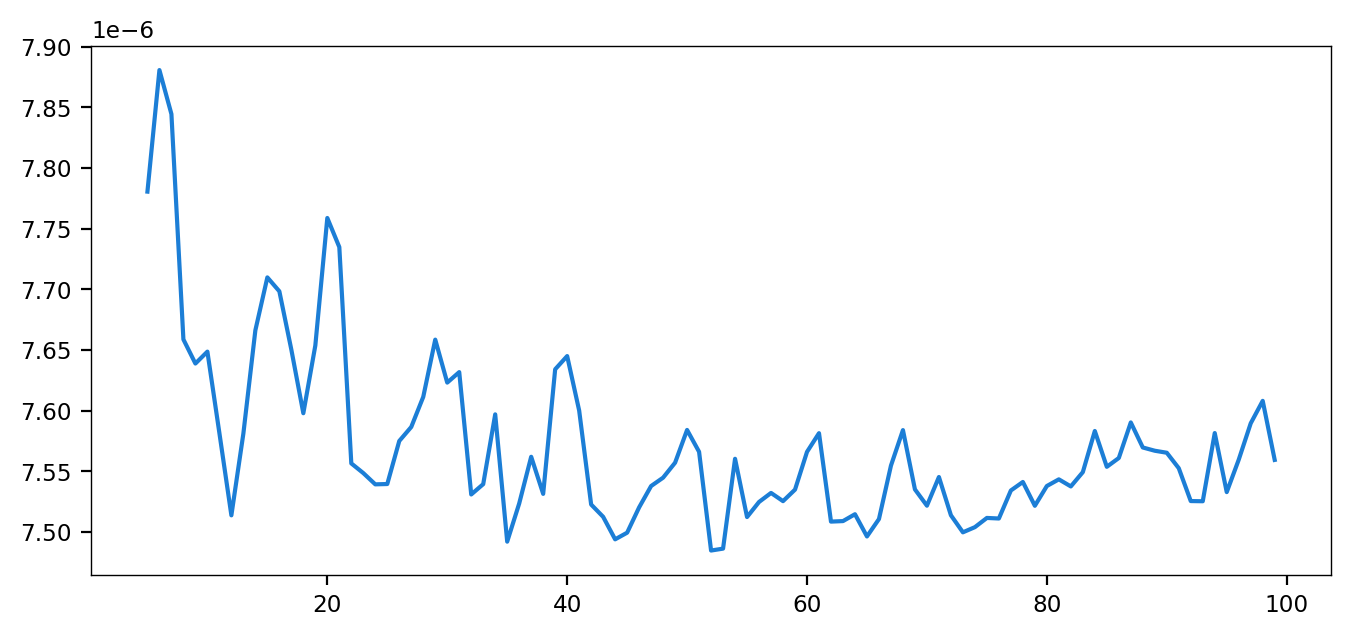

In [72]:
plt.plot(*kf_res_interval)

In [74]:
nbin = kf_res_interval[0][np.argmin(kf_res_interval[1])]
nbin

52

What if we cut off the tails? 

In [380]:
kf_res_interval_cuttails = bin_kfolds(do['r_rs_year'], do['total_prop'], bins=np.arange(5, 100, 2), cut_tails=(0, 0.90))

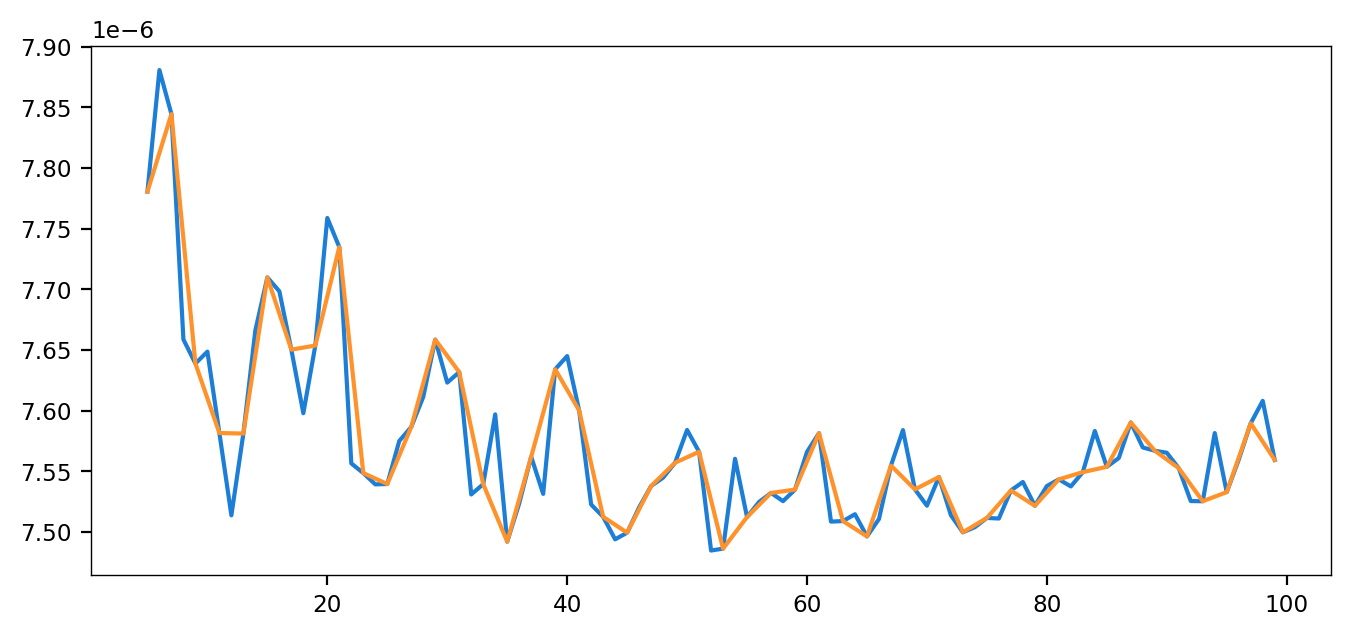

In [381]:
plt.plot(*kf_res_interval)
plt.plot(*kf_res_interval_cuttails)

Note: we thin the number of bins shown for visualize clarity.

/tmp/ipykernel_57592/3651027811.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gcdf = do.groupby('bins')['r_rs_year', 'gc', 'total_prop'].mean().reset_index()


(<Figure size 1600x700 with 1 Axes>,
 <AxesSubplot: title={'center': 'all substitutions'}>)

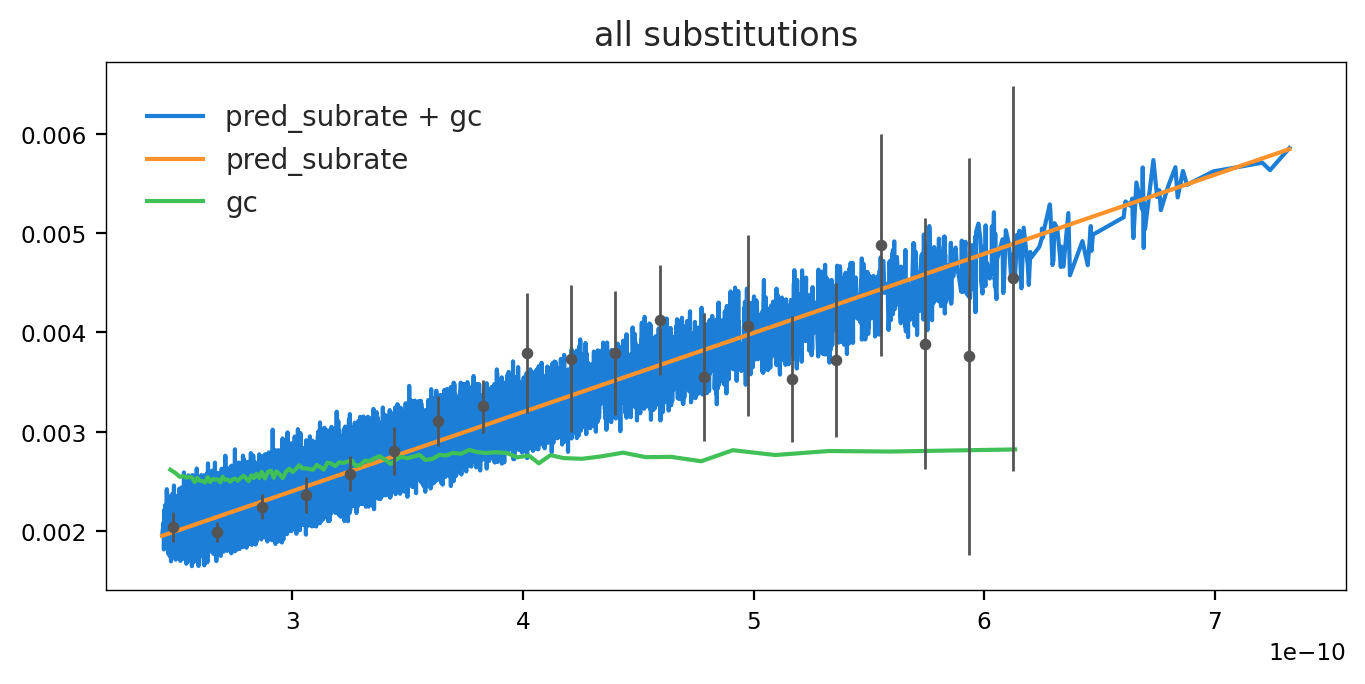

In [78]:
fig, ax = plt.subplots()
ax.set_title("all substitutions")

for model, res in models['total'].items():
      
    if model == 'gc':
        do['bins'] = pd.qcut(do['r_rs_year'], 100)
        gcdf = do.groupby('bins')['r_rs_year', 'gc', 'total_prop'].mean().reset_index()
        intercept, slope = res.params
        gcdf['pred'] = res.predict(pd.DataFrame(dict(gc=gcdf['gc'])))
        plt.plot(gcdf['r_rs_year'], gcdf['pred'], label=model)
    else:
        f = res.model
        exog_names = np.array(f.exog_names)
        x = f.exog[:, exog_names == 'r_rs_year'].flat
        y = res.fittedvalues.values
        idx = np.argsort(x)
        ax.plot(x[idx], y[idx].flat, label=model)

ax.legend()

binned_means_plot(binned_summaries(do['r_rs_year'], do['total_prop'], nbin), figax=(fig, ax), linewidth=1, s=10, c='0.33', thin=2, min_n=10)


Note that the bad fit is a result of those being outliers; remember the underlying data density!

In [80]:
np.quantile(do['r_rs_year'], 0.95)

4.841347211666667e-10

/tmp/ipykernel_57592/1407114972.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gcdf = do.groupby('bins')['r_rs_year', 'gc', 'nonsyn_prop'].mean().reset_index()


(<Figure size 1600x700 with 1 Axes>,
 <AxesSubplot: title={'center': 'non-synonymous'}>)

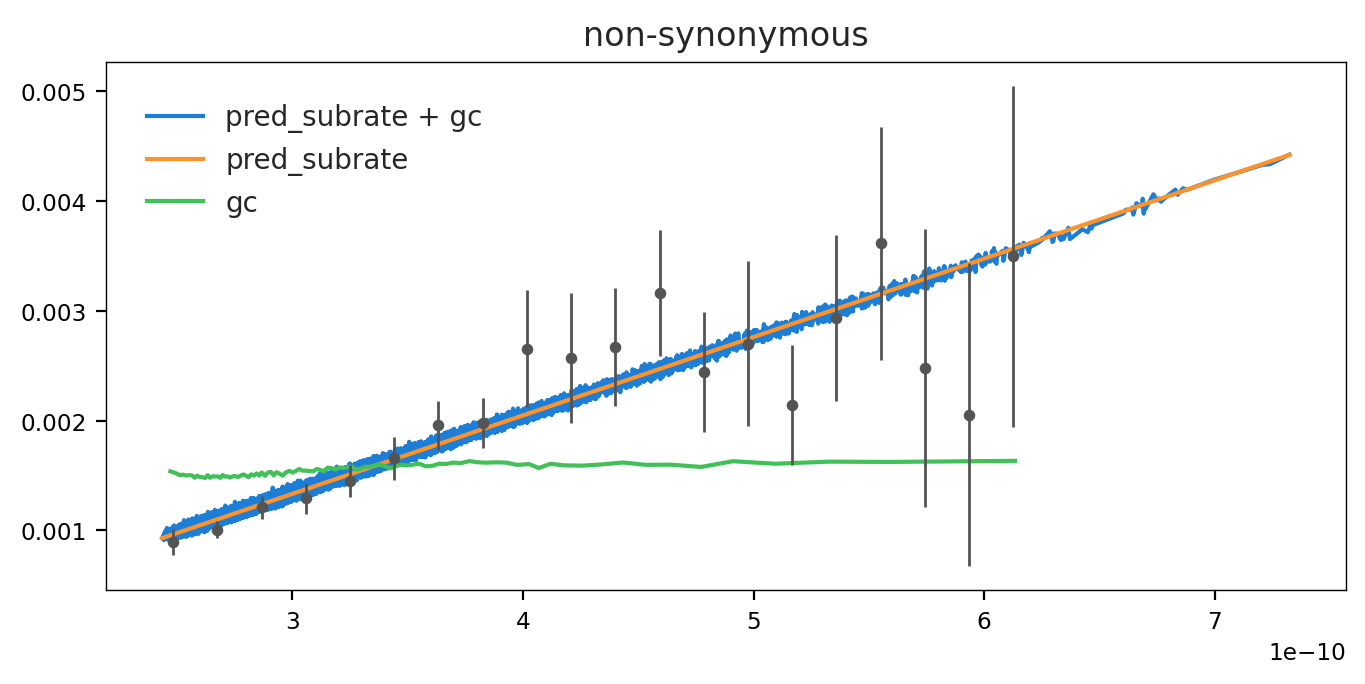

In [81]:
fig, ax = plt.subplots()
ax.set_title("non-synonymous")

for model, res in models['nonsyn'].items():
      
    if model == 'gc':
        do['bins'] = pd.qcut(do['r_rs_year'], 100)
        gcdf = do.groupby('bins')['r_rs_year', 'gc', 'nonsyn_prop'].mean().reset_index()
        intercept, slope = res.params
        gcdf['pred'] = res.predict(pd.DataFrame(dict(gc=gcdf['gc'])))
        plt.plot(gcdf['r_rs_year'], gcdf['pred'], label=model)
    else:
        f = res.model
        exog_names = np.array(f.exog_names)
        x = f.exog[:, exog_names == 'r_rs_year'].flat
        y = res.fittedvalues.values
        idx = np.argsort(x)
        ax.plot(x[idx], y[idx].flat, label=model)

ax.legend()

binned_means_plot(binned_summaries(do['r_rs_year'], do['nonsyn_prop'], nbin), figax=(fig, ax), linewidth=1, s=10, c='0.33', thin=2, min_n=10)


/tmp/ipykernel_57592/2162700510.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gcdf = do.groupby('bins')['r_rs_year', 'gc', 'syn_prop'].mean().reset_index()


(<Figure size 1600x700 with 1 Axes>,
 <AxesSubplot: title={'center': 'synonymous'}>)

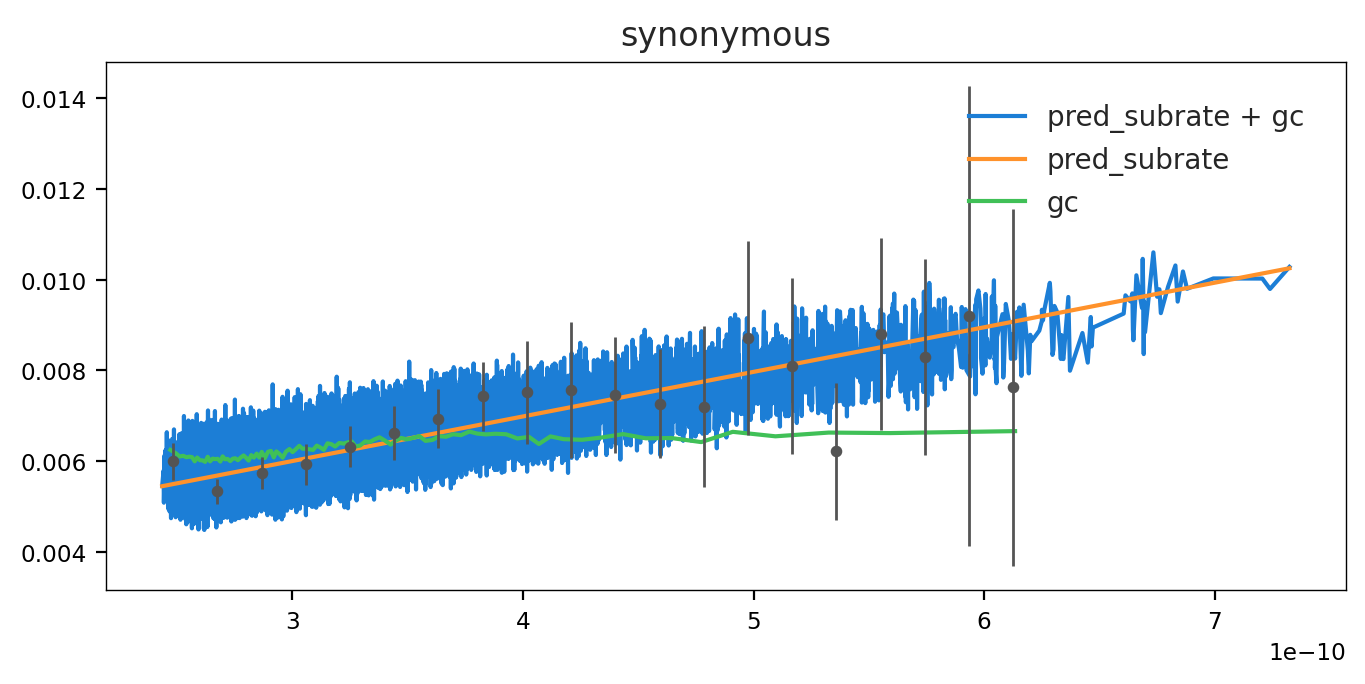

In [82]:
fig, ax = plt.subplots()
ax.set_title("synonymous")
for model, res in models['syn'].items():
      
    if model == 'gc':
        do['bins'] = pd.qcut(do['r_rs_year'], 100)
        gcdf = do.groupby('bins')['r_rs_year', 'gc', 'syn_prop'].mean().reset_index()
        intercept, slope = res.params
        gcdf['pred'] = res.predict(pd.DataFrame(dict(gc=gcdf['gc'])))
        plt.plot(gcdf['r_rs_year'], gcdf['pred'], label=model)
    else:
        f = res.model
        exog_names = np.array(f.exog_names)
        x = f.exog[:, exog_names == 'r_rs_year'].flat
        y = res.fittedvalues.values
        idx = np.argsort(x)
        ax.plot(x[idx], y[idx].flat, label=model)

ax.legend()

binned_means_plot(binned_summaries(do['r_rs_year'], do['syn_prop'], nbin), figax=(fig, ax), linewidth=1, s=10, c='0.33', thin=2, min_n=10)


### KDE Plots

#### Plot Function

In [284]:
import seaborn as sns
from bgspy.utils import pretty_signif


def sub_kde_plot(pred, prop_sub, T_HCs=None, nbins=None, thin=None, xlim=None, ylim=None, 
                 kde=True, scatter=False,
                 T_lw=None, fit_lw=None, tick_fontsize=None, xaxis_scaler=None,
                 show_outliers=True, fit=None, T_HC_labx=None,
                 label_fontsize = None, theory=None,
                 ylabel=None,
                 error_lw=None, error_s=None, error_c='0.22',
                 thc_c='0.44',
                 cmap="Reds", label_size=None, figax=None):
    fig, ax = get_figax(figax)
    xx, yy = pred, prop_sub
    if kde:
        # remove 0s for KDE
        xx_nozero, yy_nozero = xx, yy + yy[yy>0].min()
        print(f"adding {yy[yy>0].min()} to all sub rates for log scale")
        kde = sns.kdeplot(x=xx_nozero, y=yy_nozero, cmap=cmap, shade=True, bw_adjust=.5, ax=ax, log_scale=(None, 10), 
                          alpha=1, bw_method=0.3, zorder=-1)

        kde_layers = [c for c in kde.get_children() if isinstance(c, mpl.collections.PathCollection)]
        if show_outliers:
            ax.scatter(x=xx, y=yy, s=0.2, c=kde_layers[-3].get_facecolor(), zorder=-10, alpha=0.1)
            
    if scatter:
        ax.scatter(x=xx, y=yy, c='0.22', s=0.2, alpha=1)
        
    xl = ax.get_xlim()
    rate_grid = np.linspace(xl[0], xl[1], 100)
    
    # plot the fit
    if fit is not None:
        # fit a simple model here
        #slope, intercept, r, p, se = stats.linregress(xx, yy)           
        intercept, slope = fit
        #print(f"slope est = {slope}")
        ax.plot(rate_grid, intercept + slope*rate_grid, c='darkorange', linewidth=fit_lw)        
        
    if nbins is not None:
        df = binned_summaries(xx, yy, nbins=nbins)
        x = df['midpoint'].values
        n = df['n'].values
        stat = 'mean'
        linewidth = 0.8
        mean, sd = df[stat].values, df['sd'].values
        ax.scatter(x[::thin], mean[::thin], c=error_c, s=error_s, alpha=1, zorder=10)
        ax.errorbar(x[::thin], mean[::thin], (2*sd/np.sqrt(n))[::thin], fmt='none', c=error_c, elinewidth=error_lw, zorder=10)
    

    if tick_fontsize is not None:
        ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
        

    if xlim is not None:
        xlim = list(xlim)
        if xlim[0] is None:
            xlim[0] = xl[0]
        if xlim[1] is None:
            xlim[1] = xl[1]            
        ax.set_xlim(*xlim)

    if ylim is not None:
        yl = list(ax.get_ylim())
        ylim = list(ylim)
        if ylim[0] is None:
            ylim[0] = yl[0]
        if ylim[1] is None:
            ylim[1] = yl[1]            
        ax.set_ylim(*ylim)
    
    if xaxis_scaler is not None:
        xticks = ax.axes.get_xticks()[1:]
        ax.axes.set_xticks([x for x in xticks])
        ax.axes.set_xticklabels([pretty_signif(x*xaxis_scaler) for x in xticks])
    
    ax.set_xlabel("predicted substitutions/year ($\\times 10^{-10}$)")

    if label_fontsize is not None:
        for item in [ax.title] + ax.get_xticklabels() + ax.get_yticklabels():
            item.set_fontsize(label_fontsize)
        ax.xaxis.label.set_fontsize(label_fontsize)
        ax.yaxis.label.set_fontsize(label_fontsize)        
        

    def scale_neutral(sub):
        gen_time = 30
        neut_mu_years = 1.3e-8 / gen_time
        return 100 * sub/neut_mu_years

    def neutral_to_sub(neut):
        return neut

    # add the second axis scale, fraction of neutral sub rate
    sec_x = ax.secondary_xaxis('bottom', functions=(scale_neutral, neutral_to_sub))
    for item in sec_x.get_xticklabels():
        item.set_fontsize(6)
        item.set_color('0.44')
    sec_x.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0))

    sec_x.xaxis.set_tick_params(direction="in", pad=-10, size=3, color='0.44', zorder=2)
    
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)

    if theory is not None:
        T, beta = theory
        ax.plot(rate_grid, T*(1-beta)*rate_grid, c='red', # c='0.33', 
                    linewidth=fit_lw)
    
    #plt.tight_layout(w_pad=0.01)
    if T_HCs is not None:
        for i, T in enumerate(sorted(T_HCs)):
            ax.plot(rate_grid, T*rate_grid, c=thc_c, 
                    linestyle='dashed', linewidth=T_lw)
            if T_HC_labx is not None:
                labx = T_HC_labx
                j = np.argmin(np.abs(rate_grid - labx))
                ypos = T*rate_grid[j]
                #offset = np.log10(ypos) * 1e-5
                #offset = -10 * offset if i == 0 else offset
                val = pretty_signif(T/1e6)
                rise, run = ((T*rate_grid[j+1] - T*rate_grid[j-1])), (rate_grid[j+1] - rate_grid[j-1])

                b = np.rad2deg(np.arctan2(rise, run))

                angle_screen = ax.transData.transform_angles((b, ), np.array([labx, ypos]).reshape(1, 2))[0]
                valn = 'top' if i == 1 else 'bottom'
                # ax.text(labx, ypos, f"$T_{{HC}} = {val}$ Mya", 
                #         horizontalalignment='center',
                #         verticalalignment=valn,
                #         rotation=b_screen[0], fontsize=label_size)
                offset = -1 if i == 0 else 1
                va = 'bottom' if i == 1 else 'top'
                ax.annotate(f"$T_{{HC}} = {val}$ Mya", c=thc_c,
                            xy=(labx, ypos), xytext=(0, offset), textcoords="offset points", 
                            ha='center', va=va,
                            rotation_mode='anchor', rotation=angle_screen, fontsize=label_size)
    
    if ylabel is None:
        ax.set_ylabel("substitutions/site")
    else:
        ax.set_ylabel(ylabel)
    return fig, ax

#### Substitution Proportions by Predicted Substitution Rates

adding 0.0004930966469428 to all sub rates for log scale


/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/seaborn/_core.py:1165: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.3":
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/seaborn/palettes.py:443: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/seaborn/_core.py:1165: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.3":
/home/vsb/miniconda3/envs/bprime/lib/pytho

adding 8.568490803153203e-05 to all sub rates for log scale


/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/seaborn/palettes.py:443: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/seaborn/_core.py:1165: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.3":
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


adding 0.0001188777936281 to all sub rates for log scale


/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/seaborn/palettes.py:443: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


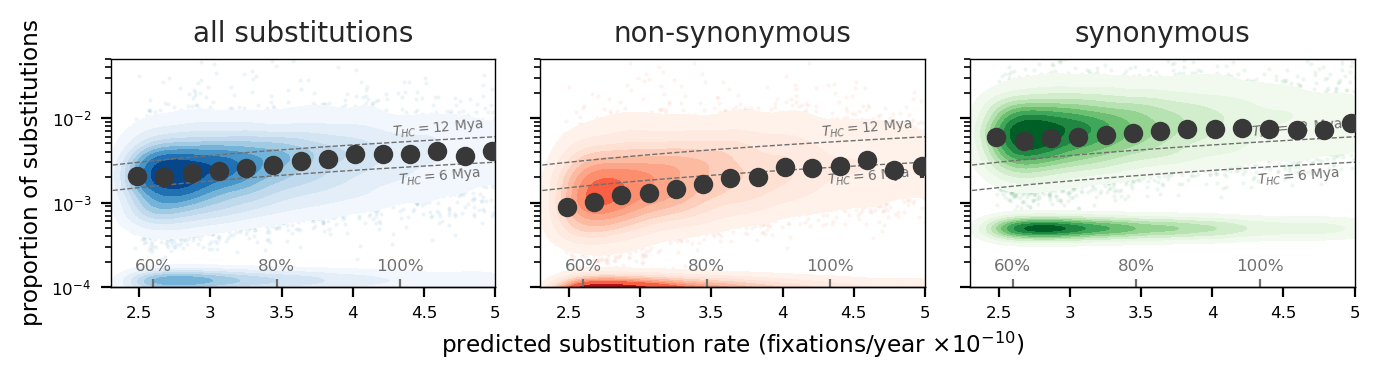

In [85]:
lw = 0.5
flw = 1
tfs = 6
ls = 5
lax = 4.6e-10
xlim = (2.3e-10, 5e-10)

T_HCs_np = np.array(T_HCs)

fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(7, 2))

sub_kde_plot(x_rs, syn_prop, T_HCs=T_HCs_np, xlim=xlim, 
             ylim=(1e-4, 5.04e-2),
             cmap='Greens', 
             xaxis_scaler=1e10,
             nbins=nbin,
             thin=2,             
             T_HC_labx=lax,
             label_size=ls,
             T_lw=lw, fit_lw=flw,
             tick_fontsize=tfs,
             #ylim=(1e-3, 5e-2), 
             figax=(fig, ax[2]))
sub_kde_plot(x_rs, nonsyn_prop, T_HCs=T_HCs_np, xlim=xlim, 
             ylim=(1e-4, 5.04e-2),             
             nbins=nbin,
             thin=2,             
             xaxis_scaler=1e10,
             label_size=ls,
             T_HC_labx=lax,             
             T_lw=lw, fit_lw=flw,
             tick_fontsize=tfs,
             #ylim=(1e-4, 5e-2), 
             figax=(fig, ax[1]))
sub_kde_plot(x_rs, total_prop, T_HCs=T_HCs_np, xlim=xlim, 
             ylim=(1e-4, 5.04e-2),             
             nbins=nbin,   
             thin=2,
             xaxis_scaler=1e10,
             label_size=ls,
             T_HC_labx=lax,        
             theory=None,
             T_lw=lw, fit_lw=flw,
             tick_fontsize=tfs,
             #ylim=(2e-4, 4e-2), 
             cmap='Blues', figax=(fig, ax[0]))

#ax[0].set_ylabel("proportion of substitutions\non human lineage")
ax[0].set_ylabel("proportion of substitutions")
ax[1].set_ylabel("")
ax[2].set_ylabel("")
ax[0].set_xlabel("")
ax[1].set_xlabel("predicted substitution rate (fixations/year $\\times 10^{-10}$)")
ax[2].set_xlabel("")

ax[2].set_title("synonymous", fontsize=10)
ax[1].set_title("non-synonymous", fontsize=10)
ax[0].set_title("all substitutions", fontsize=10)


#ax[2].axhline((1.3e-8 / gen_time) * T_HCs[0], linestyle='dashed', c='0.33', linewidth=lw)
#ax[2].axhline((1.3e-8 /gen_time) * T_HCs[1], linestyle='dashed', c='0.33', linewidth=lw)

# ax[0].annotate("$T_{HC} = 12$ Mya, $\\beta = 0.8$",   (2.6e-10, 3e-3), (2.9e-10, 2e-2),
#                fontsize=6, c='r', 
#                arrowprops=dict(color='r', arrowstyle='-|>', connectionstyle="arc3,rad=0.5"),
#                ha="left")
plt.tight_layout()

#plt.savefig('../manuscript/figures/kde_panel.pdf')

### Bar plot of Effects

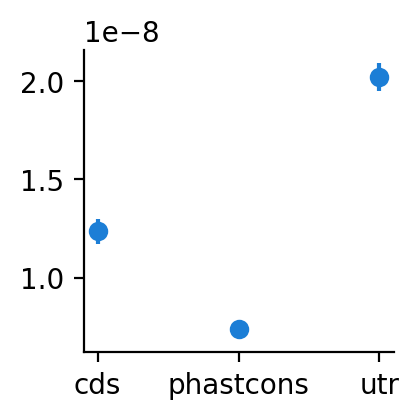

In [238]:
sr_stats = dsr_rs.groupby(['feature'], as_index=False).agg({'r_rs': ['mean', 'std']}).reset_index()

fig, ax = plt.subplots(figsize=(2, 2))
ax.errorbar(sr_stats[('feature', '')], sr_stats[('r_rs', 'mean')], 2*sr_stats[('r_rs', 'std')], fmt='none')
ax.scatter(sr_stats[('feature', '')], sr_stats[('r_rs', 'mean')])

### Rough Estimates of the Fraction of Sites Capable of Substitions

Some back-of-the-envelope calculations on the possible estimate of the substitutional sieve.

My notation is as follows. The number of *actual* substitutions, not *observed substitutions* (i.e. from sequence comparison) is $K$. $\beta$ is the fraction of sites which cannot tolerate a mutation, thus $1-\beta$ is the fraction of sites that can take a substitution. Our predicted substitution rate is $\lambda_d$, and the beneficial rate (unknown) is $\lambda_b$.

$$
K = (1-\beta)T(\lambda_d + \lambda_b)
$$

Note that $K = K_N + K_S$.

The fraction of beneficial non-synonmous substitutions is $\alpha$, e.g. $\alpha K_N$ is the fraction of substitutions driven by positive selection.

Note that this is *not* the fraction of substitutions with $s > 0$, as many of these are nearly neutral. We know, however, that $1-\alpha$ non-synonmous mutations TODO HERE

Our predictions are $\lambda_d$ estimates; hereafter these are $x$ to indicate that we treat them as the x in a linear regression.
Also, we denote $y = K$ as $y$ is the proportion of substitutions on the human lineage.

Assuming $\lambda_d >> \lambda_b$,

$$
y =  (1-\beta) T x
$$

we define $\gamma = (1-\beta) T$ as the slope parameter. Our estimate is

$$
y = \gamma x + c 
$$
 
where we use $c$ as an extra degree of freedom to better estimate the slope. 

Then, a rough estimator of $\hat{\beta}$ is 

$$
\hat{\beta} = 1-\hat{\gamma}/T
$$

Alternatively, if we knew $\beta$, we could estimate $T$,

$$
T = \frac{\hat{\gamma}}{1-\beta}
$$


#### Dn/Ds Analysis

In [160]:
# only consider finite values
dnds = do['dnDs'].values
finite = np.isfinite(dnds)
x_rs_year_dnds, dnds = x_rs.values[finite], dnds[finite]
x_unscaled_dnds = do['r'].values[finite]

In [373]:
# upper limit figurd out from a grid of larger steps up to 100
kf_dnds = bin_kfolds(x_rs_dnds, dnds, method='interval', bins=np.arange(5, 50, 1), cut_tails=(0, 0.90))

In [371]:
kf_dnds_nocut = bin_kfolds(x_rs_dnds, dnds, method='interval', bins=np.arange(5, 50, 1), cut_tails=None)

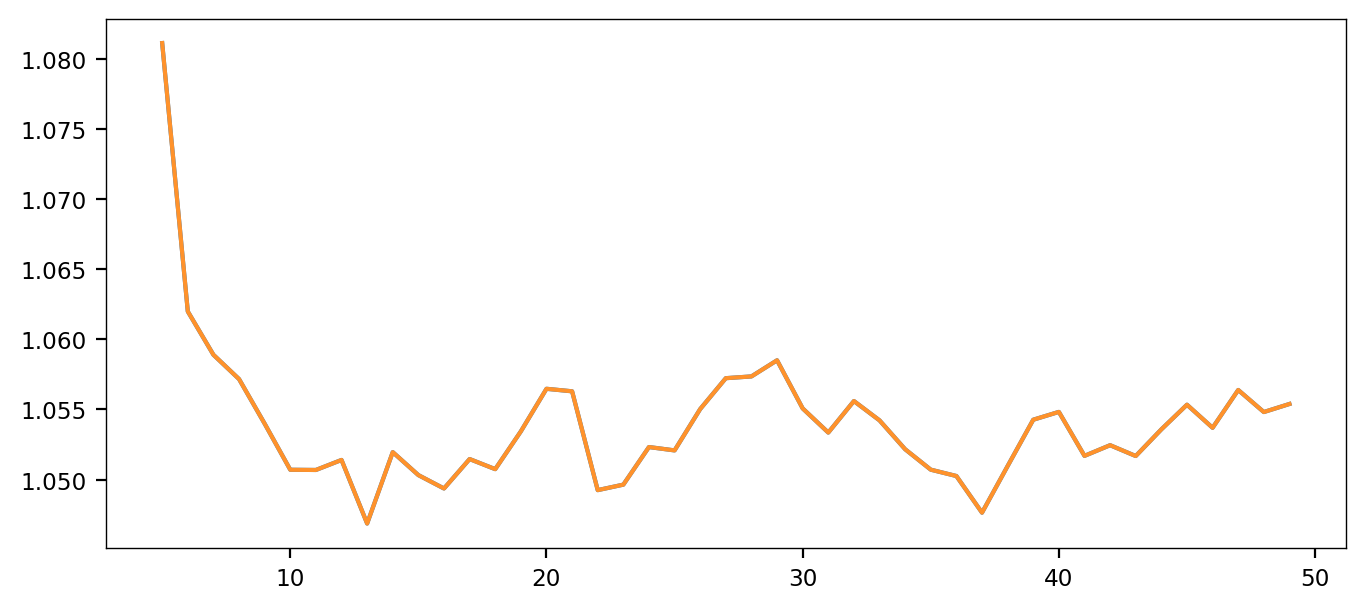

In [374]:
plt.plot(*kf_dnds)
plt.plot(*kf_dnds_nocut)

In [376]:
kf_dnds[0][np.argmin(kf_dnds[1])]

13

In [377]:
dnds_bins = binned_summaries(x_rs_dnds, dnds, 13)
dnds_bins.head()

start           end      midpoint      mean  median        sd  \
0  2.843884e-10  2.436668e-10  2.640276e-10  0.660211   0.375  0.944625   
1  3.251101e-10  2.843884e-10  3.047492e-10  0.780265   0.500  1.068828   
2  3.658317e-10  3.251101e-10  3.454709e-10  0.860117   0.500  1.088830   
3  4.065533e-10  3.658317e-10  3.861925e-10  0.962719   0.625  1.198805   
4  4.472749e-10  4.065533e-10  4.269141e-10  1.058367   1.000  1.252239   

        n  
0  4112.0  
1  3469.0  
2  2132.0  
3  1199.0  
4   647.0

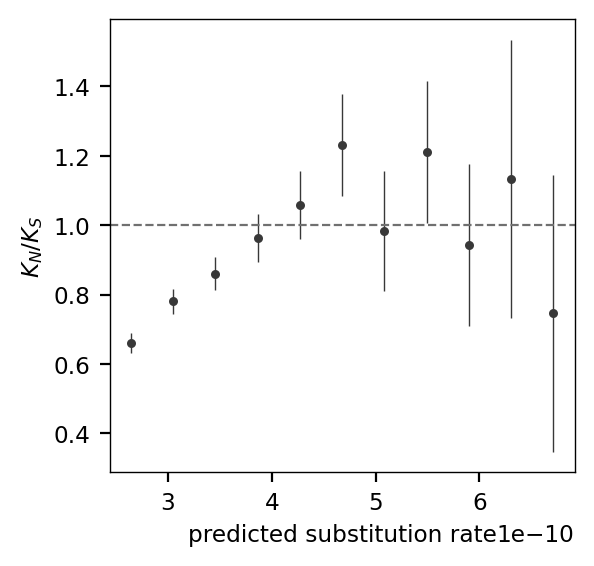

In [379]:
fig, ax = plt.subplots(figsize=(3, 3))

binned_means_plot(dnds_bins, figax=(fig, ax), min_n=10, thin=1)
ax.axhline(1, linestyle='dashed', c='0.44', linewidth=0.8)
ax.set_ylabel("$K_N/K_S$")
ax.set_xlabel("predicted substitution rate")

cut_point = np.quantile(x_rs, 0.95)
#ax.set_xlim(ax.get_xlim()[0], cut_point)
#ax.set_ylim(0.25, 1.75)

Note the `min_n` argument: the right-most bins are just small-n. We will ignore these.

In [167]:
# what do the un-rescaled ones look like?
dnds_unscaled_bins = binned_summaries(x_unscaled_dnds, dnds, 22)

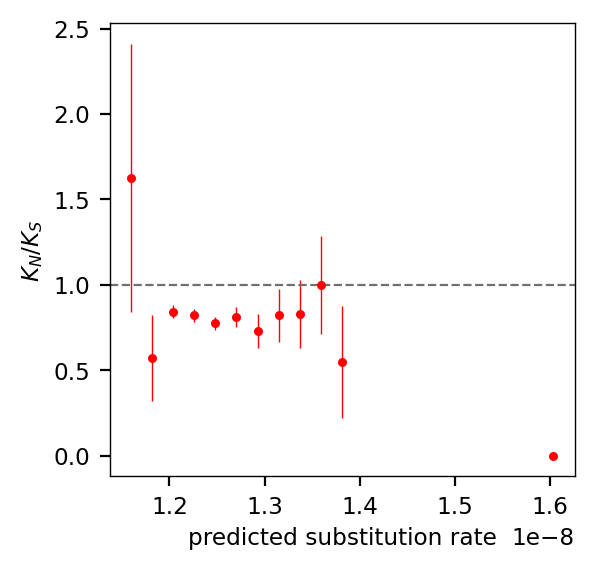

In [168]:
fig, ax = plt.subplots(figsize=(3, 3))

#binned_means_plot(dnds_bins, figax=(fig, ax), min_n=20, thin=1)
binned_means_plot(dnds_unscaled_bins, figax=(fig, ax), min_n=0, c='r')
ax.axhline(1, linestyle='dashed', c='0.44', linewidth=0.8)
ax.set_ylabel("$K_N/K_S$")
ax.set_xlabel("predicted substitution rate")

cut_point = np.quantile(x_rs, 0.95)
#ax.set_xlim(ax.get_xlim()[0], cut_point)
#ax.set_ylim(0.25, 1.75)

This looks odd to me — the rescaling is necessary. 

#### What is $\beta$?

In [171]:
BETA = 0.3

In [193]:
def est_beta(gamma, T):
    return 1 - gamma/T

def est_T(gamma, beta):
    return gamma / (1-beta)

In [194]:
intercept, slope = smf.ols('total_prop ~ r_rs_year', data=do).fit().params.values
intercept, slope

(9.824599448546837e-06, 7967329.978447142)

In [195]:
est_beta(slope, 12e6)

0.33605583512940485

In [93]:
est_beta(smf.ols('syn_prop ~ r_rs_year', data=do).fit().params.values[1], T_HCs), est_beta(smf.ols('nonsyn_prop ~ r_rs_year', data=do).fit().params.values[1], T_HCs)

NameError: name 'est_beta' is not defined

### Alternate generation time (29y)

In [953]:
do['r_rs_year29'] = d['r_rs'] / 29

In [970]:
bn_fit = smf.glm('total_prop ~ r_rs_year29', data=do.loc[do['r_rs_year'] < 5e-10], family=sm.api.families.Binomial()).fit()
bn_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             total_prop   No. Observations:                15670
Model:                            GLM   Df Residuals:                    15668
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -241.37
Date:                Mon, 16 Jan 2023   Deviance:                       32.930
Time:                        21:04:38   Pearson chi2:                     49.5
No. Iterations:                     9   Pseudo R-squ. (CS):          0.0001176
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -7.0960      0.850     -8.346      0.000      -8.763      -5.430
r_rs_year29  3.378e+09   2.42e+09      1.396      0.163   -1.36e+09    8.12e+09
===============================================================================
"""

In [972]:
from bgspy.substitution import JC69

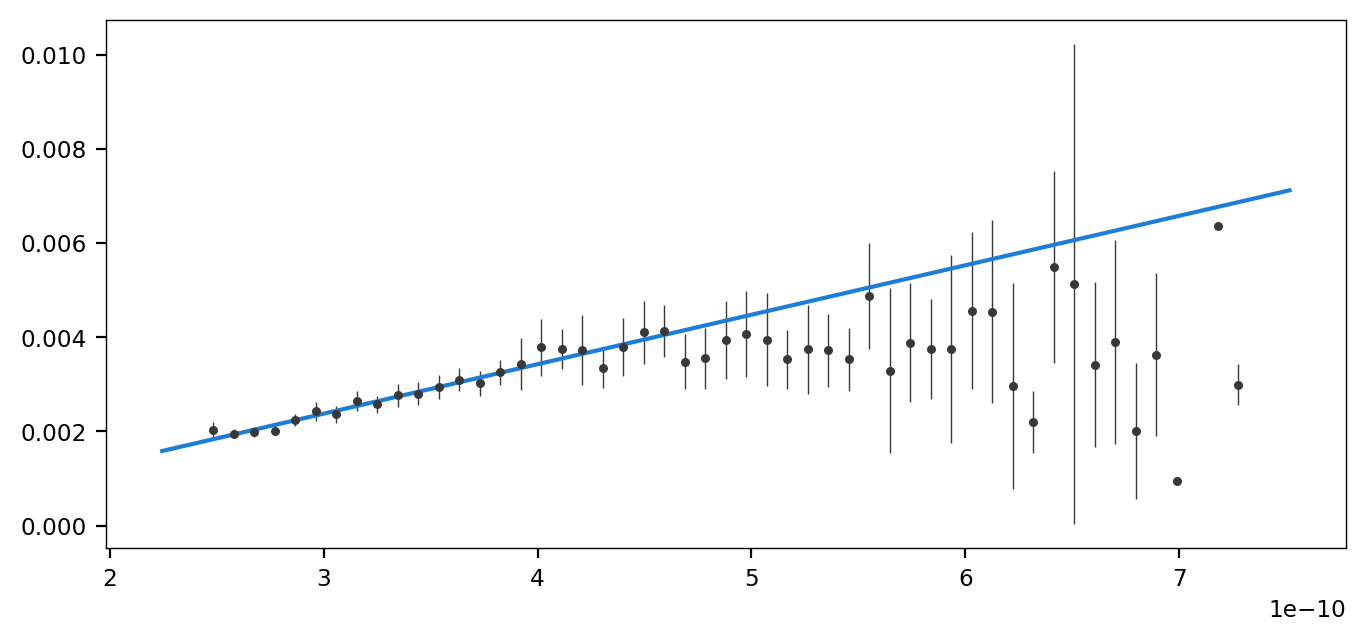

In [998]:
fig, ax = plt.subplots()
binned_means_plot(binned_summaries(x_rs, total_prop, nbin), figax=(fig, ax))
xp = np.linspace(*ax.get_xlim(), 100)
ax.plot(xp, censored_fit_params[0] + censored_fit_params[1] * xp)

In [980]:
(x_rs < 4e-10).mean()

0.8493503309634715

In [188]:
censored_fit_params = smf.ols('total_prop ~ r_rs_year', data=do.loc[do['r_rs_year'] < 4e-10]).fit().params.values

In [189]:
slope, censored_fit_params

(7967329.978447142, array([-7.73715349e-04,  1.05074298e+07]))

In [192]:
est_beta(censored_fit_params[1], 12e6)

NameError: name 'est_beta' is not defined

In [954]:
intercept, slope = smf.ols('total_prop ~ r_rs_year29', data=do).fit().params.values

In [1035]:
1/1.3

0.7692307692307692

In [997]:
est_beta(censored_fit_params[1], 12e6), est_T(censored_fit_params[1], 0.8)/1e6

(0.12438084821173578, 52.53714910729586)

In [958]:
beta_pollard = 0.5

In [960]:
slope/(1-beta_pollard) / 1e6

15.403504624997813

In [961]:
beta = 1 - (slope / T_HCs)
beta

array([-0.28362539,  0.35818731])

Now let's do a bootstrap of this.

In [1011]:
# check the two approaches give same results...
stats.linregress(x_rs, total_prop)[:2], smf.ols('total_prop ~ r_rs_year', data=do).fit().params.values

((7967329.978447149, 9.824599448543612e-06),
 array([9.82459945e-06, 7.96732998e+06]))

In [1015]:
def bootstrap_ols_fit(x, y, nboot):
    bs_slopes = np.zeros(nboot, dtype='int')
    n = len(x)
    for b in range(nboot):
        idx = np.random.randint(0, n, n)
        boot_fit = stats.linregress(x[idx], y[idx])
        slope, intercept, r, p, se = boot_fit
        bs_slopes[b] = slope
    return bs_slopes
        
bootstrap_ols_fit(x_rs, total_prop, 100).mean()

7991912.43

(array([ 1.,  4.,  6., 15., 33., 22.,  8.,  7.,  3.,  1.]),
 array([13.86800889, 14.32018444, 14.77236   , 15.22453556, 15.67671111,
        16.12888667, 16.58106222, 17.03323778, 17.48541333, 17.93758889,
        18.38976444]),
 <BarContainer object of 10 artists>)

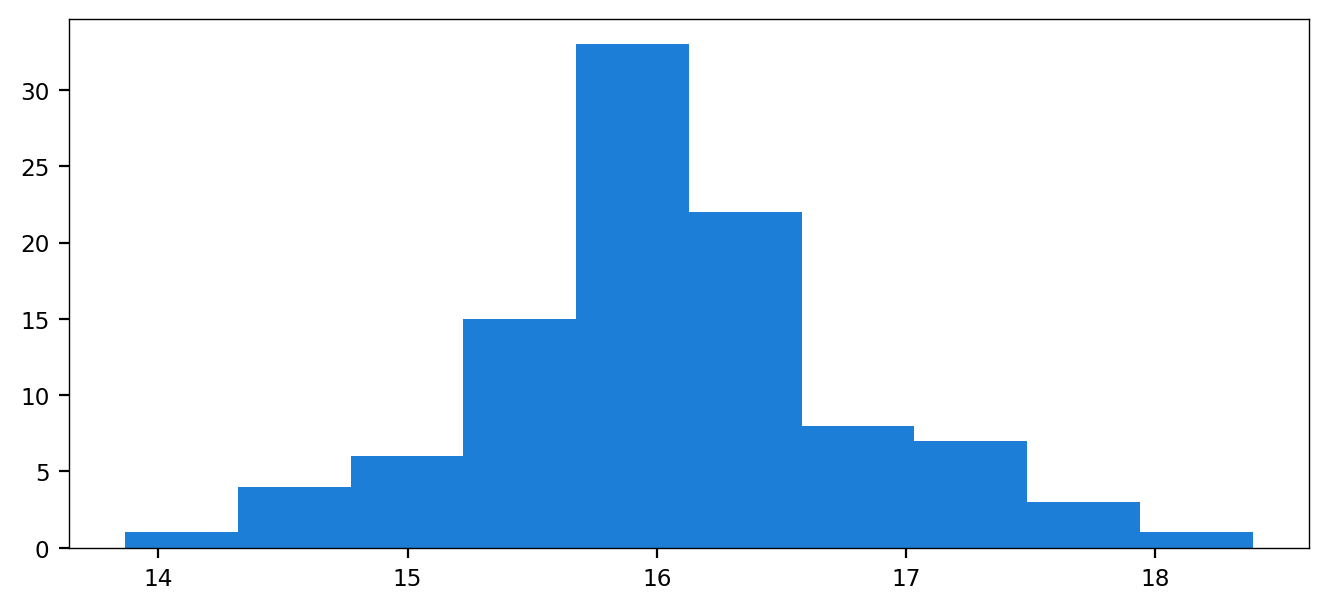

In [1040]:
plt.hist(est_T(bootstrap_ols_fit(x_rs*1.1, total_prop, 100), 0.55)/1e6)

In [1018]:
slope, est_beta(7991912.43, 12e6)

(7967329.978447142, 0.3340072975)

In [1024]:
## if we trust beta_CDS ~ 0.55

0.55 * 12e6

6600000.000000001

In [1026]:
(7991912.43 / 0.55) / 1e6

14.530749872727272

In [892]:
T_HCs = np.array(T_HCs)

(array([   9.,   87.,  435., 1448., 2635., 2874., 1770.,  634.,  101.,
           7.]),
 array([0.07879575, 0.10435044, 0.12990513, 0.15545983, 0.18101452,
        0.20656921, 0.2321239 , 0.25767859, 0.28323328, 0.30878797,
        0.33434267]),
 <BarContainer object of 10 artists>)

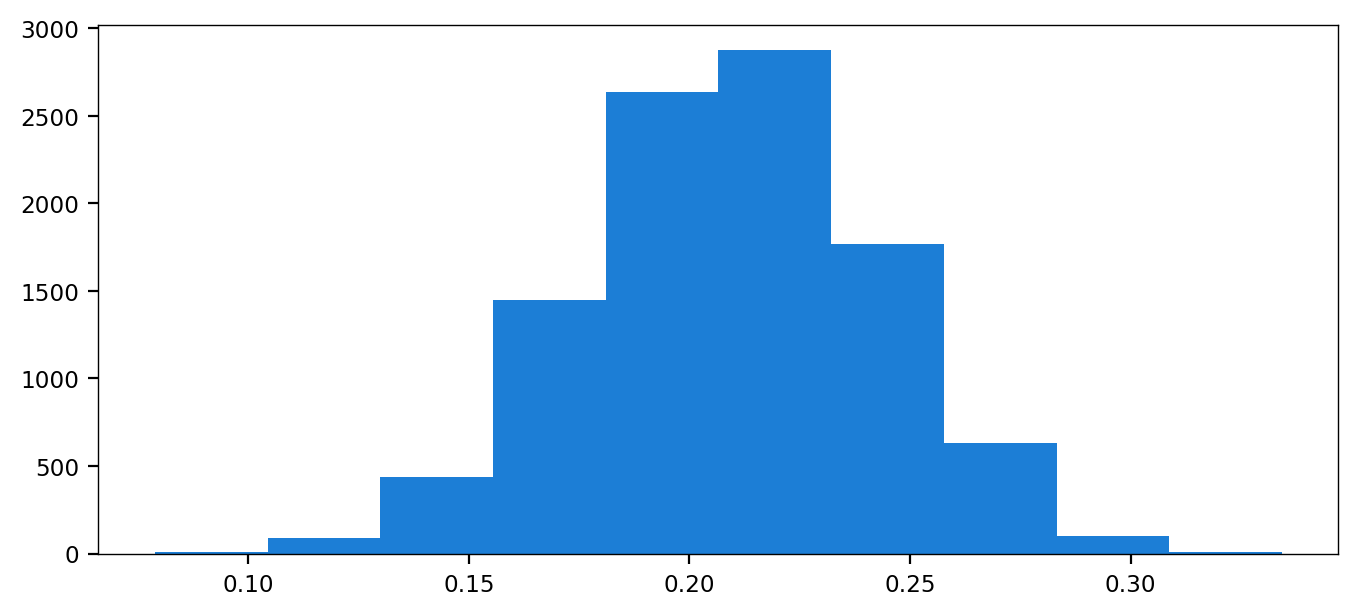

In [898]:
plt.hist(1 - (bs_slopes / T_HCs[1]))

**TODO** FIX BELOW

Hellman et al. (2003) divergence estimate is 0.45 for coding sequences, 1.09 for 4D sites, and 1.28 for intergenic sites.

A *very rough* estimator of the fraction of conserved sites is to assume that we have neutral evolution and evolution were some fraction of sites can't change, e.g. 

$$
K_n = \mu T
$$


$$
K_c = (1-\beta)\mu T
$$


$$
\beta = 1-K_c/K_n
$$

In [1019]:
Kn = np.array([1.09, 1.28])
Kc = 0.45
1 - Kc/Kn

array([0.58715596, 0.6484375 ])

So something like ~60% of sites are conserved. Again, this is very rough.

In Pollard et al. (2010), they estimate the fraction of conserved sites for different classes of sites. For the first, second, third positions of codons, they report the following fractions (Figure 4C). The emphasize this is a lower bound and approximate though in the caption.

In [1020]:
pollard_cds_cons_est = (np.array([65.5, 70.8, 24.6])/100).mean()
pollard_cds_cons_est

0.5363333333333333

Table 1 of Davydov et al (2010) suggests that 84.6% percent of exons are covered by a consered element.

In [1021]:
davydov_cds_cons_est = 0.846

What are the split times implied by these estimtes?

In [320]:
np.array([slope / pollard_cds_cons_est, slope / davydov_cds_cons_est]) / 1e6

array([18.36293946, 11.64143798])

For phastcons, Pollard et al report 87.9%. Our CDS include some phascons sites, since we prioritize genomic features. So the fraction above should be weighted by the overlap between phastcons and CDS.

I did the follow rough calculation to estimate the fraction of constrained sites:

```
$ bedtools intersect -b <(bedtools merge -i conserved_phastcons.bed.gz) -a <(bedtools merge -i hg38.ensembl_cds.bed.gz ) | \
    bioawk -cbed 'BEGIN {a=0} {a += $end-$start} END {print a}'

22878020

$ zcat hg38.ensembl_cds.bed.gz | grep -v chrX | bedtools merge | bioawk -cbed 'BEGIN {a=0} {a += $end-$start} END {print a}'
34261868
```

The overlap estimates are close, 91,486,641 and 91,485,992.

In [1059]:
frac_cds_phastcons = 22878020 / 34261868
frac_cds_phastcons

0.6677400076376454

In [323]:
est_pollard_frac_cons = frac_cds_phastcons * 87.9/100 + (1-frac_cds_phastcons)*pollard_cds_cons_est
est_pollard_frac_cons

0.7564471409829759

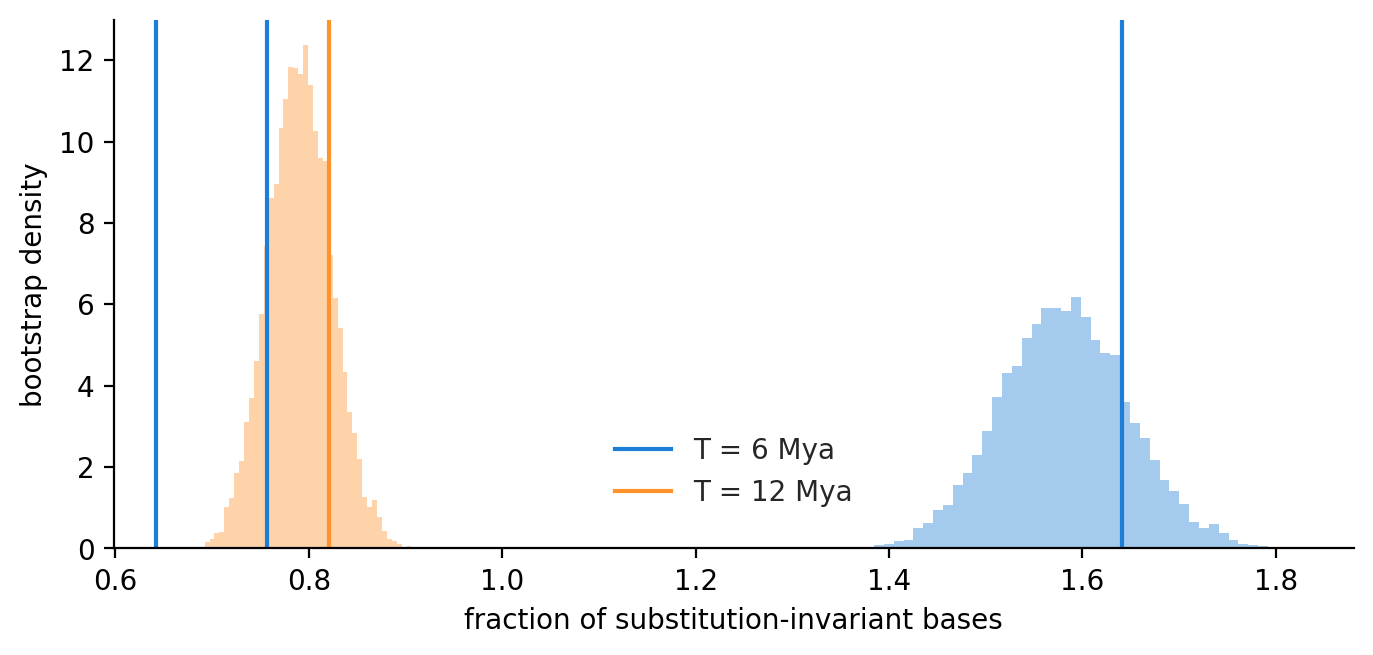

In [324]:
boot_ests = (bs_slopes / T_HCs[:, None]).T

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots()

labs = set()

for i, T in enumerate(T_HCs):
    c = colors[i]
    lines = ax.axvline(beta[i], label=f"T = {int(T/1e6)} Mya", color=c)
    _ = ax.hist(boot_ests[:, i], 50, density=True, color=c, alpha=0.4)

ax.legend()
ax.set_xlabel("fraction of substitution-invariant bases")
ax.set_ylabel("bootstrap density")

ax.axvline(est_pollard_frac_cons)
ax.axvline(frac_cds_phastcons)

### Main Substitution Figure

Note: I add a small correction factor so the y-scale can be logged. This is the smallest observed substitution rate in a gene.

Earlier versions were removing 0s but this is wrong!

In [87]:
fit_params = models['total']['pred_subrate'].params.values
fit_params

array([9.82459945e-06, 7.96732998e+06])

In [88]:
MU_EST = bpfit_sm.mle_mu
MU_EST

3.205541960151368e-08

<>:3: DeprecationWarning: invalid escape sequence \h
<>:135: DeprecationWarning: invalid escape sequence \w
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/seaborn/_core.py:1165: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.3":
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


adding 1.0733e-18 to all sub rates for log scale


/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/seaborn/palettes.py:443: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
/tmp/ipykernel_57592/3086704026.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gcdf = df.groupby('bins')['r_rs_year', 'gc', 'total_prop'].mean().reset_index()
/tmp/ipykernel_57592/3086704026.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  rate_cis_ax.set_xticklabels(['CDS', 'PC', 'UTR'])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2.3e-10, 5.2e-10)

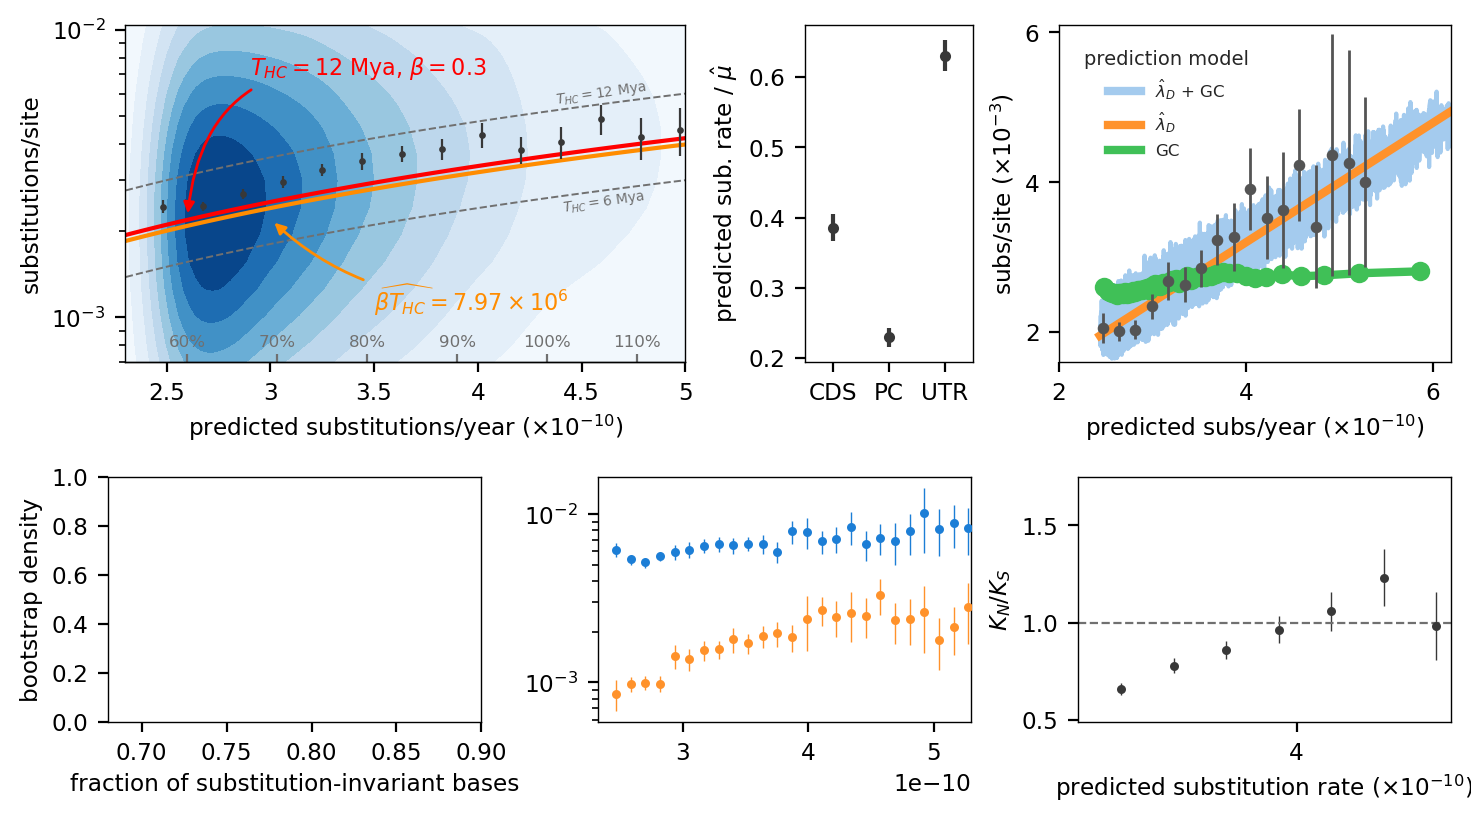

In [508]:
def model_comparison_plot(df, models, nbin, figax=None):
    #fancy_labels = {'pred_subrate + gc': "$\widehat{\lambda}_D$ + GC", 'pred_subrate': "$\widehat{\lambda}_D$", 'gc': 'GC'}
    fancy_labels = {'pred_subrate + gc': "$\hat{\lambda}_D$ + GC", 'pred_subrate': "$\hat{\lambda}_D$", 'gc': 'GC'}

    fig, ax = get_figax(figax)

    for model, res in models['total'].items():
        label = fancy_labels[model]
        if model == 'gc':
            do['bins'] = pd.qcut(df['r_rs_year'], 50)
            gcdf = df.groupby('bins')['r_rs_year', 'gc', 'total_prop'].mean().reset_index()
            intercept, slope = res.params
            gcdf['pred'] = res.predict(pd.DataFrame(dict(gc=gcdf['gc'])))
            lines = ax.plot(gcdf['r_rs_year'], gcdf['pred'], label=label, linewidth=3, zorder=1)
            ax.scatter(gcdf['r_rs_year'], gcdf['pred'], c=lines[0].get_color(), zorder=0)
        else:
            f = res.model
            exog_names = np.array(f.exog_names)
            x = f.exog[:, exog_names == 'r_rs_year'].flat
            y = res.fittedvalues.values
            idx = np.argsort(x)
            alpha = 0.4 if model == 'pred_subrate + gc' else 1
            ax.plot(x[idx], y[idx].flat, label=label, alpha=alpha, linewidth={'pred_subrate': 3}.get(model, 1.5), zorder=-1)

    leg = ax.legend(loc='upper left', title='prediction model', title_fontsize=7, prop={'size': 6})

    ## the binned data means
    binned_means_plot(binned_summaries(df['r_rs_year'], df['total_prop'], nbin, cut_tails=(0, 0.98)), figax=(fig, ax),
                      linewidth=1, s=10, c='0.33', thin=3, min_n=20)

    leg.legendHandles[0].set_linewidth(3)

    #break_pt = 5.55e-10
    #ax.axvline(break_pt, linestyle='dashed', c='0.44', zorder=-20)
    #frac_data_below = (do['r_rs_year'] < 4.7e-10).mean()
    #ax.text(break_pt*0.99, 0.0055, f"{int(np.round(100*frac_data_below))}% of genes", horizontalalignment='right')
    #ax.annotate("", xy=(break_pt*0.8, 0.0054), xytext=(break_pt, 0.0054), ha="center", arrowprops=dict(arrowstyle="<-", color='0.22'))
    
    ax.set_xlabel(f"predicted subs/year ($\\times 10^{{{-10}}}$)")

    
    ax.set_ylim(0.0016, 0.0061)
    #ax.set_xticks(np.array([3, 4, 5, 6])/1e-10)
    #ax.set_xticklabels([3, 4, 5, 6])

#     # rug plot stuff
#     ax.plot(df['r_rs_year'], [ax.get_ylim()[0]]*len(df), '|', color='k', alpha=0.01)
#     probs = (0.95, )
#     for prob in probs:
#         x, y = np.quantile(df['r_rs_year'], prob), ax.get_ylim()[0]
#         y = y*1.4
#         #ax.scatter(x, y, s=2, c='0.22')
#         ax.plot((x, x), (y*0.5, y*0.9), c='0.22')
#         ax.text(x, y*0.85, f"{int(np.round(100*prob))}% of genes  ", verticalalignment='center', horizontalalignment='right')
#         ax.annotate(f"", (x*0.95, 0.79*y), (x, 0.79*y), color='k', arrowprops=dict(color='0.22', arrowstyle='-|>'),  ha="center")
#     #binned_means_plot(binned_summaries(do['r_rs_year'], do['total_prop'], 30, method='number'), figax=(fig, ax), linewidth=1, s=10, c='0.22')
    
    y_axis_scaler = 1e3
    #yticks = ax.axes.get_yticks()[1:]
    yticks = np.arange(2, 7, 2)/y_axis_scaler
    ax.axes.set_yticks([y for y in yticks])
    ax.axes.set_yticklabels([pretty_signif(x*y_axis_scaler) for x in yticks])
    ax.set_ylabel(f"subs/site ($\\times 10^{{{-int(np.log10(y_axis_scaler))}}}$)")
    
    xaxis_scaler = 1e10
    if xaxis_scaler is not None:
        xticks = ax.axes.get_xticks()
        ax.axes.set_xticks([x for x in xticks])
        ax.axes.set_xticklabels([pretty_signif(x*xaxis_scaler) for x in xticks])
        
    ax.set_xlim(ax.get_xlim()[0], 6.2e-10)
    
    #ax.spines['right'].set_visible(True)
    #ax.spines['top'].set_visible(True)
    
    return fig, ax

#plt.savefig('../manuscript/figures/pred_subrate.pdf')

plt.style.use('./buffalo.mplstyle')

lw = 0.5
flw = 1
tfs = 6
ls = 5
lax = 4.6e-10
xlim = (2.3e-10, 5e-10)

T_HCs_np = np.array(T_HCs)

#### Main figure setup
fig = plt.figure(constrained_layout=True, figsize=(7.24, 4))

subfigs = fig.subfigures(2, 1, wspace=0.11, height_ratios=[2, 1.6])

#spacer_ax = [None]
first_row = subfigs[0].subplots(1, 3, width_ratios=[1, 0.3, 0.7])
subrate_ax, rate_cis_ax, comparison_ax = first_row
# for ax in spacer_ax:
#     ax.axis('off')
# subfigs[0, 0].subplots_adjust(wspace=0.7)


## Some rough guestimates for comparison
THEORY_EST = (12e6, 0.3)

sub_kde_plot(xx['r_rs_year'], xx['subrate'], T_HCs=T_HCs_np, 
             #kde=False, scatter=True, # uncomment to see scatter plot version
             xlim=(2.3e-10, 5e-10), 
             ylim=(7e-4, 1.04e-2),             
             nbins=nbin,   
             thin=2,
             xaxis_scaler=1e10,
             label_size=ls,
             T_HC_labx=lax,  
             error_lw=0.8, error_s=2, #error_c='k',
             theory=THEORY_EST,
             show_outliers=False,
             T_lw=0.7, 
             fit=fit_params,
             fit_lw=1.5,
             #tick_fontsize=tfs,
             #ylim=(2e-4, 4e-2), 
             cmap='Blues', 
             #figax=(fig, ax[0]),
             figax=(fig, subrate_ax),
            )


subrate_ax.annotate("$T_{HC} = "+f"{int(THEORY_EST[0]/1e6)}"+"$ Mya, $\\beta = "+f"{THEORY_EST[1]}"+"$",   (2.6e-10, 2.2e-3), (2.9e-10, 7e-3),
                    fontsize=8, c='r', 
                    arrowprops=dict(color='r', arrowstyle='-|>', connectionstyle="arc3,rad=0.5"),
                    ha="left")

subrate_ax.annotate("$\widehat{\\beta T_{HC}} = "+f"{fit_params[1]/1e6:,.2f} \\times 10^{{6}}$",   (3e-10, 2.2e-3), (3.5e-10, 1e-3),
                    fontsize=8, c='darkorange', va = "bottom", ha="left",
                    arrowprops=dict(color='darkorange', arrowstyle='-|>', connectionstyle="arc3,rad=-0.2"),
                    )


_ = model_comparison_plot(do, models, nbin, figax=(fig, comparison_ax))

# syn_ax, nonsyn_ax = subfigs[1, 0].subplots(1, 2)
# sub_kde_plot(x_rs, syn_prop, T_HCs=T_HCs_np, xlim=xlim, 
#              ylim=(1e-4, 5.04e-2),
#              cmap='Greens', 
#              xaxis_scaler=1e10,
#              nbins=nbin,
#              thin=2,             
#              T_HC_labx=lax,
#              label_size=ls,
#              T_lw=lw, fit_lw=flw,
#              tick_fontsize=tfs,
#              #ylim=(1e-3, 5e-2), 
#              ylabel="",
#              figax=(fig, syn_ax))
# sub_kde_plot(x_rs, nonsyn_prop, T_HCs=T_HCs_np, xlim=xlim, 
#              ylim=(1e-4, 5.04e-2),             
#              nbins=nbin,
#              thin=2,             
#              xaxis_scaler=1e10,
#              label_size=ls,
#              T_HC_labx=lax,             
#              T_lw=lw, fit_lw=flw,
#              tick_fontsize=tfs,
#              #ylim=(1e-4, 5e-2), 
#              ylabel="",
#              figax=(fig, nonsyn_ax))



dsr_rs['r_rs_mu'] = dsr_rs['r_rs'] / MU_EST
sr_stats = dsr_rs.groupby(['feature'], as_index=False).agg({'r_rs_mu': ['mean', 'std']}).reset_index()

rate_cis_ax.errorbar(sr_stats[('feature', '')], sr_stats[('r_rs_mu', 'mean')], 2*sr_stats[('r_rs_mu', 'std')], fmt='none', c='0.22')
rate_cis_ax.scatter(sr_stats[('feature', '')], sr_stats[('r_rs_mu', 'mean')], c='0.22', s=9)
rate_cis_ax.set_xticklabels(['CDS', 'PC', 'UTR'])
rate_cis_ax.set_xlim(-0.5, 2.5)
rate_cis_ax.set_ylabel("predicted sub. rate / $\\hat{\\mu}$") 


second_row = subfigs[1].subplots(1, 3, width_ratios=[1, 1, 1])
frac_ax, syn_nonsyn_ax, dnds_ax = second_row
# labs = set()
# for i, T in enumerate(T_HCs):
#     c = COLORS[i]
#     #lines = frac_ax.axvline(beta[i], label=f"T = {int(T/1e6)} Mya", color=c)
#     _ = frac_ax.hist(boot_ests[:, i], 50, density=True, color=c, alpha=0.4)

frac_ax.legend()
frac_ax.set_xlabel("fraction of substitution-invariant bases")
frac_ax.set_ylabel("bootstrap density")
frac_ax.set_xlim(0.68, 0.9)


## syn non-syn plot
binned_means_plot(binned_summaries(x_rs, syn_prop, nbin, cut_tails=(0, 0.98)), figax=(fig, syn_nonsyn_ax), thin=2, min_n=20, c=None, label='synon.')
binned_means_plot(binned_summaries(x_rs, nonsyn_prop, nbin, cut_tails=(0, 0.98)), figax=(fig, syn_nonsyn_ax), thin=2, min_n=20, c=None, label='non-synon.')
syn_nonsyn_ax.set_xlim(syn_nonsyn_ax.get_xlim()[0], 5.3e-10)
syn_nonsyn_ax.semilogy()

## dn/ds plot (I label it Kn/Ks
dnds_xaxis_scaler = 1e10
binned_means_plot(dnds_bins, figax=(fig, dnds_ax), min_n=20, thin=1)
dnds_ax.axhline(1, linestyle='dashed', c='0.44', linewidth=0.8)
dnds_ax.set_ylabel("$K_N/K_S$")
dnds_ax.set_xlabel(f"predicted substitution rate ($\\times 10^{{{-int(np.log10(dnds_xaxis_scaler))}}}$)")
# cut_point = np.quantile(x_rs, 0.95)
dnds_ax.set_ylim(0.49, 1.75)
    
# rescale the x-axis
xticks = dnds_ax.axes.get_xticks()
dnds_ax.axes.set_xticks([x for x in xticks])
dnds_ax.axes.set_xticklabels([pretty_signif(x*dnds_xaxis_scaler) for x in xticks])


## NOTE: truncating the x-axis to just match the othe figures. The prediction model plot shows these are outliers...
dnds_ax.set_xlim(2.3e-10, 5.2e-10)

#plt.tight_layout()
#plt.savefig('../manuscript/figures/sub_figure.pdf')

#### Non-synonmous and Synonmous Slopes

We can also look at the slopes of synon and non-synon sites separately. Note that it would be tempting to try to estimate $\beta$ for each, *however*, this is invalid since the predicted substitution rates are only know for the whole CDS, not each group of sites seperately.

In [1057]:
#  
est_beta(smf.ols('syn_prop ~ r_rs_year', data=do).fit().params[1], 12e6), est_beta(smf.ols('nonsyn_prop ~ r_rs_year', data=do).fit().params[1], 12e6)

(0.18039300842728834, 0.404503087661812)

ERROR! Session/line number was not unique in database. History logging moved to new session 2399


/home/vsb/projects/bprime/bgspy/plots.py:50: DeprecationWarning: invalid escape sequence \h
  ax.set_xlabel('predicted $\hat{\pi}$')


[]

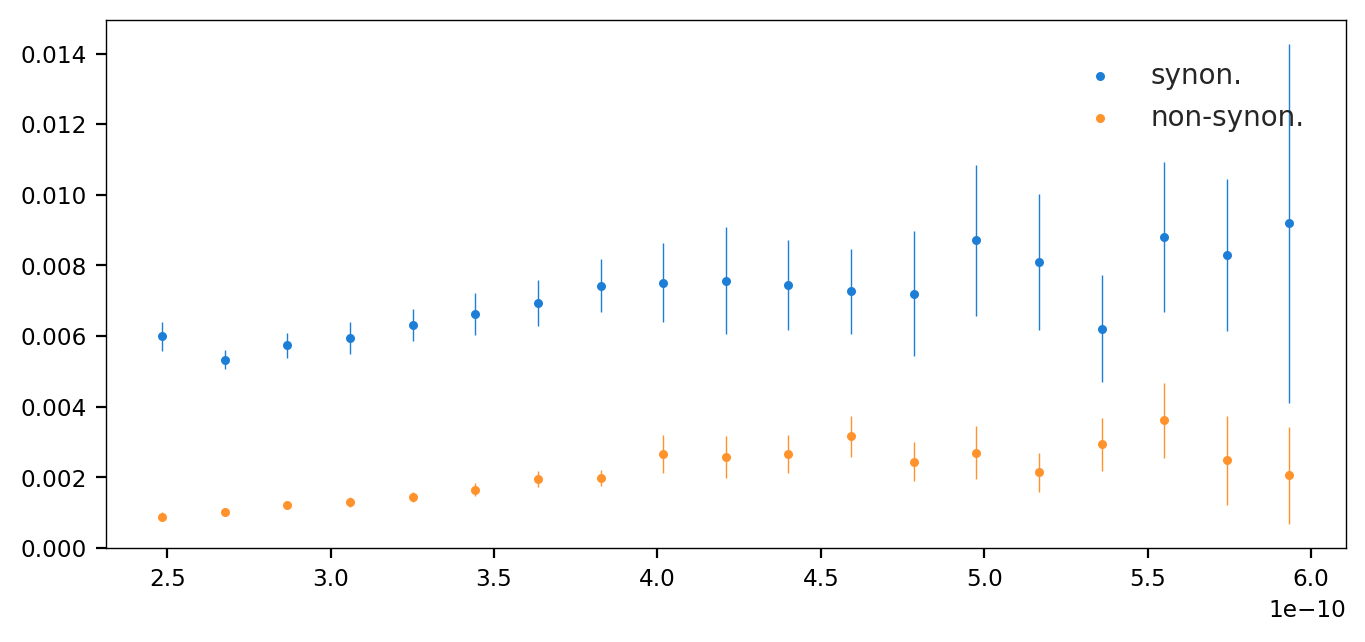

In [1052]:
fig, ax = plt.subplots()
binned_means_plot(binned_summaries(x_rs, syn_prop, nbin), figax=(fig, ax), thin=2, min_n=20, c=None, label='synon.')
binned_means_plot(binned_summaries(x_rs, nonsyn_prop, nbin), figax=(fig, ax), thin=2, min_n=20, c=None, label='non-synon.')
ax.legend()
syn_nonsyn_ax.semilogy()

#### Experimental KDE Plot

In [837]:
df_nonsyn, df_syn = do.loc[:, ('r_rs', 'nonsyn_prop')].copy(), do.loc[:, ('r_rs', 'syn_prop')].copy()
df_nonsyn['type'] = 'non-synonymous'
df_syn['type'] = 'synonymous'
df_syn = df_syn.rename(columns={'syn_prop': 'prop'})
df_nonsyn = df_nonsyn.rename(columns={'nonsyn_prop': 'prop'})

In [848]:
dsb = pd.concat((df_syn, df_nonsyn), axis=0).reset_index()
dsb.loc[dsb['prop'] == 0, 'prop'] = dsb.loc[dsb['prop'] > 0].min()
dsb.head()

index          r_rs      prop        type
0      0  8.610962e-09  0.005906  synonymous
1      1  9.234576e-09  0.015248  synonymous
2      2  1.012162e-08  0.016529  synonymous
3      3  9.110700e-09  0.006334  synonymous
4      4  1.038721e-08  0.004792  synonymous

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/seaborn/_core.py:1165: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.3":
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


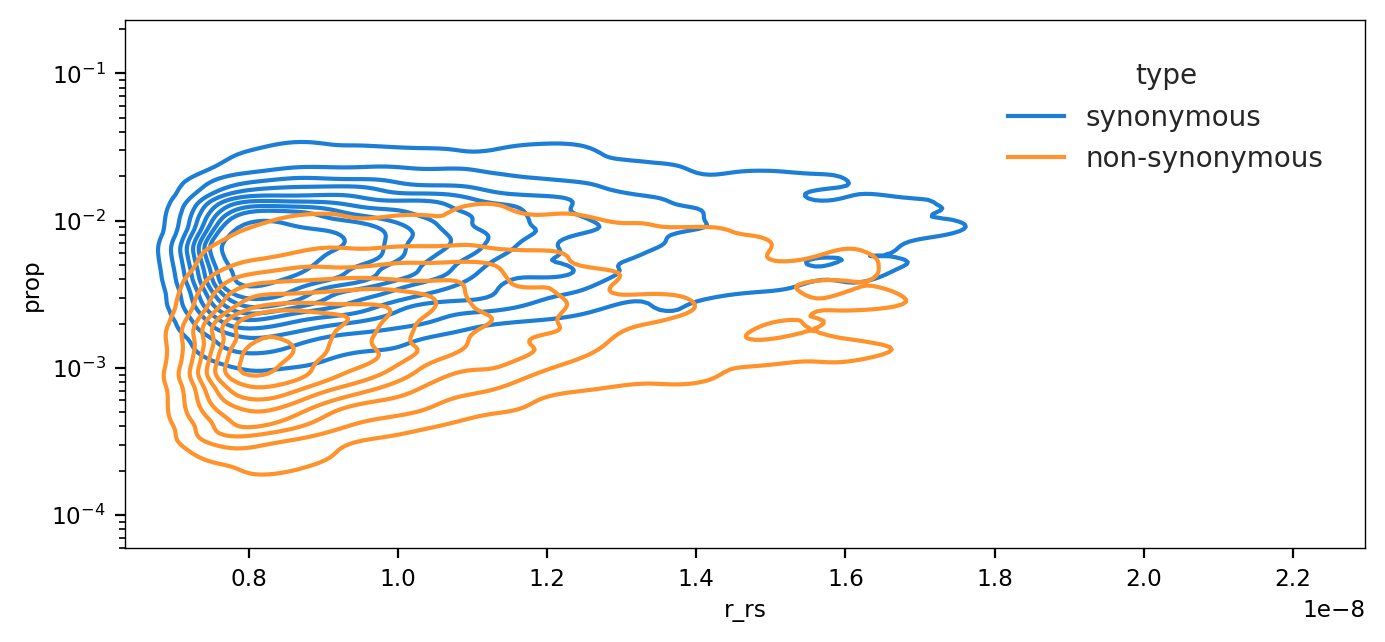

In [850]:
kde = sns.kdeplot(x='r_rs', y='prop', hue='type', data=dsb, bw_adjust=.5, log_scale=(None, 10), 
                  alpha=1, bw_method=0.3, zorder=-1)

#### Check of the x-axis

In [232]:
# estimated substitutions on human branch for different divergence times
MU * (np.array(T_HCs) * u.year)

unyt_array([0.0026, 0.0052], 'mutations')

In [230]:
# under neutrality, substitution rate is mutation rate
neutral_subrate = MU
neutral_subrate, neutral_subrate.to('mutations/year')

(unyt_quantity(1.3e-08, 'mutations/human_gen'),
 unyt_quantity(4.33333333e-10, 'mutations/yr'))

### Rough Estimates of the Fraction of Sites Capable of Alternative

Some back-of-the-envelope calculations on the possible estimate of the substitutional sieve.



In [984]:
intercept, slope = smf.ols('total_prop ~ r_rs_year', data=do).fit().params.values
intercept, slope

(9.824599448546837e-06, 7967329.978447142)

In [1042]:
est_beta(smf.ols('syn_prop ~ r_rs_year', data=do).fit().params.values[1], T_HCs), est_beta(smf.ols('nonsyn_prop ~ r_rs_year', data=do).fit().params.values[1], T_HCs)

(array([-0.63921398,  0.18039301]), array([-0.19099382,  0.40450309]))

### Alternate generation time (29y)

In [953]:
do['r_rs_year29'] = d['r_rs'] / 29

In [970]:
bn_fit = smf.glm('total_prop ~ r_rs_year29', data=do.loc[do['r_rs_year'] < 5e-10], family=sm.api.families.Binomial()).fit()
bn_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             total_prop   No. Observations:                15670
Model:                            GLM   Df Residuals:                    15668
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -241.37
Date:                Mon, 16 Jan 2023   Deviance:                       32.930
Time:                        21:04:38   Pearson chi2:                     49.5
No. Iterations:                     9   Pseudo R-squ. (CS):          0.0001176
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -7.0960      0.850     -8.346      0.000      -8.763      -5.430
r_rs_year29  3.378e+09   2.42e+09      1.396      0.163   -1.36e+09    8.12e+09
===============================================================================
"""

In [972]:
from bgspy.substitution import JC69

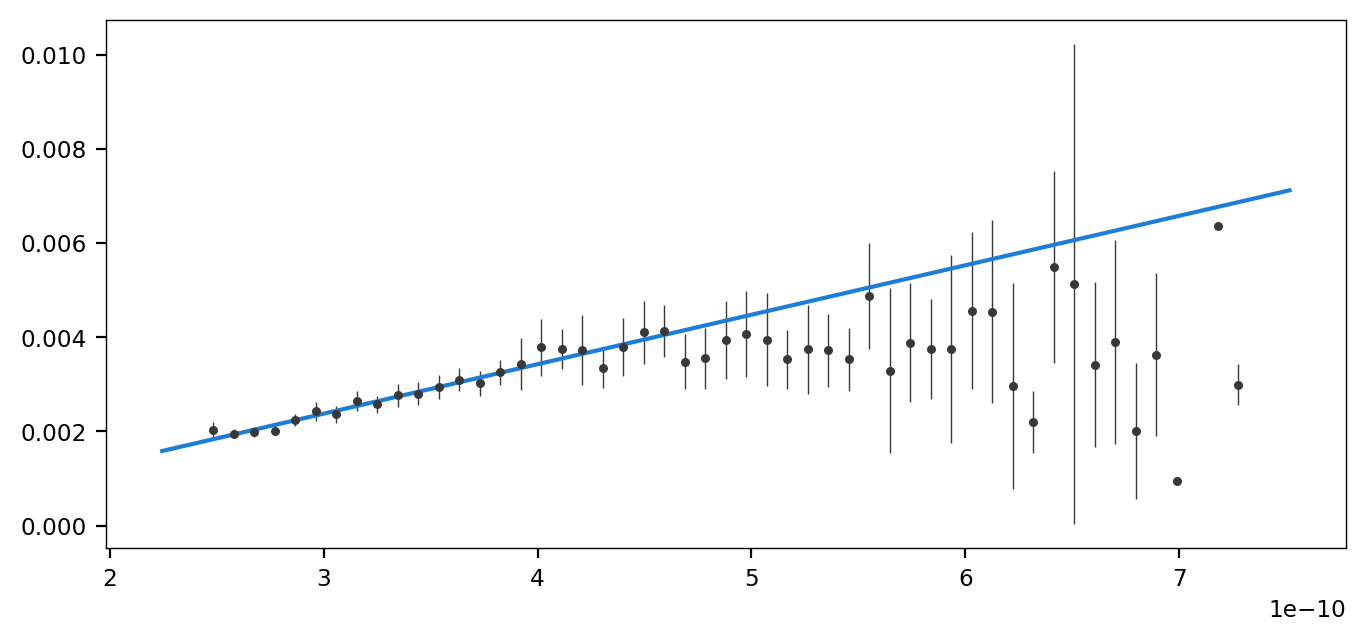

In [998]:
fig, ax = plt.subplots()
binned_means_plot(binned_summaries(x_rs, total_prop, nbin), figax=(fig, ax))
xp = np.linspace(*ax.get_xlim(), 100)
ax.plot(xp, censored_fit_params[0] + censored_fit_params[1] * xp)

In [980]:
(x_rs < 4e-10).mean()

0.8493503309634715

In [995]:
censored_fit_params = smf.ols('total_prop ~ r_rs_year', data=do.loc[do['r_rs_year'] < 4e-10]).fit().params.values

In [996]:
slope, censored_fit_params

(7967329.978447142, array([-7.73715349e-04,  1.05074298e+07]))

In [ ]:
censored_fit_params[1]

In [954]:
intercept, slope = smf.ols('total_prop ~ r_rs_year29', data=do).fit().params.values

$$
K = (1-\beta)T(\lambda_d + \lambda_b)
$$

Our predictions are $\lambda_d$ estimates; hereafter these are $x$ to indicate that we treat them as the x in a linear regression.
Also, we denote $y = K$ as $y$ is the proportion of substitutions on the human lineage.

Assuming $\lambda_d >> \lambda_b$,

$$
y =  (1-\beta) T x
$$

we define $\gamma = (1-\beta) T$ as the slope parameter. Our estimate is

$$
y = \gamma x + c 
$$
 
where we use $c$ as an extra degree of freedom to better estimate the slope. 

Then, a rough estimator of $\hat{\beta}$ is 

$$
\hat{\beta} = 1-\hat{\gamma}/T
$$

Alternatively, if we knew $\beta$, we could estimate $T$,

$$
T = \frac{\hat{\gamma}}{1-\beta}
$$


In [1035]:
1/1.3

0.7692307692307692

In [989]:
def est_beta(gamma, T):
    return 1 - gamma/T

def est_T(gamma, beta):
    return gamma / (1-beta)

In [997]:
est_beta(censored_fit_params[1], 12e6), est_T(censored_fit_params[1], 0.8)/1e6

(0.12438084821173578, 52.53714910729586)

In [958]:
beta_pollard = 0.5

In [960]:
slope/(1-beta_pollard) / 1e6

15.403504624997813

In [961]:
beta = 1 - (slope / T_HCs)
beta

array([-0.28362539,  0.35818731])

Now let's do a bootstrap of this.

In [1011]:
# check the two approaches give same results...
stats.linregress(x_rs, total_prop)[:2], smf.ols('total_prop ~ r_rs_year', data=do).fit().params.values

((7967329.978447149, 9.824599448543612e-06),
 array([9.82459945e-06, 7.96732998e+06]))

In [1015]:
def bootstrap_ols_fit(x, y, nboot):
    bs_slopes = np.zeros(nboot, dtype='int')
    n = len(x)
    for b in range(nboot):
        idx = np.random.randint(0, n, n)
        boot_fit = stats.linregress(x[idx], y[idx])
        slope, intercept, r, p, se = boot_fit
        bs_slopes[b] = slope
    return bs_slopes
        
bootstrap_ols_fit(x_rs, total_prop, 100).mean()

7991912.43

(array([ 1.,  4.,  6., 15., 33., 22.,  8.,  7.,  3.,  1.]),
 array([13.86800889, 14.32018444, 14.77236   , 15.22453556, 15.67671111,
        16.12888667, 16.58106222, 17.03323778, 17.48541333, 17.93758889,
        18.38976444]),
 <BarContainer object of 10 artists>)

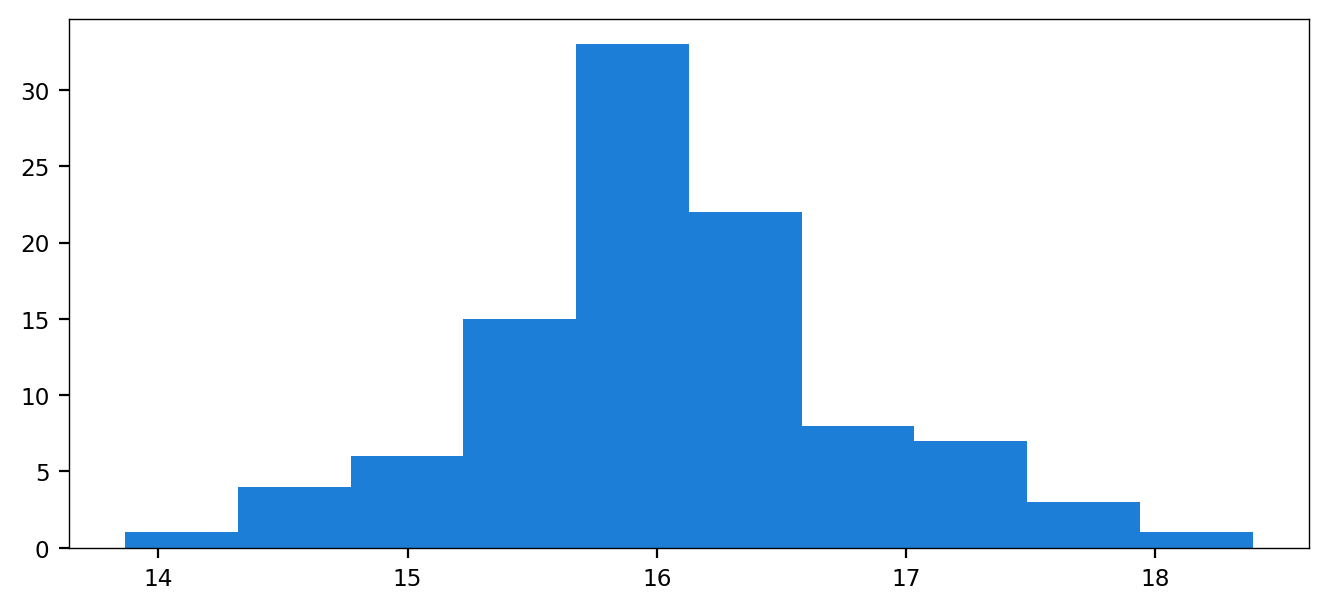

In [1040]:
plt.hist(est_T(bootstrap_ols_fit(x_rs*1.1, total_prop, 100), 0.55)/1e6)

In [1018]:
slope, est_beta(7991912.43, 12e6)

(7967329.978447142, 0.3340072975)

In [1024]:
## if we trust beta_CDS ~ 0.55

0.55 * 12e6

6600000.000000001

In [1026]:
(7991912.43 / 0.55) / 1e6

14.530749872727272

In [892]:
T_HCs = np.array(T_HCs)

(array([   9.,   87.,  435., 1448., 2635., 2874., 1770.,  634.,  101.,
           7.]),
 array([0.07879575, 0.10435044, 0.12990513, 0.15545983, 0.18101452,
        0.20656921, 0.2321239 , 0.25767859, 0.28323328, 0.30878797,
        0.33434267]),
 <BarContainer object of 10 artists>)

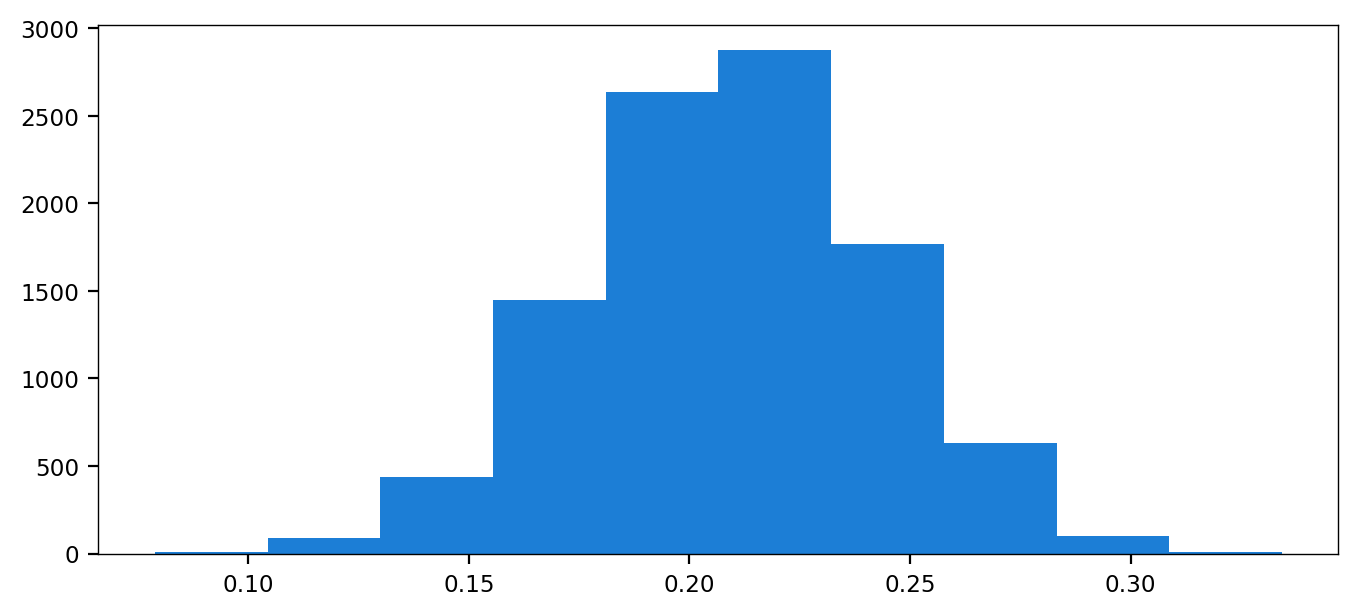

In [898]:
plt.hist(1 - (bs_slopes / T_HCs[1]))

**TODO** FIX BELOW

Hellman et al. (2003) divergence estimate is 0.45 for coding sequences, 1.09 for 4D sites, and 1.28 for intergenic sites.

A *very rough* estimator of the fraction of conserved sites is to assume that we have neutral evolution and evolution were some fraction of sites can't change, e.g. 

$$
K_n = \mu T
$$


$$
K_c = (1-\beta)\mu T
$$


$$
\beta = 1-K_c/K_n
$$

In [1019]:
Kn = np.array([1.09, 1.28])
Kc = 0.45
1 - Kc/Kn

array([0.58715596, 0.6484375 ])

So something like ~60% of sites are conserved. Again, this is very rough.

In Pollard et al. (2010), they estimate the fraction of conserved sites for different classes of sites. For the first, second, third positions of codons, they report the following fractions (Figure 4C). The emphasize this is a lower bound and approximate though in the caption.

In [1020]:
pollard_cds_cons_est = (np.array([65.5, 70.8, 24.6])/100).mean()
pollard_cds_cons_est

0.5363333333333333

Table 1 of Davydov et al (2010) suggests that 84.6% percent of exons are covered by a consered element.

In [1021]:
davydov_cds_cons_est = 0.846

What are the split times implied by these estimtes?

In [320]:
np.array([slope / pollard_cds_cons_est, slope / davydov_cds_cons_est]) / 1e6

array([18.36293946, 11.64143798])

For phastcons, Pollard et al report 87.9%. Our CDS include some phascons sites, since we prioritize genomic features. So the fraction above should be weighted by the overlap between phastcons and CDS.

I did the follow rough calculation to estimate the fraction of constrained sites:

```
$ bedtools intersect -b <(bedtools merge -i conserved_phastcons.bed.gz) -a <(bedtools merge -i hg38.ensembl_cds.bed.gz ) | \
    bioawk -cbed 'BEGIN {a=0} {a += $end-$start} END {print a}'

22878020

$ zcat hg38.ensembl_cds.bed.gz | grep -v chrX | bedtools merge | bioawk -cbed 'BEGIN {a=0} {a += $end-$start} END {print a}'
34261868
```

The overlap estimates are close, 91,486,641 and 91,485,992.

In [1059]:
frac_cds_phastcons = 22878020 / 34261868
frac_cds_phastcons

0.6677400076376454

In [323]:
est_pollard_frac_cons = frac_cds_phastcons * 87.9/100 + (1-frac_cds_phastcons)*pollard_cds_cons_est
est_pollard_frac_cons

0.7564471409829759

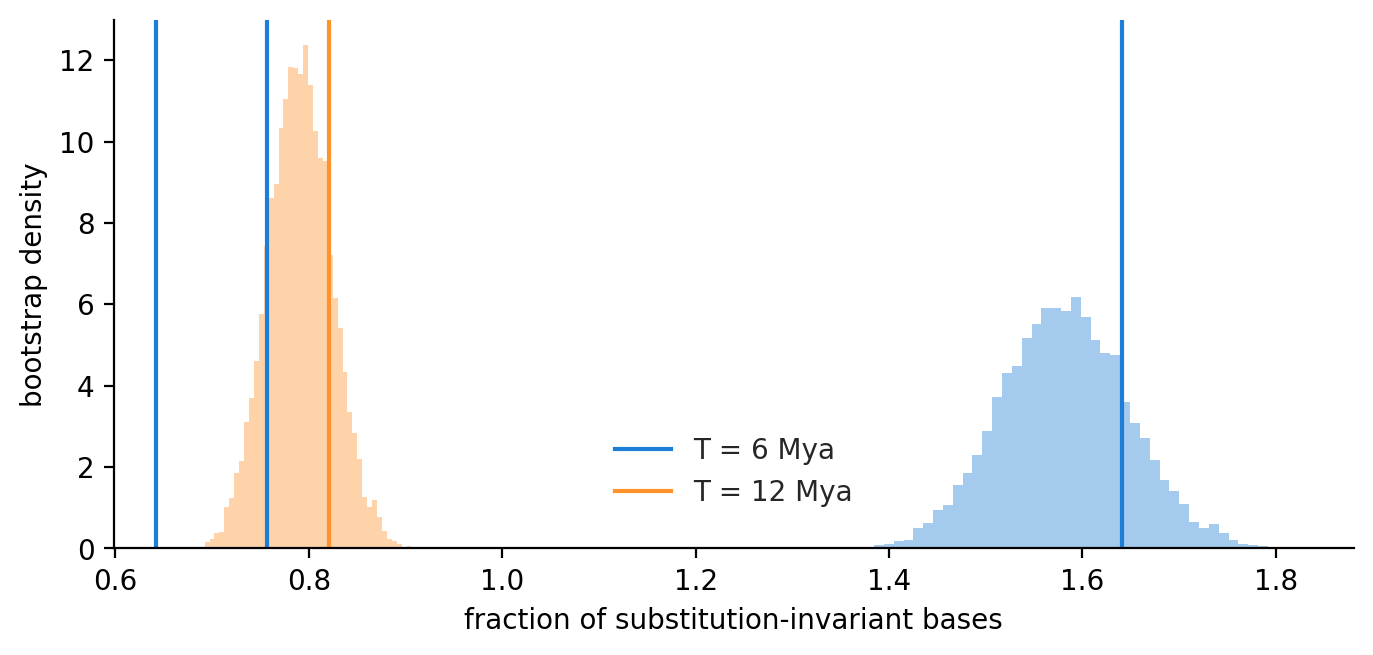

In [324]:
boot_ests = (bs_slopes / T_HCs[:, None]).T

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots()

labs = set()

for i, T in enumerate(T_HCs):
    c = colors[i]
    lines = ax.axvline(beta[i], label=f"T = {int(T/1e6)} Mya", color=c)
    _ = ax.hist(boot_ests[:, i], 50, density=True, color=c, alpha=0.4)

ax.legend()
ax.set_xlabel("fraction of substitution-invariant bases")
ax.set_ylabel("bootstrap density")

ax.axvline(est_pollard_frac_cons)
ax.axvline(frac_cds_phastcons)

In [231]:
# what's the average predicted ratchet rate in mutations/human generation?

cds_subrate = do['r_rs'].mean() * (u.mutations/u.human_gen)
cds_subrate, cds_subrate.to('mutations/year'), cds_subrate.to('mutations/year') / neutral_subrate

(unyt_quantity(9.91591974e-09, 'mutations/human_gen'),
 unyt_quantity(3.30530658e-10, 'mutations/yr'),
 unyt_quantity(0.76276306, '(dimensionless)'))

This matches the x-axis scale of the plots above, in fixations / year

Quick look at how DFE and implied neutral/nearly neutral sites:

In [232]:
W = bpfit_sm.mle_W 
np.round(W, 2)

array([[0.02, 0.05, 0.48],
       [0.19, 0.13, 0.03],
       [0.2 , 0.05, 0.13],
       [0.05, 0.02, 0.1 ],
       [0.13, 0.19, 0.17],
       [0.25, 0.35, 0.05],
       [0.17, 0.21, 0.05]])

In [233]:
Ns = bpfit_sm.t * 10_000 
can_fix = Ns > 1
Ns, can_fix

(array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 array([False, False, False, False,  True,  True,  True]))

In [234]:
W[can_fix, np.array(bpfit_sm.features) == 'cds'].sum()

0.5442121074307021

So ~54% of mutations could possibly fix. The actual rate is much lower.

In [457]:
(3e-8 - 1.3e-8)/1.3e-8

1.3076923076923075

In [336]:
dsr.loc[dsr['feature'] == 'utr', 'r_rs']

314        1.991556e-08
315        1.991684e-08
328        1.997122e-08
1929       1.995594e-08
1935       1.993759e-08
               ...     
7647014    1.995340e-08
7647015    1.994999e-08
7647016    1.995625e-08
7647017    1.996358e-08
7647018    1.997166e-08
Name: r_rs, Length: 194070, dtype: float64

<SecondaryAxis: >

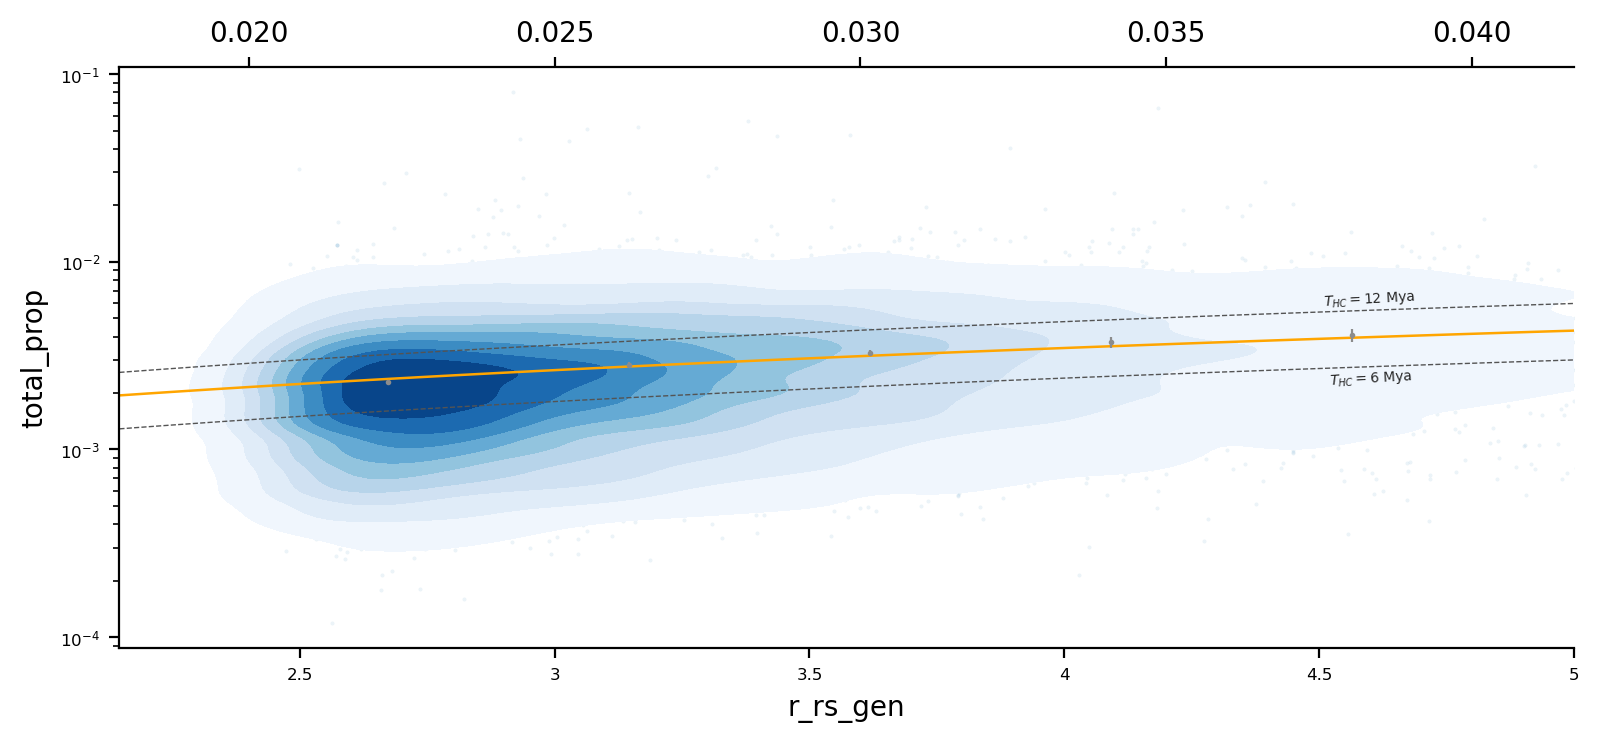

In [102]:
## random test plot, for experiments

fig, ax = plt.subplots()
sub_kde_plot(x_rs, total_prop, T_HCs=T_HCs, xlim=(None, 5e-10), 
             nbins=10,   
             xaxis_scaler=1e10,
             label_size=ls,
             T_HC_labx=lax,             
             T_lw=lw, fit_lw=flw,
             tick_fontsize=tfs,
             #ylim=(2e-4, 4e-2), 
             cmap='Blues', figax=(fig, ax))

ax.secondary_xaxis('top', functions=(scale_neutral, neutral_to_sub))

In [558]:
## some quick calcs I always forget


# assumiming 6.5e6 divergence time implies a mutation rate of 

1e-9 # subs/year from Moorjani et al 2016

1e-9 * gen_time# x (gen years/gen)

3.0000000000000004e-08

This is two-fold higher than pedigree estimates as Moorjani et al. (2016) explain.

/tmp/ipykernel_37014/2039554002.py:23: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim((0, 0.2e-6))


(2.0653388862371308e-10, 2e-07)

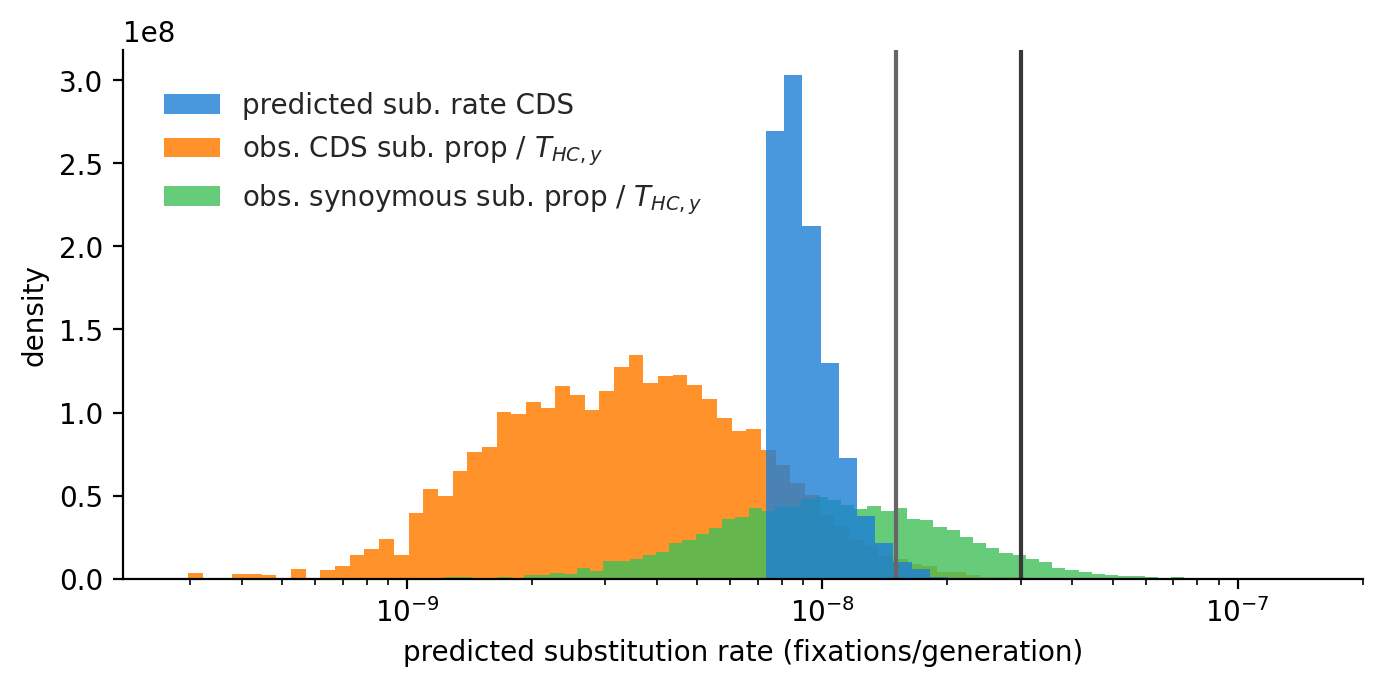

In [559]:
xscaler = 1e9

fig, ax = plt.subplots()
ax.hist(*logbins(do['r_rs'].values, 10), density=True, label='predicted sub. rate CDS', zorder=2, alpha=0.8)
#ax.hist(*logbins(dutr['r_rs'].values, 10), density=True, label='predicted sub. rate UTRs', zorder=2)

implied_subrate_gen = gen_time*do['total_prop'].values/(12e6)
implied_subrate_gen = implied_subrate_gen[implied_subrate_gen > 0]
ax.hist(*logbins(implied_subrate_gen, 80), density=True, label='obs. CDS sub. prop / $T_{HC,y}$')

implied_subrate_syn_gen = gen_time*do['syn_prop'].values/(12e6)
implied_subrate_syn_gen = implied_subrate_syn_gen[implied_subrate_syn_gen > 0]
ax.hist(*logbins(implied_subrate_syn_gen, 80), density=True, label='obs. synoymous sub. prop / $T_{HC,y}$', alpha=0.8)

ax.semilogx()
ax.axvline(3e-8, c='0.22')
ax.axvline(1.5e-8, c='0.4')
ax.set_ylabel("density")
#ax.set_xlabel(f"predicted substitution rate (fixations/year $\\times 10^{{{int(np.log10(xscaler))}}}$)")
ax.set_xlabel(f"predicted substitution rate (fixations/generation)")# $\\times 10^{{{int(np.log10(xscaler))}}}$)")
#ax.set_xlim((-2.8e-09, 5.91e-08))
ax.legend(loc='upper left')
ax.set_xlim((0, 0.2e-6))

## Total Number of Deleterious Mutations

In [296]:
dsr.groupby('feature')['r'].mean()

feature
cds          1.235943e-08
phastcons    7.371133e-09
utr          2.021353e-08
Name: r, dtype: float64

In [297]:
np.exp(dsr_rs.groupby('feature')['load_region'].sum())

feature
cds          0.999660
phastcons    0.929993
utr          0.999775
Name: load_region, dtype: float64

In [308]:
np.exp(dsr_rs['load_region'].sum())

0.9294677984602233

In [301]:
u.define_unit('human_haploid_genome_size', 3e9 * u.counts)

In [302]:
(hs_mu * u.human_haploid_genome_size).to('counts/human_gen')

unyt_quantity(39., 'counts/human_gen')

In [305]:
np.sum(dsr['R'])

2.720003844493329